<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/GBPCHF/GBPCHF_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "GBPCHF"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-24 15:13:27,696 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-24 15:13:27,697 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for GBPCHF
2019-08-24 15:16:14,749 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-24 15:22:01,459 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-24 15:24:57,466 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-24 15:27:52,210 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-24 15:30:54,652 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-24 15:33:46,624 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-24 15:36:44,560 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-24 15:39:39,594 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-24 15:49:09,151 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_GBPCHF__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-GBPCHF__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-GBPCHF to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close        Volume
Date                                                                 
2018-01-01 22:00:00  1.31359  1.31565  1.31359  1.31446    111.250000
2018-01-01 23:00:00  1.31439  1.31729  1.31425  1.31689   5647.540039
2018-01-02 01:00:00  1.31620  1.31698  1.31610  1.31645   3469.209961
2018-01-02 02:00:00  1.31646  1.31676  1.31591  1.31595   2466.209961
2018-01-02 03:00:00  1.31595  1.31641  1.31560  1.31581   3095.550049
...                      ...      ...      ...      ...           ...
2018-12-31 17:00:00  1.25438  1.25465  1.25207  1.25265  11819.540039
2018-12-31 18:00:00  1.25259  1.25399  1.25233  1.25352   7315.290039
2018-12-31 19:00:00  1.25351  1.25413  1.25111  1.25350   4241.390137
2018-12-31 20:00:00  1.25349  1.25352  1.25239  1.25267   3995.689941
2018-12-31 21:00:00  1.25269  1.25336  1.25025  1.25169   4419.660156

[6213 rows x 5 columns]

Open         High          Low        Close        Volume
count  6213.000000  6213.000000  6213.000000  6213.000000   6213.000000
mean      1.305757     1.306652     1.304844     1.305752   6361.236328
std       0.032405     0.032400     0.032426     0.032408   3227.080322
min       1.239930     1.240750     1.237920     1.239920    111.250000
25%       1.278120     1.279000     1.277160     1.278110   3762.780029
50%       1.306990     1.308030     1.305970     1.306960   6105.950195
75%       1.323860     1.324710     1.322900     1.323870   8538.309570
max       1.384060     1.385540     1.383110     1.384070  24784.500000

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close        Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 01:00:00  1.32035  1.32152  1.32023  1.32124   3498.060059    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  1.321014  1.311253 -1.322904  1.320392  1.320587  1.321010    1.320570    1.320535  1.321640  1.320281  1.320593  1.320175  1.320396  1.320281  1.320560  1.321176                1.321077                 1.320281                1.319485                1.321475                 1.320281                1.319087                1.321873                 1.320281                1.318689                1.322271                 1.320281                1.318291  1.320587  1.320730  1.321086                1.321383                 1.320587                1.319791                1.321781                 1.320587                1.319393                1.322179                 1.320587                1.318995                1.322577                 1.320587   
2018-01-04 02:00:00  1.32126  1.32176  1.32101  1.32150   3113.550049    4          3          4             31     2             0               1               0                 1      1        1     1        3             3           1  1.321257  1.313754 -1.322761  1.320796  1.320790  1.321090    1.320700    1.320690  1.319330  1.320461  1.321109  1.320310  1.320667  1.320461  1.321370  1.321089                1.321567                 1.320461                1.319356                1.322119                 1.320461                1.318803                1.322672                 1.320461                1.318250                1.323225                 1.320461                1.317698  1.320790  1.321304  1.320998                1.321895                 1.320790                1.319684                1.322448                 1.320790                1.319131                1.323001                 1.320790                1.318579                1.323553                 1.320790   
2018-01-04 03:00:00  1.32151  1.32189  1

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6163.000000  6163.000000  6163.000000  6163.000000   6163.000000  6163.000000  6163.000000  6163.000000    6163.000000  6163.000000   6163.000000     6163.000000     6163.000000       6163.000000  6163.000000  6163.000000  6163.000000  6163.000000   6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000  6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000  6163.000000  6163.000000  6163.000000             6163.000000              6163.000000             6163.000000             6163.000000              6163.000000             6163.000000             6163.000000   
mean      1.305644     1.306540     1.304729     1.305638   6371.846191    15.903943     2.052572   183.894045      30.440045    11.493266      0.034237        0.972416        0.004056          0.995132     6.549732     2.520363    26.648872     2.052572      2.030180    26.648872     1.305730     1.305827    -0.034278     1.305637     1.305675     1.305770     1.305666     1.305607     1.305659     1.305675     1.305637     1.305675     1.305662     1.305675     1.305641     1.305750                1.307924                 1.305675                1.303426                1.309049                 1.305675                1.302301                1.310174                 1.305675                1.301176                1.311298                 1.305675                1.300052     1.305675     1.305643     1.305739                1.307924                 1.305675                1.303425                1.309049                 1.305675                1.302301                1.310173   
std       0.032511     0.032507     0.032532     0.032514   3231.535645     8.724080     1.509731   103.999234       0.844306     6.919654      0.181851        0.163791        0.063566          0.069605     3.409361     1.112774    14.856591     1.509731      1.457523    14.856591     0.032449     0.032314     1.305851     0.032523     0.032447     0.032308     0.032431     0.032435     0.032434     0.032461     0.032519     0.032467     0.032473     0.032461     0.032494     0.032368                0.032459                 0.032461                0.032552                0.032492                 0.032461                0.032631                0.032548                 0.032461                0.032732                0.032625                 0.032461                0.032855     0.032447     0.032494     0.032382                0.032442                 0.032447                0.032542                0.032474                 0.032447                0.032623                0.032527   
min       1.239930     1.240750     1.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 01:00:00  0.557969  0.557842  0.566912  0.564134  0.132915    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.564337  0.498190  0.022634  0.558207  0.559437  0.562815    0.559683    0.559024  0.567131  0.558469  0.560778  0.557838  0.558452  0.558469  0.560296  0.566838                0.539221                 0.558469                0.567364                0.526331                 0.558469                0.583130                0.513345                 0.558469                0.599002                0.496632                 0.558469                0.613722  0.559437  0.560072  0.565789                0.544936                 0.559437                0.573491                0.531843                 0.559437                0.590209                0.518439                 0.559437                0.605679                0.503058                 0.559437   
2018-01-04 02:00:00  0.564282  0.559500  0.572284  0.565938  0.117253    4          3          4             31     2             0               1               0                 1      1        1     1        3             3           1  0.566056  0.516301  0.022686  0.561023  0.560871  0.563381    0.560595    0.560109  0.551483  0.559734  0.564362  0.558786  0.560354  0.559734  0.565947  0.566211                0.542552                 0.559734                0.566471                0.530617                 0.559734                0.581242                0.518538                 0.559734                0.596196                0.502638                 0.559734                0.610065  0.560871  0.564080  0.565160                0.548475                 0.560871                0.572761                0.536345                 0.560871                0.588489                0.523852                 0.560871                0.603042                0.509305                 0.560871   
2018-01-04 03:00:00  0.566016  0.560398  

139907

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2y5y2y7o
  JVM stdout: /tmp/tmp2y5y2y7o/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2y5y2y7o/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_6ei22z
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_160342_mod...  0.571104  0.714551              0.457481  0.509406  0.259494
1  DeepLearning_grid_1_AutoML_20190824_160342_mod...  0.543485  0.744985              0.498371  0.521834  0.272311
2  DeepLearning_grid_1_AutoML_20190824_160342_mod...  0.531754  0.692624              0.480330  0.499739  0.249739
3  DeepLearning_grid_1_AutoML_20190824_160342_mod...  0.530272  0.693638              0.493454  0.500245  0.250245
4  DeepLearning_grid_1_AutoML_20190824_160342_mod...  0.528922  0.720292              0.495098  0.511546  0.261680
5  DeepLearning_grid_1_AutoML_20190824_160342_mod...  0.506678  4.642239              0.500000  0.705159  0.497249
6  DeepLearning_grid_1_AutoML_20190824_160342_mod...  0.500000  0.693151              0.500000  0.500002  0.250002
7  DeepLearning_grid_1_AutoML_20190824_160342_mod...  0.500000  0.693269              0.500000  0.500061  0.250061
8              DeepLearning_1_AutoML_20190824_160342  0.498387  0.700187              0.500000  0.503480  0.253492
9  DeepLearning_grid_1_AutoML_20190824_160342_mod...  0.490407  0.704675              0.496743  0.505660  0.255692

variable  relative_importance  scaled_importance  percentage
0              CDLADVANCEBLOCK             1.000000           1.000000    0.003524
1             is_quarter_start             0.956935           0.956935    0.003372
2               CDLMORNINGSTAR             0.943298           0.943298    0.003324
3            CDLINVERTEDHAMMER             0.932932           0.932932    0.003288
4                 CDLTHRUSTING             0.929216           0.929216    0.003275
...                        ...                  ...                ...         ...
1032                   KAMA_20             0.213804           0.213804    0.000753
1033                    MIN_12             0.213799           0.213799    0.000753
1034   BBANDS_lowerband_24_2_4             0.210699           0.210699    0.000743
1035               CDL3OUTSIDE             0.209556           0.209556    0.000739
1036  BBANDS_middleband_20_1_2             0.209551           0.209551    0.000738

[1037 rows x 4 columns]

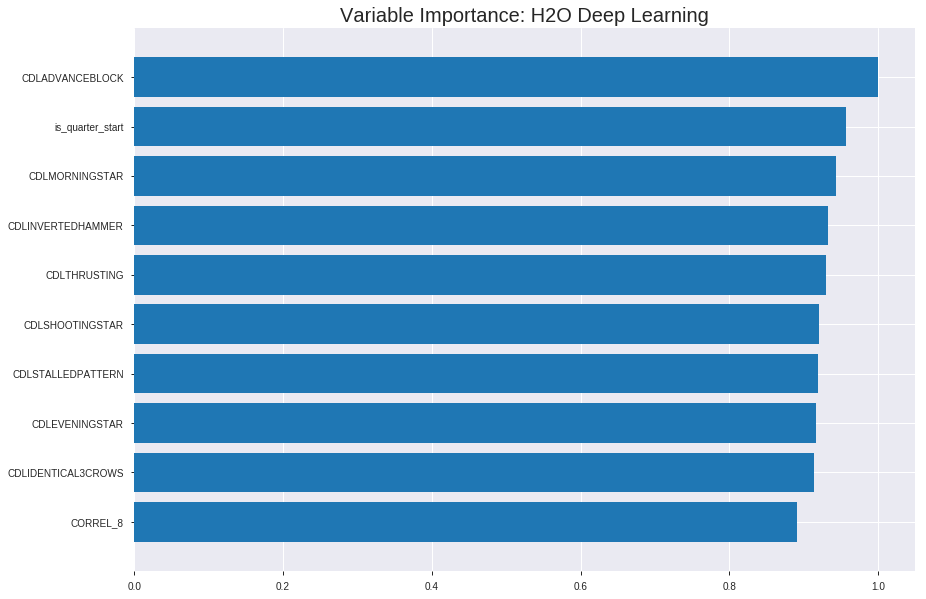

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_160342_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.27864414966617324
RMSE: 0.5278675493589023
LogLoss: 0.7738303715118631
Mean Per-Class Error: 0.4562914790298369
AUC: 0.5448141266338921
pr_auc: 0.5565448430282621
Gini: 0.08962825326778412
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03362965790707054: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      2    2131  0.9991   (2131.0/2133.0)
1      0    2180  0        (0.0/2180.0)
Total  2    4311  0.4941   (2131.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0336297    0.671699  398
max f2                       0.0336297    0.836467  398
max f0point5                 0.058395     0.561298  393
max accuracy                 0.469711     0.540923  120
max precision                0.732896     1         0
max recall                   0.0336297    1         398
max specificity              0.732896     1         0
max absolute_mcc             0.469711     0.101643  120
max min_per_class_accuracy   0.382164     0.531646  192
max mean_per_class_accuracy  0.469711     0.543709  120

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 36.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.641712           1.30397   1.30397            0.659091         0.675609  0.659091                    0.675609            0.0133028       0.0133028                  30.3972   30.3972
    2        0.0201716                   0.617813           1.38031   1.3417             0.697674         0.628127  0.678161                    0.652141            0.0137615       0.0270642                  38.0307   34.1701
    3        0.0301414                   0.598874           1.19627   1.2936             0.604651         0.608282  0.653846                    0.637634            0.0119266       0.0389908                  19.6266   29.3596
    4        0.0401113                   0.58492            1.05824   1.2351             0.534884         0.590453  0.624277                    0.625907            0.0105505       0.0495413                  5.82355   23.5096
    5        0.0500812                   0.574417           1.42632   1.27316            0.72093          0.579664  0.643519                    0.616701            0.0142202       0.0637615                  42.6317   27.3163
    6        0.100162                    0.534188           1.22737   1.25026            0.62037          0.553051  0.631944                    0.584876            0.0614679       0.125229                   22.7366   25.0264
    7        0.150012                    0.509734           1.09504   1.19868            0.553488         0.521997  0.605873                    0.563981            0.0545872       0.179817                   9.50437   19.8684
    8        0.200093                    0.486501           1.12661   1.18065            0.569444         0.498332  0.596756                    0.54755             0.056422        0.236239                   12.6612   18.0645
    9        0.300023                    0.446297           0.973154  1.11153            0.491879         0.466666  0.561824                    0.520609            0.0972477       0.333486                   -2.6846   11.1535
    10       0.399954                    0.415024           1.01447   1.08728            0.512761         0.430761  0.549565                    0.49816             0.101376        0.434862                   1.44671   8.7282
    11       0.500116                    0.381904           0.970901  1.06397            0.490741         0.39849   0.537784                    0.478198            0.0972477       0.53211                    -2.90987  6.39735
    12       0.600046                    0.34709            0.92266   1.04044            0.466357         0.364813  0.525889                    0.459315            0.0922018       0.624312                   -7.73399  4.04395
    13       0.699977                    0.302141           0.950202  1.02756            0.480278         0.325862  0.519377                    0.440263            0.0949541       0.719266                   -4.97978  2.7557
    14       0.799907                    0.237285           0.872166  1.00814            0.440835         0.272118  0.509565                    0.419257            0.087156        0.806422                   -12.7834  0.81444
    15       0.899838                    0.154886           0.973154  1.00426            0.491879         0.19495   0.507601                    0.394347            0.0972477       0.90367                    -2.6846   0.425857
    16       1                           0.0173161          0.961742  1                  0.486111         0.11194   0.505449                    0.366061          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.26780520728958873
RMSE: 0.5174989925493466
LogLoss: 0.7326357208359283
Mean Per-Class Error: 0.45639780405405406
AUC: 0.5433197846283784
pr_auc: 0.5433981734216519
Gini: 0.08663956925675675
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19612272535840547: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      22   570   0.9628   (570.0/592.0)
1      10   630   0.0156   (10.0/640.0)
Total  32   1200  0.4708   (580.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.196123     0.684783   373
max f2                       0.105596     0.843882   399
max f0point5                 0.318639     0.584605   289
max accuracy                 0.333337     0.551948   271
max precision                0.722596     1          0
max recall                   0.105596     1          399
max specificity              0.722596     1          0
max absolute_mcc             0.318639     0.0987787  289
max min_per_class_accuracy   0.392206     0.529687   206
max mean_per_class_accuracy  0.333337     0.543602   271

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 39.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.633318           1.03654   1.03654            0.538462         0.660083  0.538462                    0.660083            0.0109375       0.0109375                  3.65385   3.65385
    2        0.0202922                   0.608564           1.12292   1.078              0.583333         0.616393  0.56                        0.639112            0.0109375       0.021875                   12.2917   7.8
    3        0.0300325                   0.595255           1.12292   1.09257            0.583333         0.603353  0.567568                    0.627514            0.0109375       0.0328125                  12.2917   9.25676
    4        0.0405844                   0.581336           1.33269   1.155              0.692308         0.588224  0.6                         0.617299            0.0140625       0.046875                   33.2692   15.5
    5        0.0503247                   0.570575           0.9625    1.11774            0.5              0.576492  0.580645                    0.609401            0.009375        0.05625                    -3.75     11.7742
    6        0.100649                    0.527207           0.869355  0.993548           0.451613         0.544832  0.516129                    0.577116            0.04375         0.1                        -13.0645  -0.645161
    7        0.150162                    0.501665           1.16762   1.05095            0.606557         0.51214   0.545946                    0.555692            0.0578125       0.157812                   16.7623   5.09459
    8        0.200487                    0.479704           1.05565   1.05213            0.548387         0.490805  0.546559                    0.539405            0.053125        0.210938                   5.56452   5.21255
    9        0.300325                    0.448813           1.09553   1.06655            0.569106         0.462935  0.554054                    0.513984            0.109375        0.320312                   9.55285   6.65541
    10       0.400162                    0.419607           1.07988   1.06988            0.560976         0.434334  0.555781                    0.494112            0.107813        0.428125                   7.9878    6.98783
    11       0.5                         0.392141           1.01728   1.05938            0.528455         0.406151  0.550325                    0.476548            0.101562        0.529687                   1.72764   5.9375
    12       0.599838                    0.36539            1.01728   1.05237            0.528455         0.379724  0.546685                    0.460433            0.101562        0.63125                    1.72764   5.23681
    13       0.699675                    0.338963           1.03293   1.04959            0.536585         0.352204  0.545244                    0.444989            0.103125        0.734375                   3.29268   4.9594
    14       0.799513                    0.309754           0.985976  1.04165            0.512195         0.324774  0.541117                    0.429978            0.0984375       0.832812                   -1.40244  4.16497
    15       0.899351                    0.267299           0.892073  1.02505            0.463415         0.291647  0.532491                    0.414622            0.0890625       0.921875                   -10.7927  2.50451
    16       1                           0.105596           0.77621   1                  0.403226         0.219214  0.519481                    0.394954            0.07


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 16:12:48  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 16:12:50  9 min  3.573 sec   430 obs/sec       0.229075  1             988        0.648844         3.43943             -0.684195      0.529361        0.34661            1.07915          0.494551                         0.676025           3.88488               -0.830817        0.492224          0.360185             1.375              0.479708
    2019-08-24 16:13:21  9 min 34.353 sec   543 obs/sec       3.77742   16            16292      0.567215         0.994858            -0.287083      0.561529        0.557444           1.34894          0.494551                         0.601798           1.20101               -0.450848        0.512086          0.514218             0.592308           0.478896
    2019-08-24 16:13:52  10 min  5.243 sec  562 obs/sec       7.54904   32            32559      0.546068         0.85682             -0.192904      0.517289        0.528188           1.16908          0.494551                         0.522016           0.751992              -0.0916603       0.496515          0.515317             1.03654            0.478084
    2019-08-24 16:14:22  10 min 35.870 sec  581 obs/sec       11.5231   49            49699      0.543348         0.854653            -0.181047      0.524779        0.530452           1.16908          0.494551                         0.604687           1.09296               -0.46481         0.489103          0.510208             0.296154           0.480519
    2019-08-24 16:14:53  11 min  6.613 sec  599 obs/sec       15.7099   67            67757      0.527868         0.77383             -0.114709      0.544814        0.556545           1.30397          0.494088                         0.517499           0.732636              -0.0728494       0.54332           0.543398             1.03654            0.470779
    2019-08-24 16:15:25  11 min 38.320 sec  614 obs/sec       20.1778   86            87027      0.510112         0.723192            -0.0409804     0.563219        0.559565           1.16908          0.492928                         0.543973           0.808415              -0.185426        0.515424          0.529113             1.18462            0.477273
    2019-08-24 16:15:56  12 min  9.950 sec  629 obs/sec       24.8389   106           107130     0.537986         0.828624            -0.157854      0.542395        0.536843           1.48383          0.494551                         0.564946           0.957088              -0.278598        0.503348          0.530531             1.48077            0.475649
    2019-08-24 16:16:29  12 min 42.073 sec  644 obs/sec       29.7619   127           128363     0.519844         0.748853            -0.0810777     0.545388        0.552555           1.3939           0.493392                         0.525405           0.771872              -0.105879        0.510155          0.531089             1.33269            0.479708
    2019-08-

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLADVANCEBLOCK           1.0                    1.0                  0.0035241799018192296
is_quarter_start          0.9569351673126221     0.9569351673126221   0.0033724116839871643
CDLMORNINGSTAR            0.9432980418205261     0.9432980418205261   0.003324352000409333
CDLINVERTEDHAMMER         0.9329317808151245     0.9329317808151245   0.0032878194317170844
CDLTHRUSTING              0.9292164444923401     0.9292164444923401   0.0032747259181198285
---                       ---                    ---                  ---
KAMA_20                   0.21380427479743958    0.21380427479743958  0.0007534847281641722
MIN_12                    0.21379871666431427    0.21379871666431427  0.0007534651403031203
BBANDS_lowerband_24_2_4   0.2106994390487671     0.2106994390487671   0.0007425427284202508
CDL3OUTSIDE               0.20955628156661987    0.20955628156661987  0.0007385140357970533
BBANDS_middleband_20_1_2  0.20955108106136322    0.20955108106136322  0.0007384957082809485


See the whole table with table.as_data_frame()


('accuracy', 0.5623987034035657)

('F1', 0.6803185437997725)

('auc', 0.571104339602816)

('logloss', 0.7145513037015092)

('mean_per_class_error', 0.4366186823578859)

('rmse', 0.5094057811309656)

('mse', 0.2594942498496492)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


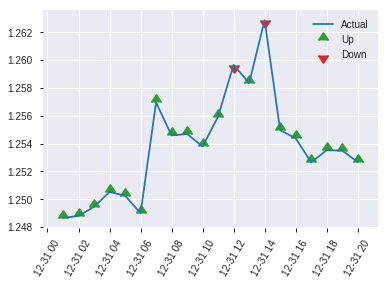


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2594942498496492
RMSE: 0.5094057811309656
LogLoss: 0.7145513037015092
Mean Per-Class Error: 0.4366186823578859
AUC: 0.571104339602816
pr_auc: 0.5609493420883225
Gini: 0.14220867920563207
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24773060497528573: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   270  0.8795   (270.0/307.0)
1      11   299  0.0355   (11.0/310.0)
Total  48   569  0.4554   (281.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.247731     0.680319  360
max f2                       0.17244      0.835587  392
max f0point5                 0.305584     0.580631  303
max accuracy                 0.44216      0.562399  126
max precision                0.744852     1         0
max recall                   0.0979923    1         399
max specificity              0.744852     1         0
max absolute_mcc             0.247731     0.158739  360
max min_per_class_accuracy   0.390499     0.534202  196
max mean_per_class_accuracy  0.44216      0.563381  126

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 38.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.640262           1.42166   1.42166            0.714286         0.669331  0.714286                    0.669331            0.016129        0.016129                   42.1659    42.1659
    2        0.0210697                   0.5936             1.32688   1.37792            0.666667         0.611918  0.692308                    0.642833            0.0129032       0.0290323                  32.6882    37.7916
    3        0.0307942                   0.574769           0.995161  1.25705            0.5              0.582339  0.631579                    0.623729            0.00967742      0.0387097                  -0.483871  25.7046
    4        0.0405186                   0.566214           1.32688   1.27381            0.666667         0.571886  0.64                        0.611287            0.0129032       0.0516129                  32.6882    27.3806
    5        0.0502431                   0.556318           0.663441  1.15567            0.333333         0.560076  0.580645                    0.601375            0.00645161      0.0580645                  -33.6559   15.5671
    6        0.100486                    0.517652           1.02726   1.09147            0.516129         0.536307  0.548387                    0.568841            0.0516129       0.109677                   2.72633    9.14672
    7        0.150729                    0.495067           1.34828   1.17707            0.677419         0.503368  0.591398                    0.547017            0.0677419       0.177419                   34.8283    17.7072
    8        0.200972                    0.474039           1.21988   1.18777            0.612903         0.483331  0.596774                    0.531095            0.0612903       0.23871                    21.9875    18.7773
    9        0.299838                    0.441445           1.23987   1.20495            0.622951         0.457899  0.605405                    0.50696             0.122581        0.36129                    23.9873    20.4952
    10       0.400324                    0.416076           0.834651  1.112              0.419355         0.429393  0.558704                    0.48749             0.083871        0.445161                   -16.5349   11.2002
    11       0.50081                     0.390413           0.898855  1.06923            0.451613         0.401234  0.537217                    0.470183            0.0903226       0.535484                   -10.1145   6.92348
    12       0.599676                    0.365515           1.01148   1.05971            0.508197         0.377646  0.532432                    0.454927            0.1             0.635484                   1.14754    5.97123
    13       0.700162                    0.333865           1.02726   1.05506            0.516129         0.351426  0.530093                    0.440073            0.103226        0.73871                    2.72633    5.50553
    14       0.799028                    0.305348           1.17462   1.06985            0.590164         0.318779  0.537525                    0.425065            0.116129        0.854839                   17.4617    6.98489
    15       0.899514                    0.261045           0.866753  1.04716            0.435484         0.285188  0.526126                    0.409439            0.0870968       0.941935                   -13.3247   4.71607
    16       1                           0.0979923          0.577836  1                  0.290323         0.212891  0.502431                    

This function is available for GLM models only


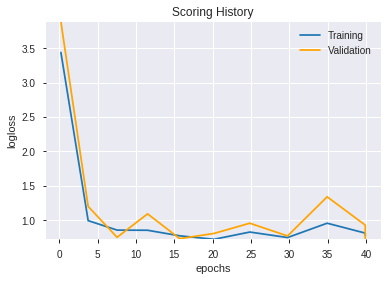

--2019-08-24 17:01:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  13.8MB/s    in 27s     

2019-08-24 17:01:59 (12.8 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_160342_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_160342_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_170218_model_3  0.550399  0.745377              0.478749  0.513049  0.263220
1  DeepLearning_grid_1_AutoML_20190824_170218_model_1  0.547000  0.978064              0.496711  0.544886  0.296901
2  DeepLearning_grid_1_AutoML_20190824_170218_model_5  0.546060  0.693001              0.498371  0.499847  0.249847
3  DeepLearning_grid_1_AutoML_20190824_170218_model_6  0.531386  0.712189              0.493485  0.508717  0.258793
4  DeepLearning_grid_1_AutoML_20190824_170218_model_9  0.528696  0.693315              0.491809  0.500086  0.250086
5               DeepLearning_1_AutoML_20190824_170218  0.522297  0.724720              0.498356  0.514234  0.264436
6  DeepLearning_grid_1_AutoML_20190824_170218_model_8  0.519539  0.695707              0.493454  0.501234  0.251235
7  DeepLearning_grid_1_AutoML_20190824_170218_model_7  0.519470  0.772521              0.488568  0.530438  0.281365
8  DeepLearning_grid_1_AutoML_20190824_170218_model_2  0.513271  0.869660              0.473831  0.557781  0.311119
9  DeepLearning_grid_1_AutoML_20190824_170218_model_4  0.511900  0.735228              0.498371  0.516757  0.267037

variable  relative_importance  scaled_importance  percentage
0    CDLIDENTICAL3CROWS             1.000000           1.000000    0.032381
1      is_quarter_start             0.974413           0.974413    0.031552
2          CDLTHRUSTING             0.946630           0.946630    0.030653
3        CDLEVENINGSTAR             0.945868           0.945868    0.030628
4    CDLMORNINGDOJISTAR             0.916156           0.916156    0.029666
5   CDLGAPSIDESIDEWHITE             0.898449           0.898449    0.029093
6     CDLSTALLEDPATTERN             0.884577           0.884577    0.028643
7        CDLMORNINGSTAR             0.878513           0.878513    0.028447
8                SAREXT             0.864909           0.864909    0.028007
9       CDLHOMINGPIGEON             0.852104           0.852104    0.027592
10   CDLEVENINGDOJISTAR             0.851692           0.851692    0.027579
11       is_month_start             0.847236           0.847236    0.027434
12            CDLONNECK             0.811305           0.811305    0.026271
13    CDLDARKCLOUDCOVER             0.772981           0.772981    0.025030
14            CDLINNECK             0.762600           0.762600    0.024694
15          CDLPIERCING             0.755365           0.755365    0.024459
16    CDLINVERTEDHAMMER             0.741295           0.741295    0.024004
17         HT_TRENDMODE             0.737063           0.737063    0.023867
18        days_in_month             0.727093           0.727093    0.023544
19            CORREL_30             0.725710           0.725710    0.023499
20         is_month_end             0.716074           0.716074    0.023187
21  CDLRISEFALL3METHODS             0.705487           0.705487    0.022844
22       CDL3LINESTRIKE             0.704105           0.704105    0.022800
23             CORREL_8             0.695252           0.695252    0.022513
24      CDLSHOOTINGSTAR             0.683333           0.683333    0.022127
25        CDLHIKKAKEMOD             0.677437           0.677437    0.021936
26       CDL3BLACKCROWS             0.625504           0.625504    0.020254
27      CDLADVANCEBLOCK             0.621675           0.621675    0.020130
28      CDLUNIQUE3RIVER             0.612435           0.612435    0.019831
29           CDL3INSIDE             0.535051           0.535051    0.017325
30        CDLHANGINGMAN             0.512596           0.512596    0.016598
31                 hour             0.470223           0.470223    0.015226
32       STOCHRSI_fastk             0.466318           0.466318    0.015100
33            CORREL_24             0.455463           0.455463    0.014748
34            dayofyear             0.450732           0.450732    0.014595
35       CDLMATCHINGLOW             0.450143           0.450143    0.014576
36                  BOP             0.440512           0.440512    0.014264
37         CDLTASUKIGAP             0.414741           0.414741    0.013430
38                  day             0.396151           0.396151    0.012828
39         STOCHF_fastk             0.372279           0.372279    0.012055
40    CDLGRAVESTONEDOJI             0.364264           0.364264    0.011795
41            CDLHAMMER             0.359924           0.359924    0.011655
42            CDLTAKURI             0.347768           0.347768    0.011261
43     CDLDRAGONFLYDOJI             0.318742           0.318742    0.010321
44            CORREL_12             0.294360           0.294360    0.009532
45            CORREL_14             0.288275           0.288275    0.009335
46            CORREL_20             0.275183           0.275183    0.008911
47       CDLRICKSHAWMAN             0.267580           0.267580    0.008664
48    CDLLONGLEGGEDDOJI             0.241100           0.241100    0.007807
49              CDLDOJI             0.225715           0.225715    0.007309

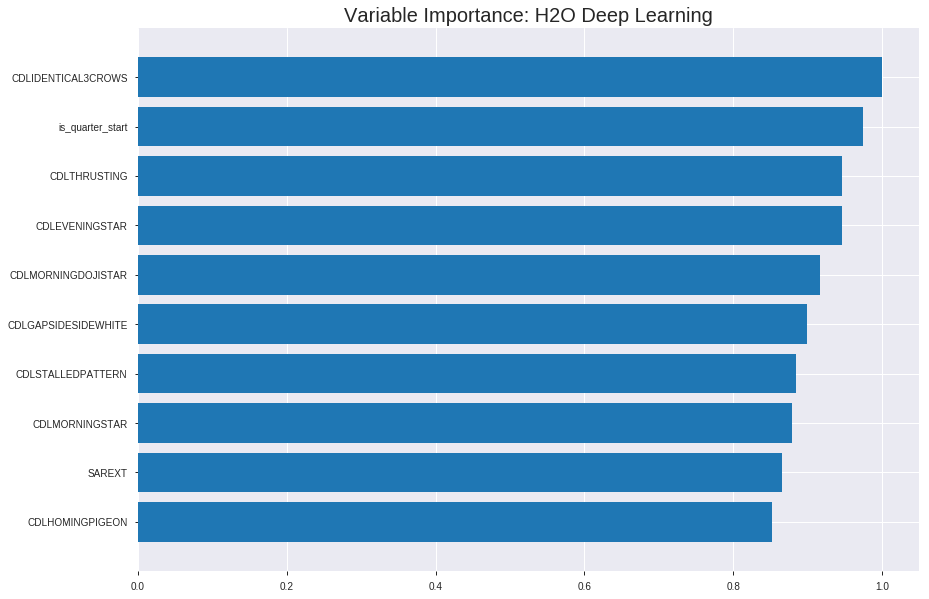

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_170218_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25249126042806286
RMSE: 0.5024850847816906
LogLoss: 0.7091522567128414
Mean Per-Class Error: 0.44728017995931135
AUC: 0.5737325642911522
pr_auc: 0.5689849830436978
Gini: 0.14746512858230432
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2272459310439837: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      66   2067  0.9691   (2067.0/2133.0)
1      28   2152  0.0128   (28.0/2180.0)
Total  94   4219  0.4857   (2095.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.227246     0.672605  358
max f2                       0.0109064    0.836467  397
max f0point5                 0.39121      0.574184  277
max accuracy                 0.455041     0.553675  232
max precision                0.999338     0.8       0
max recall                   0.0109064    1         397
max specificity              0.999338     0.999531  0
max absolute_mcc             0.425935     0.109659  253
max min_per_class_accuracy   0.486479     0.546789  208
max mean_per_class_accuracy  0.455041     0.55272   232

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 49.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.959894           1.21404   1.21404            0.613636         0.981477  0.613636                    0.981477            0.0123853       0.0123853                  21.4043    21.4043
    2        0.0201716                   0.899139           1.51834   1.36444            0.767442         0.92957   0.689655                    0.955822            0.0151376       0.0275229                  51.8338    36.4442
    3        0.0301414                   0.828024           1.28829   1.33925            0.651163         0.86078   0.676923                    0.924385            0.012844        0.040367                   28.8287    33.9252
    4        0.0401113                   0.784504           1.28829   1.32658            0.651163         0.804796  0.67052                     0.894661            0.012844        0.053211                   28.8287    32.6584
    5        0.0500812                   0.755437           1.01223   1.264              0.511628         0.769093  0.638889                    0.869663            0.0100917       0.0633028                  1.22253    26.4004
    6        0.100162                    0.678894           1.24568   1.25484            0.62963          0.712469  0.634259                    0.791066            0.0623853       0.125688                   24.5685    25.4844
    7        0.150012                    0.635849           1.17786   1.22926            0.595349         0.655032  0.621329                    0.745861            0.0587156       0.184404                   17.7862    22.9263
    8        0.200093                    0.609565           1.09913   1.19669            0.555556         0.621955  0.604867                    0.714849            0.0550459       0.23945                    9.91335    19.6693
    9        0.300023                    0.566565           1.02824   1.14058            0.519722         0.588802  0.576507                    0.672866            0.102752        0.342202                   2.82381    14.0585
    10       0.399954                    0.523935           1.01447   1.10907            0.512761         0.545353  0.56058                     0.641006            0.101376        0.443578                   1.44671    10.9074
    11       0.500116                    0.485569           1.0396    1.09516            0.525463         0.504195  0.553547                    0.613606            0.104128        0.547706                   3.95971    9.51589
    12       0.600046                    0.450619           1.00988   1.08096            0.510441         0.467091  0.546368                    0.589205            0.100917        0.648624                   0.987675   8.09562
    13       0.699977                    0.418092           1.0007    1.0695             0.5058           0.433625  0.540576                    0.566994            0.1             0.748624                   0.0696056  6.94981
    14       0.799907                    0.378591           0.895118  1.04771            0.452436         0.398296  0.529565                    0.545919            0.0894495       0.838073                   -10.4882   4.77132
    15       0.899838                    0.335426           0.844624  1.02516            0.426914         0.358281  0.518165                    0.525081            0.0844037       0.922477                   -15.5376   2.51594
    16       1                           0.00156648         0.773973  1                  0.391204         0.265942  0.505449                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2746593904406347
RMSE: 0.5240795649905029
LogLoss: 0.7917348756233291
Mean Per-Class Error: 0.477977195945946
AUC: 0.5206925675675675
pr_auc: 0.5308055017133234
Gini: 0.04138513513513509
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.005562773444720554: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    592   1        (592.0/592.0)
1      0    640   0        (0.0/640.0)
Total  0    1232  0.4805   (592.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00556277   0.683761   399
max f2                       0.00556277   0.843882   399
max f0point5                 0.33223      0.576324   345
max accuracy                 0.37468      0.531656   314
max precision                0.995224     0.8        1
max recall                   0.00556277   1          399
max specificity              0.997999     0.998311   0
max absolute_mcc             0.372236     0.0501361  316
max min_per_class_accuracy   0.503585     0.5125     211
max mean_per_class_accuracy  0.411503     0.522023   283

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 52.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.988913           1.18462   1.18462            0.615385         0.993195  0.615385                    0.993195            0.0125          0.0125                     18.4615   18.4615
    2        0.0202922                   0.977131           0.802083  1.001              0.416667         0.984427  0.52                        0.988986            0.0078125       0.0203125                  -19.7917  0.1
    3        0.0300325                   0.963111           0.9625    0.988514           0.5              0.971027  0.513514                    0.983162            0.009375        0.0296875                  -3.75     -1.14865
    4        0.0405844                   0.934097           0.296154  0.8085             0.153846         0.948922  0.42                        0.974259            0.003125        0.0328125                  -70.3846  -19.15
    5        0.0503247                   0.882517           0.802083  0.807258           0.416667         0.910075  0.419355                    0.961836            0.0078125       0.040625                   -19.7917  -19.2742
    6        0.100649                    0.752183           1.24194   1.0246             0.645161         0.8049    0.532258                    0.883368            0.0625          0.103125                   24.1935   2.45968
    7        0.150162                    0.677266           1.23074   1.09257            0.639344         0.712646  0.567568                    0.827076            0.0609375       0.164062                   23.0738   9.25676
    8        0.200487                    0.632835           0.931452  1.05213            0.483871         0.652114  0.546559                    0.783159            0.046875        0.210938                   -6.85484  5.21255
    9        0.300325                    0.589079           1.00163   1.03534            0.520325         0.61052   0.537838                    0.725768            0.1             0.310937                   0.162602  3.53378
    10       0.400162                    0.543511           1.04858   1.03864            0.544715         0.566604  0.539554                    0.686058            0.104688        0.415625                   4.85772   3.8641
    11       0.5                         0.502594           0.985976  1.02812            0.512195         0.524134  0.534091                    0.653725            0.0984375       0.514062                   -1.40244  2.8125
    12       0.599838                    0.464658           0.923374  1.01069            0.479675         0.482379  0.525034                    0.625206            0.0921875       0.60625                    -7.6626   1.06901
    13       0.699675                    0.421607           1.06423   1.01833            0.552846         0.443832  0.529002                    0.599326            0.10625         0.7125                     6.42276   1.83295
    14       0.799513                    0.386653           1.00163   1.01624            0.520325         0.403062  0.527919                    0.574818            0.1             0.8125                     0.162602  1.62437
    15       0.899351                    0.336981           0.970325  1.01115            0.504065         0.363393  0.525271                    0.551347            0.096875        0.909375                   -2.96748  1.11462
    16       1                           0.00487601         0.900403  1                  0.467742         0.280083  0.519481                    0.524045            0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:04:04  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:04:07  1 min 48.176 sec  6607 obs/sec      4.79643   1             20687      0.529998         0.875806            -0.123726      0.56209         0.551189           1.34894          0.494551                         0.546962           1.00065               -0.198491        0.53009           0.537902             1.33269            0.480519
    2019-08-24 17:04:14  1 min 54.893 sec  8565 obs/sec      19.1574   4             82626      0.509125         0.741007            -0.0369545     0.574496        0.566537           1.30397          0.488755                         0.532519           0.842743              -0.136032        0.52481           0.530942             1.03654            0.480519
    2019-08-24 17:04:19  2 min  0.388 sec  9699 obs/sec      33.5514   7             144707     0.502485         0.709152            -0.010085      0.573733        0.568985           1.21404          0.485741                         0.52408            0.791735              -0.100308        0.520693          0.530806             1.18462            0.480519
    2019-08-24 17:04:26  2 min  7.092 sec  10675 obs/sec     52.7327   11            227436     0.506401         0.733518            -0.0258887     0.566283        0.554046           1.48383          0.489914                         0.525109           0.860912              -0.104635        0.521457          0.519605             1.48077            0.478896
    2019-08-24 17:04:31  2 min 12.192 sec  11042 obs/sec     67.1027   14            289414     0.50167          0.728866            -0.00680937    0.584971        0.571749           1.43887          0.487132                         0.527025           0.939407              -0.112712        0.515114          0.514416             1.33269            0.480519
    2019-08-24 17:04:37  2 min 18.019 sec  11707 obs/sec     86.3086   18            372249     0.497694         0.699035            0.00908362     0.588019        0.586014           1.52879          0.480872                         0.520684           0.814967              -0.0860968       0.51814           0.523155             1.33269            0.480519
    2019-08-24 17:04:43  2 min 23.563 sec  12246 obs/sec     105.483   22            454950     0.492703         0.684006            0.028858       0.607031        0.599432           1.57376          0.459773                         0.519283           0.800797              -0.0802579       0.514788          0.52187              1.18462            0.480519
    2019-08-24 17:04:43  2 min 23.778 sec  12244 obs/sec     105.483   22            454950     0.502485         0.709152            -0.010085      0.573733        0.568985           1.21404          0.485741                         0.52408            0.791735              -0.100308        0.520693          0.530806             1.18462            0.480519

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ---------------------
CDLIDENTICAL3CROWS  1.0                    1.0                  0.03238092376561218
is_quarter_start    0.9744126796722412     0.9744126796722412   0.03155238269671272
CDLTHRUSTING        0.9466304779052734     0.9466304779052734   0.03065276933925568
CDLEVENINGSTAR      0.9458680748939514     0.9458680748939514   0.03062808202546739
CDLMORNINGDOJISTAR  0.9161558151245117     0.9161558151245117   0.029665971606969096
---                 ---                    ---                  ---
CORREL_14           0.28827473521232605    0.28827473521232605  0.009334602224462366
CORREL_20           0.2751830816268921     0.2751830816268921   0.008910682387746624
CDLRICKSHAWMAN      0.26757997274398804    0.26757997274398804  0.00866448669862766
CDLLONGLEGGEDDOJI   0.24110017716884613    0.24110017716884613  0.0078070464567799955
CDLDOJI             0.22571542859077454    0.22571542859077454  0.007308874085920349


See the whole table with table.as_data_frame()


('accuracy', 0.5526742301458671)

('F1', 0.6747787610619469)

('auc', 0.5503992854891248)

('logloss', 0.7453768548136421)

('mean_per_class_error', 0.44755700325732906)

('rmse', 0.5130493017136731)

('mse', 0.2632195859888876)

deeplearning prediction progress: |███████████████████████████████████████| 100%



ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2632195859888876
RMSE: 0.5130493017136731
LogLoss: 0.7453768548136421
Mean Per-Class Error: 0.44755700325732906
AUC: 0.5503992854891248
pr_auc: 0.5265715157675812
Gini: 0.10079857097824951
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31058361729369705: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   289  0.9414   (289.0/307.0)
1      5    305  0.0161   (5.0/310.0)
Total  23   594  0.4765   (294.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.310584     0.674779  378
max f2                       0.0855651    0.83603   396
max f0point5                 0.310584     0.567759  378
max accuracy                 0.484699     0.552674  227
max precision                0.593981     0.579882  131
max recall                   0.0855651    1         396
max specificity              0.995869     0.996743  0
max absolute_mcc             0.310584     0.112179  378
max min_per_class_accuracy   0.500963     0.534202  213
max mean_per_class_accuracy  0.484699     0.552443  227

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 51.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.972925           0.852995  0.852995           0.428571         0.983827  0.428571                    0.983827            0.00967742      0.00967742                 -14.7005   -14.7005
    2        0.0210697                   0.934913           0.995161  0.91861            0.5              0.956022  0.461538                    0.970994            0.00967742      0.0193548                  -0.483871  -8.13896
    3        0.0307942                   0.90691            0.995161  0.942784           0.5              0.923818  0.473684                    0.956096            0.00967742      0.0290323                  -0.483871  -5.72156
    4        0.0405186                   0.863154           0.663441  0.875742           0.333333         0.872408  0.44                        0.936011            0.00645161      0.0354839                  -33.6559   -12.4258
    5        0.0502431                   0.813432           0.663441  0.834651           0.333333         0.844599  0.419355                    0.918318            0.00645161      0.0419355                  -33.6559   -16.5349
    6        0.100486                    0.709944           1.34828   1.09147            0.677419         0.754892  0.548387                    0.836605            0.0677419       0.109677                   34.8283    9.14672
    7        0.150729                    0.650683           0.963059  1.04866            0.483871         0.678928  0.526882                    0.784046            0.0483871       0.158065                   -3.69407   4.86646
    8        0.200972                    0.624707           1.28408   1.10752            0.645161         0.638402  0.556452                    0.747635            0.0645161       0.222581                   28.4079    10.7518
    9        0.299838                    0.580097           1.17462   1.12964            0.590164         0.603296  0.567568                    0.700042            0.116129        0.33871                    17.4617    12.9643
    10       0.400324                    0.537423           0.963059  1.08783            0.483871         0.559359  0.546559                    0.664729            0.0967742       0.435484                   -3.69407   8.78281
    11       0.50081                     0.500963           0.995161  1.06923            0.5              0.518839  0.537217                    0.635457            0.1             0.535484                   -0.483871  6.92348
    12       0.599676                    0.461095           1.01148   1.05971            0.508197         0.482287  0.532432                    0.610204            0.1             0.635484                   1.14754    5.97123
    13       0.700162                    0.431344           0.930957  1.04123            0.467742         0.44623   0.523148                    0.586671            0.0935484       0.729032                   -6.90427   4.12336
    14       0.799028                    0.384246           1.01148   1.03755            0.508197         0.409737  0.521298                    0.564778            0.1             0.829032                   1.14754    3.75515
    15       0.899514                    0.34206            0.898855  1.02206            0.451613         0.364653  0.513514                    0.542422            0.0903226       0.919355                   -10.1145   2.20575
    16       1                           0.00878009         0.802549  1                  0.403226         0.287784  0.502431               

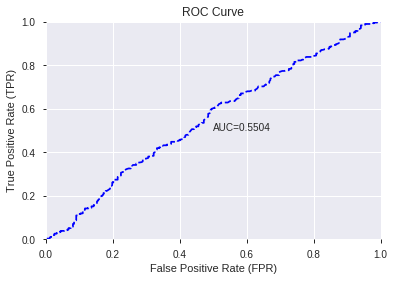

This function is available for GLM models only


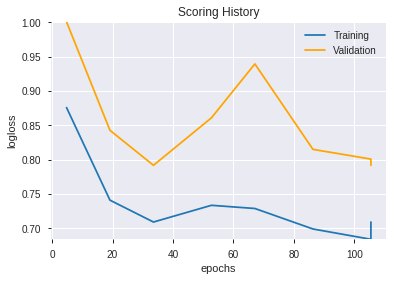

--2019-08-24 17:21:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.66.40
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.66.40|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_170218_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_170218_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLIDENTICAL3CROWS',
 'is_quarter_start',
 'CDLTHRUSTING',
 'CDLEVENINGSTAR',
 'CDLMORNINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGSTAR',
 'SAREXT',
 'CDLHOMINGPIGEON',
 'CDLEVENINGDOJISTAR',
 'is_month_start',
 'CDLONNECK',
 'CDLDARKCLOUDCOVER',
 'CDLINNECK',
 'CDLPIERCING',
 'CDLINVERTEDHAMMER',
 'HT_TRENDMODE',
 'days_in_month',
 'CORREL_30',
 'is_month_end',
 'CDLRISEFALL3METHODS',
 'CDL3LINESTRIKE',
 'CORREL_8',
 'CDLSHOOTINGSTAR',
 'CDLHIKKAKEMOD',
 'CDL3BLACKCROWS',
 'CDLADVANCEBLOCK',
 'CDLUNIQUE3RIVER',
 'CDL3INSIDE',
 'CDLHANGINGMAN',
 'hour',
 'STOCHRSI_fastk',
 'CORREL_24',
 'dayofyear',
 'CDLMATCHINGLOW',
 'BOP',
 'CDLTASUKIGAP',
 'day',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CORREL_12',
 'CORREL_14',
 'CORREL_20',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'CDLDOJI']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_172153_model_1  0.530566  0.692112              0.491825  0.499482  0.249483

variable  relative_importance  scaled_importance  percentage
0          STOCHF_fastk             0.019730           1.000000    0.100281
1                   BOP             0.018001           0.912367    0.091493
2        STOCHRSI_fastk             0.015494           0.785301    0.078751
3         CDLHANGINGMAN             0.009681           0.490700    0.049208
4                SAREXT             0.006874           0.348404    0.034938
5          is_month_end             0.006585           0.333744    0.033468
6       CDLHOMINGPIGEON             0.006070           0.307637    0.030850
7      is_quarter_start             0.005963           0.302243    0.030309
8        CDLMATCHINGLOW             0.005880           0.298002    0.029884
9             CORREL_12             0.005525           0.280040    0.028083
10       CDLEVENINGSTAR             0.005396           0.273478    0.027425
11            dayofyear             0.005209           0.264026    0.026477
12   CDLIDENTICAL3CROWS             0.004914           0.249083    0.024978
13            CDLINNECK             0.004820           0.244294    0.024498
14   CDLMORNINGDOJISTAR             0.004384           0.222203    0.022283
15       CDLMORNINGSTAR             0.004177           0.211702    0.021230
16       CDL3LINESTRIKE             0.004007           0.203077    0.020365
17       CDL3BLACKCROWS             0.003928           0.199079    0.019964
18         CDLTHRUSTING             0.003887           0.197026    0.019758
19       CDLRICKSHAWMAN             0.003885           0.196888    0.019744
20      CDLUNIQUE3RIVER             0.003720           0.188543    0.018907
21         HT_TRENDMODE             0.003681           0.186592    0.018712
22           CDL3INSIDE             0.003675           0.186248    0.018677
23            CORREL_14             0.003509           0.177877    0.017838
24     CDLDRAGONFLYDOJI             0.003399           0.172287    0.017277
25       is_month_start             0.002746           0.139194    0.013959
26    CDLGRAVESTONEDOJI             0.002544           0.128950    0.012931
27      CDLADVANCEBLOCK             0.002437           0.123493    0.012384
28                 hour             0.002405           0.121885    0.012223
29            CDLTAKURI             0.002300           0.116595    0.011692
30         CDLTASUKIGAP             0.002094           0.106118    0.010642
31            CORREL_30             0.002082           0.105538    0.010583
32            CORREL_24             0.001867           0.094636    0.009490
33        days_in_month             0.001667           0.084474    0.008471
34    CDLSTALLEDPATTERN             0.001626           0.082428    0.008266
35            CDLONNECK             0.001616           0.081929    0.008216
36        CDLHIKKAKEMOD             0.001511           0.076594    0.007681
37    CDLLONGLEGGEDDOJI             0.001365           0.069169    0.006936
38  CDLGAPSIDESIDEWHITE             0.001341           0.067945    0.006814
39   CDLEVENINGDOJISTAR             0.001310           0.066417    0.006660
40              CDLDOJI             0.001195           0.060565    0.006074
41                  day             0.000853           0.043221    0.004334
42             CORREL_8             0.000746           0.037797    0.003790
43            CDLHAMMER             0.000704           0.035679    0.003578
44    CDLINVERTEDHAMMER             0.000548           0.027766    0.002784
45            CORREL_20             0.000540           0.027355    0.002743
46      CDLSHOOTINGSTAR             0.000533           0.027008    0.002708
47  CDLRISEFALL3METHODS             0.000269           0.013614    0.001365
48          CDLPIERCING             0.000054           0.002756    0.000276
49    CDLDARKCLOUDCOVER             0.000000           0.000000    0.000000

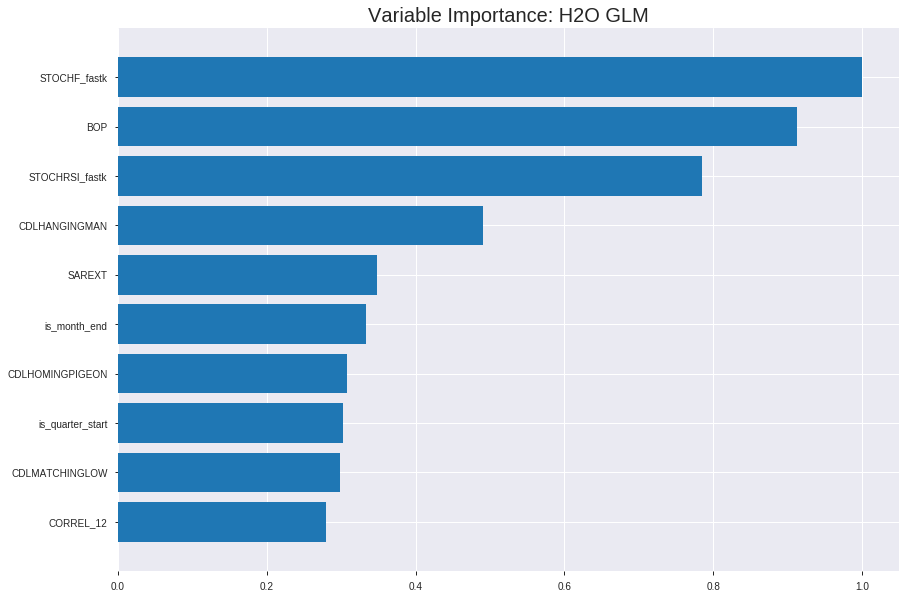

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_172153_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24824815400165867
RMSE: 0.4982450742372258
LogLoss: 0.6896398795233379
Null degrees of freedom: 4312
Residual degrees of freedom: 4263
Null deviance: 5978.575396871039
Residual deviance: 5948.833600768314
AIC: 6048.833600768314
AUC: 0.5739502015079765
pr_auc: 0.5759426371540106
Gini: 0.14790040301595297
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4757516695141109: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      38   2095  0.9822   (2095.0/2133.0)
1      13   2167  0.006    (13.0/2180.0)
Total  51   4262  0.4888   (2108.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475752     0.672772  372
max f2                       0.445263     0.836531  396
max f0point5                 0.496096     0.573388  265
max accuracy                 0.500732     0.555298  233
max precision                0.544712     0.842105  14
max recall                   0.445263     1         396
max specificity              0.59316      0.999531  0
max absolute_mcc             0.508127     0.111973  178
max min_per_class_accuracy   0.505648     0.552752  196
max mean_per_class_accuracy  0.508127     0.555534  178

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 50.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.535979           1.66369   1.66369            0.840909         0.54724   0.840909                    0.54724             0.0169725       0.0169725                  66.3688    66.3688
    2        0.0201716                   0.530819           1.3343    1.50089            0.674419         0.532895  0.758621                    0.54015             0.0133028       0.0302752                  33.4297    50.0886
    3        0.0301414                   0.529028           1.38031   1.461              0.697674         0.529749  0.738462                    0.536709            0.0137615       0.0440367                  38.0307    46.1002
    4        0.0401113                   0.52761            1.42632   1.45238            0.72093          0.52821   0.734104                    0.534597            0.0142202       0.0582569                  42.6317    45.2381
    5        0.0500812                   0.526238           1.15026   1.39224            0.581395         0.526917  0.703704                    0.533068            0.0114679       0.0697248                  15.0256    39.2236
    6        0.100162                    0.5231             0.99838   1.19531            0.50463          0.524703  0.604167                    0.528886            0.05            0.119725                   -0.162037  19.5308
    7        0.150012                    0.520944           1.22387   1.2048             0.618605         0.522034  0.608964                    0.526609            0.0610092       0.180734                   22.3872    20.48
    8        0.200093                    0.51874            1.07166   1.17148            0.541667         0.519791  0.592121                    0.524903            0.0536697       0.234404                   7.16552    17.1475
    9        0.300023                    0.514433           1.07873   1.14058            0.545244         0.51658   0.576507                    0.522131            0.107798        0.342202                   7.8732     14.0585
    10       0.399954                    0.5096             1.05578   1.1194             0.533643         0.512001  0.565797                    0.5196              0.105505        0.447706                   5.57802    11.9396
    11       0.500116                    0.505557           1.05334   1.10617            0.532407         0.5075    0.55911                     0.517176            0.105505        0.553211                   5.33363    10.6166
    12       0.600046                    0.50126            0.968564  1.08325            0.489559         0.503387  0.547527                    0.51488             0.096789        0.65                       -3.14364   8.32496
    13       0.699977                    0.497021           0.986925  1.0695             0.49884          0.499101  0.540576                    0.512627            0.0986239       0.748624                   -1.3075    6.94981
    14       0.799907                    0.491873           0.867576  1.04427            0.438515         0.494465  0.527826                    0.510358            0.0866972       0.835321                   -13.2424   4.42724
    15       0.899838                    0.487116           0.840034  1.02159            0.424594         0.489492  0.516362                    0.508041            0.083945        0.919266                   -15.9966   2.1591
    16       1                           0.438968           0.806031  1                  0.407407         0.48216   0.505449                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24950781556146337
RMSE: 0.49950757307718907
LogLoss: 0.692160985381338
Null degrees of freedom: 1231
Residual degrees of freedom: 1182
Null deviance: 1707.0147816677918
Residual deviance: 1705.484667979617
AIC: 1805.484667979617
AUC: 0.5231748838682432
pr_auc: 0.5418460924523845
Gini: 0.04634976773648636
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4672010295686039: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    586   0.9899   (586.0/592.0)
1      3    637   0.0047   (3.0/640.0)
Total  9    1223  0.4781   (589.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.467201     0.683843   391
max f2                       0.439921     0.843882   399
max f0point5                 0.482547     0.579738   349
max accuracy                 0.482612     0.534091   348
max precision                0.585557     1          0
max recall                   0.439921     1          399
max specificity              0.585557     1          0
max absolute_mcc             0.482547     0.0662827  349
max min_per_class_accuracy   0.502799     0.509375   209
max mean_per_class_accuracy  0.517845     0.523079   96

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.553722           1.33269   1.33269            0.692308         0.561192  0.692308                    0.561192            0.0140625       0.0140625                  33.2692   33.2692
    2        0.0202922                   0.544368           0.9625    1.155              0.5              0.548951  0.6                         0.555316            0.009375        0.0234375                  -3.75     15.5
    3        0.0300325                   0.536463           0.48125   0.936486           0.25             0.541663  0.486486                    0.550888            0.0046875       0.028125                   -51.875   -6.35135
    4        0.0405844                   0.52941            1.33269   1.0395             0.692308         0.531899  0.54                        0.545951            0.0140625       0.0421875                  33.2692   3.95
    5        0.0503247                   0.525977           1.12292   1.05565            0.583333         0.52716   0.548387                    0.542314            0.0109375       0.053125                   12.2917   5.56452
    6        0.100649                    0.522056           1.14879   1.10222            0.596774         0.523537  0.572581                    0.532926            0.0578125       0.110937                   14.879    10.2218
    7        0.150162                    0.519178           1.13607   1.11338            0.590164         0.520629  0.578378                    0.528871            0.05625         0.167187                   13.6066   11.3378
    8        0.200487                    0.516557           1.08669   1.10668            0.564516         0.51793   0.574899                    0.526125            0.0546875       0.221875                   8.66935   10.668
    9        0.300325                    0.511955           0.892073  1.03534            0.463415         0.514283  0.537838                    0.522188            0.0890625       0.310937                   -10.7927  3.53378
    10       0.400162                    0.507702           1.04858   1.03864            0.544715         0.509844  0.539554                    0.519108            0.104688        0.415625                   4.85772   3.8641
    11       0.5                         0.502763           0.939024  1.01875            0.487805         0.505027  0.529221                    0.516297            0.09375         0.509375                   -6.09756  1.875
    12       0.599838                    0.498511           1.01728   1.0185             0.528455         0.500815  0.529093                    0.51372             0.101562        0.610938                   1.72764   1.85047
    13       0.699675                    0.493723           1.03293   1.02056            0.536585         0.496142  0.530162                    0.511212            0.103125        0.714063                   3.29268   2.05626
    14       0.799513                    0.488709           0.954675  1.01234            0.495935         0.491091  0.525888                    0.508699            0.0953125       0.809375                   -4.53252  1.2335
    15       0.899351                    0.483428           0.985976  1.00941            0.512195         0.486186  0.524368                    0.5062              0.0984375       0.907813                   -1.40244  0.940884
    16       1                           0.439921           0.915927  1                  0.475806         0.478255  0.519481                    0.503387            0.0921


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:21:54  0.000 sec   2            4.9       49            1.38291           1.38468
    2019-08-24 17:21:54  0.036 sec   4            3         49            1.38135           1.38443
    2019-08-24 17:21:54  0.071 sec   6            1.9       50            1.37928           1.38432
    2019-08-24 17:21:54  0.112 sec   8            1.2       51            1.37678           1.38462
    2019-08-24 17:21:54  0.152 sec   10           0.73      51            1.37402           1.3857
    2019-08-24 17:21:54  0.191 sec   12           0.45      51            1.37127           1.38796
    2019-08-24 17:21:54  0.232 sec   14           0.28      51            1.36874           1.39162
    2019-08-24 17:21:54  0.266 sec   16           0.17      51            1.3666            1.3966

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5348460291734197)

('F1', 0.6710239651416122)

('auc', 0.5305663549437848)

('logloss', 0.6921120126430627)

('mean_per_class_error', 0.4655511190501209)

('rmse', 0.4994823402412882)

('mse', 0.24948260821291396)

glm prediction progress: |████████████████████████████████████████████████| 100%


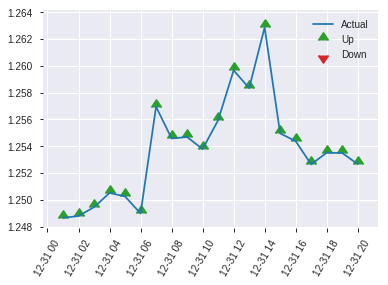


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24948260821291396
RMSE: 0.4994823402412882
LogLoss: 0.6921120126430627
Null degrees of freedom: 616
Residual degrees of freedom: 567
Null deviance: 855.3515081364842
Residual deviance: 854.0662236015394
AIC: 954.0662236015394
AUC: 0.5305663549437848
pr_auc: 0.5322082602968835
Gini: 0.06113270988756958
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4766101901592146: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    300  0.9772   (300.0/307.0)
1      2    308  0.0065   (2.0/310.0)
Total  9    608  0.4895   (302.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.47661      0.671024   390
max f2                       0.469386     0.835129   398
max f0point5                 0.47661      0.561634   390
max accuracy                 0.49983      0.534846   224
max precision                0.557394     1          0
max recall                   0.469386     1          398
max specificity              0.557394     1          0
max absolute_mcc             0.521713     0.0832979  31
max min_per_class_accuracy   0.503167     0.525806   193
max mean_per_class_accuracy  0.49983      0.534449   224

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.533835           0.852995  0.852995           0.428571         0.543491  0.428571                    0.543491            0.00967742      0.00967742                 -14.7005   -14.7005
    2        0.0210697                   0.528562           1.32688   1.07171            0.666667         0.53026   0.538462                    0.537384            0.0129032       0.0225806                  32.6882    7.17122
    3        0.0307942                   0.524038           1.6586    1.25705            0.833333         0.525371  0.631579                    0.533591            0.016129        0.0387097                  65.8602    25.7046
    4        0.0405186                   0.52359            0.995161  1.19419            0.5              0.523844  0.6                         0.531252            0.00967742      0.0483871                  -0.483871  19.4194
    5        0.0502431                   0.522794           1.32688   1.21988            0.666667         0.523089  0.612903                    0.529672            0.0129032       0.0612903                  32.6882    21.9875
    6        0.100486                    0.520116           1.02726   1.12357            0.516129         0.521297  0.564516                    0.525484            0.0516129       0.112903                   2.72633    12.3569
    7        0.150729                    0.517278           1.02726   1.09147            0.516129         0.518568  0.548387                    0.523179            0.0516129       0.164516                   2.72633    9.14672
    8        0.200972                    0.515364           1.09147   1.09147            0.548387         0.516237  0.548387                    0.521443            0.0548387       0.219355                   9.14672    9.14672
    9        0.299838                    0.511577           1.0441    1.07585            0.52459          0.513501  0.540541                    0.518825            0.103226        0.322581                   4.41036    7.585
    10       0.400324                    0.507273           0.963059  1.04754            0.483871         0.509559  0.526316                    0.516499            0.0967742       0.419355                   -3.69407   4.75382
    11       0.50081                     0.502981           1.05937   1.04991            0.532258         0.50471   0.527508                    0.514133            0.106452        0.525806                   5.93652    4.99113
    12       0.599676                    0.498169           1.0441    1.04895            0.52459          0.500959  0.527027                    0.511961            0.103226        0.629032                   4.41036    4.89538
    13       0.700162                    0.493646           0.834651  1.0182             0.419355         0.49581   0.511574                    0.509643            0.083871        0.712903                   -16.5349   1.81974
    14       0.799028                    0.488495           0.913591  1.00525            0.459016         0.491017  0.505071                    0.507339            0.0903226       0.803226                   -8.64093   0.52542
    15       0.899514                    0.484035           0.802549  0.98261            0.403226         0.486396  0.493694                    0.504999            0.0806452       0.883871                   -19.7451   -1.73903
    16       1                           0.466222           1.15567   1                  0.580645         0.479854  0.502431                    

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


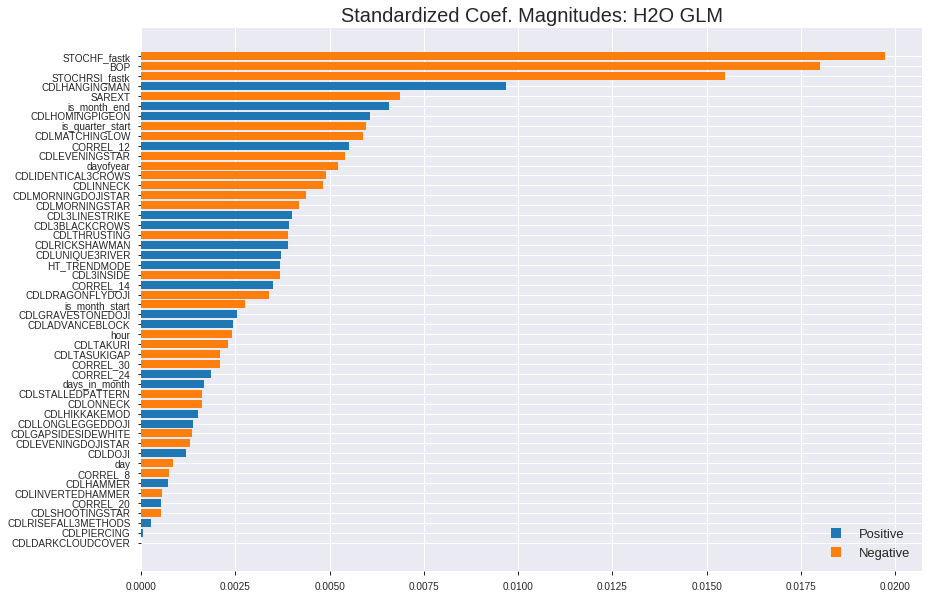

'log_likelihood'
--2019-08-24 17:22:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_172153_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_172153_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['STOCHF_fastk',
 'BOP',
 'STOCHRSI_fastk',
 'CDLHANGINGMAN',
 'SAREXT',
 'is_month_end',
 'CDLHOMINGPIGEON',
 'is_quarter_start',
 'CDLMATCHINGLOW',
 'CORREL_12',
 'CDLEVENINGSTAR',
 'dayofyear',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDL3LINESTRIKE',
 'CDL3BLACKCROWS',
 'CDLTHRUSTING',
 'CDLRICKSHAWMAN',
 'CDLUNIQUE3RIVER',
 'HT_TRENDMODE',
 'CDL3INSIDE',
 'CORREL_14',
 'CDLDRAGONFLYDOJI',
 'is_month_start',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'hour',
 'CDLTAKURI',
 'CDLTASUKIGAP',
 'CORREL_30',
 'CORREL_24',
 'days_in_month',
 'CDLSTALLEDPATTERN',
 'CDLONNECK',
 'CDLHIKKAKEMOD',
 'CDLLONGLEGGEDDOJI',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGDOJISTAR',
 'CDLDOJI',
 'day',
 'CORREL_8',
 'CDLHAMMER',
 'CDLINVERTEDHAMMER',
 'CORREL_20',
 'CDLSHOOTINGSTAR',
 'CDLRISEFALL3METHODS',
 'CDLPIERCING',
 'CDLDARKCLOUDCOVER']

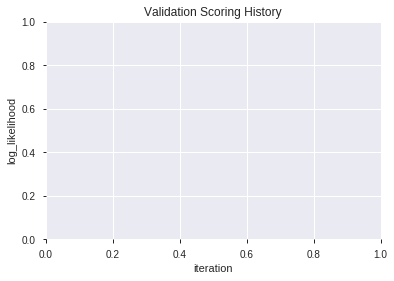

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_172213_model_4  0.565588  0.688669              0.490196  0.497755  0.247760
1  XGBoost_grid_1_AutoML_20190824_172213_model_2  0.564264  0.688358              0.491857  0.497601  0.247606
2               XGBoost_3_AutoML_20190824_172213  0.556289  0.693339              0.498371  0.500003  0.250003
3               XGBoost_2_AutoML_20190824_172213  0.554828  0.693751              0.493485  0.500094  0.250094
4  XGBoost_grid_1_AutoML_20190824_172213_model_3  0.551424  0.697317              0.485216  0.501822  0.251825
5  XGBoost_grid_1_AutoML_20190824_172213_model_6  0.550778  0.691563              0.490149  0.499157  0.249158
6               XGBoost_1_AutoML_20190824_172213  0.549133  0.695229              0.485326  0.500957  0.250958
7  XGBoost_grid_1_AutoML_20190824_172213_model_1  0.548345  0.692772              0.491857  0.499809  0.249810
8  XGBoost_grid_1_AutoML_20190824_172213_model_7  0.544930  0.695087              0.493485  0.500877  0.250878
9  XGBoost_grid_1_AutoML_20190824_172213_model_5  0.541899  0.708756              0.493470  0.506785  0.256831

variable  relative_importance  scaled_importance  percentage
0        STOCHF_fastk           632.626221           1.000000    0.183442
1                hour           527.251831           0.833433    0.152887
2                 BOP           416.263794           0.657993    0.120703
3           dayofyear           330.073212           0.521751    0.095711
4           CORREL_30           312.571564           0.494086    0.090636
5      STOCHRSI_fastk           289.377045           0.457422    0.083910
6              SAREXT           246.118439           0.389042    0.071367
7           CORREL_24           222.228668           0.351280    0.064439
8                 day           202.256317           0.319709    0.058648
9           CORREL_20           112.913765           0.178484    0.032741
10       HT_TRENDMODE            57.465302           0.090836    0.016663
11      days_in_month            32.521671           0.051407    0.009430
12          CORREL_14            24.078392           0.038061    0.006982
13          CORREL_12            18.687298           0.029539    0.005419
14       is_month_end             9.559405           0.015111    0.002772
15  CDLLONGLEGGEDDOJI             8.704619           0.013759    0.002524
16     CDLRICKSHAWMAN             5.950022           0.009405    0.001725

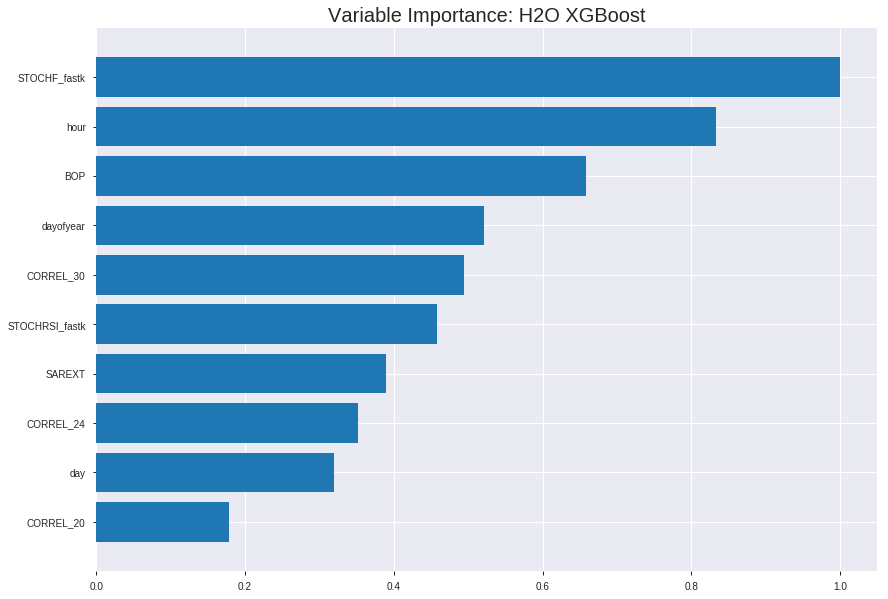

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_172213_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.23356670748754452
RMSE: 0.4832873963673629
LogLoss: 0.65980580082399
Mean Per-Class Error: 0.36432878703811233
AUC: 0.6822751476363136
pr_auc: 0.6832552810727569
Gini: 0.36455029527262717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4642929997709062: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      751   1382  0.6479   (1382.0/2133.0)
1      315   1865  0.1445   (315.0/2180.0)
Total  1066  3247  0.3935   (1697.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464293     0.687304  266
max f2                       0.349202     0.837821  382
max f0point5                 0.503914     0.639599  206
max accuracy                 0.503914     0.635752  206
max precision                0.710008     1         0
max recall                   0.341503     1         387
max specificity              0.710008     1         0
max absolute_mcc             0.503914     0.27137   206
max min_per_class_accuracy   0.504641     0.632911  205
max mean_per_class_accuracy  0.503914     0.635671  206

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.655247           1.84355   1.84355            0.931818         0.669959  0.931818                    0.669959            0.0188073       0.0188073                  84.3547   84.3547
    2        0.0201716                   0.639078           1.74839   1.79651            0.883721         0.645999  0.908046                    0.658117            0.0174312       0.0362385                  74.8389   79.6515
    3        0.0301414                   0.628087           1.47233   1.68928            0.744186         0.633716  0.853846                    0.650046            0.0146789       0.0509174                  47.2328   68.9284
    4        0.0401113                   0.621156           1.65637   1.6811             0.837209         0.624951  0.849711                    0.643809            0.0165138       0.0674312                  65.6369   68.1103
    5        0.0500812                   0.615025           1.61036   1.66702            0.813953         0.618244  0.842593                    0.638719            0.016055        0.0834862                  61.0358   66.7019
    6        0.100162                    0.593246           1.54795   1.60748            0.782407         0.603104  0.8125                      0.620911            0.0775229       0.161009                   54.7946   60.7483
    7        0.150012                    0.576269           1.26068   1.49224            0.637209         0.584313  0.75425                     0.60875             0.062844        0.223853                   26.0681   49.2239
    8        0.200093                    0.561131           1.19073   1.41677            0.601852         0.568136  0.716107                    0.598584            0.059633        0.283486                   19.0728   41.6774
    9        0.300023                    0.536961           1.3312    1.38827            0.672854         0.548477  0.7017                      0.581895            0.133028        0.416514                   33.1201   38.8272
    10       0.399954                    0.520134           1.07873   1.31093            0.545244         0.527866  0.662609                    0.568395            0.107798        0.524312                   7.8732    31.0932
    11       0.500116                    0.504811           1.08539   1.26576            0.548611         0.512352  0.639777                    0.557171            0.108716        0.633028                   8.53944   26.5762
    12       0.600046                    0.488478           0.913479  1.20709            0.461717         0.496359  0.610124                    0.547044            0.0912844       0.724312                   -8.65206  20.7093
    13       0.699977                    0.473747           0.853805  1.15666            0.431555         0.481032  0.584631                    0.53762             0.0853211       0.809633                   -14.6195  15.6657
    14       0.799907                    0.453573           0.757408  1.10678            0.382831         0.464239  0.55942                     0.528453            0.0756881       0.885321                   -24.2592  10.678
    15       0.899838                    0.422564           0.642649  1.05524            0.324826         0.440702  0.533368                    0.518708            0.0642202       0.949541                   -35.7351  5.52362
    16       1                           0.306066           0.50377   1                  0.25463          0.388972  0.505449                    0.505713          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25099235816163734
RMSE: 0.5009913753365793
LogLoss: 0.6952223173228133
Mean Per-Class Error: 0.4669763513513513
AUC: 0.5405590160472973
pr_auc: 0.5555924439536575
Gini: 0.08111803209459456
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34212809801101685: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      17   575   0.9713   (575.0/592.0)
1      7    633   0.0109   (7.0/640.0)
Total  24   1208  0.4724   (582.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.342128     0.685065   384
max f2                       0.299942     0.844327   397
max f0point5                 0.41498      0.580956   306
max accuracy                 0.422266     0.544643   294
max precision                0.612235     0.727273   17
max recall                   0.299942     1          397
max specificity              0.686529     0.998311   0
max absolute_mcc             0.422266     0.0824213  294
max min_per_class_accuracy   0.467053     0.520312   206
max mean_per_class_accuracy  0.422266     0.533024   294

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 47.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.622188           1.18462   1.18462            0.615385         0.640642  0.615385                    0.640642            0.0125          0.0125                     18.4615   18.4615
    2        0.0202922                   0.60831            1.60417   1.386              0.833333         0.616121  0.72                        0.628872            0.015625        0.028125                   60.4167   38.6
    3        0.0300325                   0.598033           0.9625    1.24865            0.5              0.60233   0.648649                    0.620263            0.009375        0.0375                     -3.75     24.8649
    4        0.0405844                   0.592549           1.33269   1.2705             0.692308         0.595128  0.66                        0.613728            0.0140625       0.0515625                  33.2692   27.05
    5        0.0503247                   0.586226           1.44375   1.30403            0.75             0.589078  0.677419                    0.608957            0.0140625       0.065625                   44.375    30.4032
    6        0.100649                    0.566043           0.9625    1.13327            0.5              0.575963  0.58871                     0.59246             0.0484375       0.114062                   -3.75     13.3266
    7        0.150162                    0.547412           0.946721  1.07176            0.491803         0.555341  0.556757                    0.580221            0.046875        0.160938                   -5.32787  7.17568
    8        0.200487                    0.530981           1.11774   1.0833             0.580645         0.538959  0.562753                    0.569864            0.05625         0.217188                   11.7742   8.32996
    9        0.300325                    0.505204           1.11118   1.09257            0.577236         0.517535  0.567568                    0.552468            0.110937        0.328125                   11.1179   9.25676
    10       0.400162                    0.486131           0.892073  1.04255            0.463415         0.49596   0.541582                    0.53837             0.0890625       0.417187                   -10.7927  4.25456
    11       0.5                         0.466731           1.03293   1.04063            0.536585         0.476533  0.540584                    0.526022            0.103125        0.520312                   3.29268   4.0625
    12       0.599838                    0.453256           1.06423   1.04455            0.552846         0.459527  0.542625                    0.514955            0.10625         0.626563                   6.42276   4.45535
    13       0.699675                    0.439672           0.876423  1.02056            0.455285         0.446558  0.530162                    0.505195            0.0875          0.714063                   -12.3577  2.05626
    14       0.799513                    0.421891           1.17378   1.0397             0.609756         0.431318  0.540102                    0.49597             0.117188        0.83125                    17.378    3.96954
    15       0.899351                    0.395005           0.829472  1.01636            0.430894         0.409975  0.527978                    0.486423            0.0828125       0.914062                   -17.0528  1.63583
    16       1                           0.29737            0.853831  1                  0.443548         0.364558  0.519481                    0.474158            0.0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:22:31  3.684 sec   0                  0.5              0.693147            0.5             0                  1                0.494551                         0.5                0.693147              0.5               0                    1                  0.480519
    2019-08-24 17:22:31  3.776 sec   5                  0.49689          0.68694             0.625677        0.623472           1.70865          0.453049                         0.499399           0.691946              0.534836          0.554518             1.48077            0.479708
    2019-08-24 17:22:31  3.974 sec   10                 0.494614         0.68241             0.640347        0.63624            1.57376          0.438674                         0.49935            0.691848              0.536674          0.544588             1.03654            0.478896
    2019-08-24 17:22:31  4.058 sec   15                 0.492605         0.678407            0.644604        0.643632           1.66369          0.452817                         0.5002             0.693557              0.528739          0.540229             0.888462           0.474026
    2019-08-24 17:22:31  4.171 sec   20                 0.490692         0.674598            0.653143        0.652494           1.84355          0.441456                         0.500774           0.69472               0.525709          0.539652             1.03654            0.480519
    2019-08-24 17:22:32  4.322 sec   25                 0.48914          0.671491            0.654772        0.655436           1.84355          0.444702                         0.500642           0.694472              0.533831          0.54555              1.03654            0.480519
    2019-08-24 17:22:32  4.478 sec   30                 0.487683         0.668582            0.660166        0.661548           1.79858          0.444006                         0.500707           0.694604              0.534618          0.548879             1.18462            0.479708
    2019-08-24 17:22:32  4.651 sec   35                 0.48648          0.66618             0.666454        0.668769           1.84355          0.434732                         0.500626           0.694439              0.537331          0.550756             1.18462            0.479708
    2019-08-24 17:22:32  4.747 sec   40                 0.485277         0.663763            0.669593        0.67246            1.84355          0.425226                         0.500617           0.694423              0.538488          0.554146             1.18462            0.478896
    2019-08-24 17:22:32  4.858 sec   45                 0.484287         0.66178             0.674045        0.6773             1.84355          0.420821                         0.500835           0.694891              0.538975          0.555696             1.03654            0.478896
    2019-08-24 17:22:32  4.964 sec   50                 0.483287         0.659806            0.682275        0.683255           1.84355          0.393462                         0.500991           0.695222              0.540559          0.555592             1.18462            0.472403

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
STOCHF_fastk       632.626                1                    0.183442
hour               527.252                0.833433             0.152887
BOP                416.264                0.657993             0.120703
dayofyear          330.073                0.521751             0.0957109
CORREL_30          312.572                0.494086             0.090636
STOCHRSI_fastk     289.377                0.457422             0.0839103
SAREXT             246.118                0.389042             0.0713667
CORREL_24          222.229                0.35128              0.0644394
day                202.256                0.319709             0.058648
CORREL_20          112.914                0.178484             0.0327415
HT_TRENDMODE       57.4653                0.0908361            0.0166631
days_in_month      32.5217                0.0514074            0.00943027
CORREL_14          24.0784                0.038061             0.00698198
CORREL_12          18.6873                0.0295392            0.00541873
is_month_end       9.55941                0.0151107            0.00277193
CDLLONGLEGGEDDOJI  8.70462                0.0137595            0.00252407
CDLRICKSHAWMAN     5.95002                0.00940527           0.00172532

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5753646677471637)

('F1', 0.6717557251908397)

('auc', 0.5655878953451717)

('logloss', 0.6886692705570747)

('mean_per_class_error', 0.424503520016812)

('rmse', 0.49775518238866284)

('mse', 0.247760221594771)

xgboost prediction progress: |████████████████████████████████████████████| 100%



ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.247760221594771
RMSE: 0.49775518238866284
LogLoss: 0.6886692705570747
Mean Per-Class Error: 0.424503520016812
AUC: 0.5655878953451717
pr_auc: 0.5517556797396796
Gini: 0.13117579069034346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33767199516296387: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    299  0.9739   (299.0/307.0)
1      2    308  0.0065   (2.0/310.0)
Total  10   607  0.4878   (301.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337672     0.671756  389
max f2                       0.324996     0.836481  395
max f0point5                 0.47102      0.575221  209
max accuracy                 0.476617     0.575365  195
max precision                0.677009     1         0
max recall                   0.324996     1         395
max specificity              0.677009     1         0
max absolute_mcc             0.476617     0.151208  195
max min_per_class_accuracy   0.472573     0.570968  204
max mean_per_class_accuracy  0.476617     0.575496  195

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 48.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.635638           1.13733   1.13733            0.571429         0.652651  0.571429                    0.652651            0.0129032       0.0129032                  13.7327    13.7327
    2        0.0210697                   0.625298           1.32688   1.22481            0.666667         0.62767   0.615385                    0.641121            0.0129032       0.0258065                  32.6882    22.4814
    3        0.0307942                   0.619092           0.663441  1.04754            0.333333         0.62292   0.526316                    0.635374            0.00645161      0.0322581                  -33.6559   4.75382
    4        0.0405186                   0.61157            0.995161  1.03497            0.5              0.614251  0.52                        0.630304            0.00967742      0.0419355                  -0.483871  3.49677
    5        0.0502431                   0.607113           1.32688   1.09147            0.666667         0.61032   0.548387                    0.626436            0.0129032       0.0548387                  32.6882    9.14672
    6        0.100486                    0.581058           1.34828   1.21988            0.677419         0.591379  0.612903                    0.608908            0.0677419       0.122581                   34.8283    21.9875
    7        0.150729                    0.562204           1.02726   1.15567            0.516129         0.570478  0.580645                    0.596098            0.0516129       0.174194                   2.72633    15.5671
    8        0.200972                    0.542043           1.28408   1.18777            0.645161         0.551466  0.596774                    0.58494             0.0645161       0.23871                    28.4079    18.7773
    9        0.299838                    0.510818           0.848334  1.07585            0.42623          0.526821  0.540541                    0.565776            0.083871        0.322581                   -15.1666   7.585
    10       0.400324                    0.489395           1.34828   1.14423            0.677419         0.498906  0.574899                    0.548991            0.135484        0.458065                   34.8283    14.4234
    11       0.50081                     0.472234           1.12357   1.14009            0.564516         0.480822  0.572816                    0.535313            0.112903        0.570968                   12.3569    14.0088
    12       0.599676                    0.458272           0.848334  1.09199            0.42623          0.465211  0.548649                    0.523756            0.083871        0.654839                   -15.1666   9.19878
    13       0.700162                    0.445198           0.802549  1.05045            0.403226         0.45125   0.527778                    0.51335             0.0806452       0.735484                   -19.7451   5.0448
    14       0.799028                    0.428981           0.848334  1.02544            0.42623          0.436858  0.515213                    0.503885            0.083871        0.819355                   -15.1666   2.544
    15       0.899514                    0.399266           0.898855  1.0113             0.451613         0.415458  0.508108                    0.494007            0.0903226       0.909677                   -10.1145   1.1299
    16       1                           0.300991           0.898855  1                  0.451613         0.366595  0.502431                    0.4812

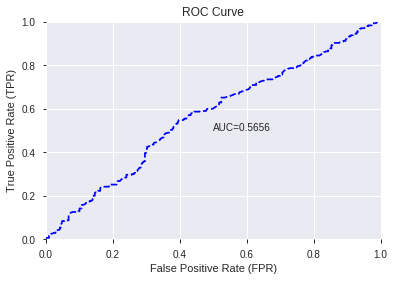

This function is available for GLM models only


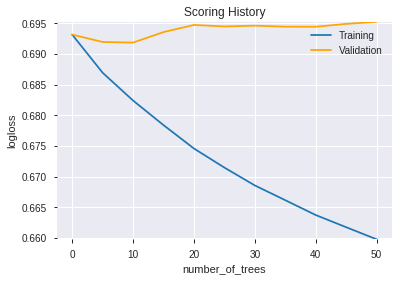

--2019-08-24 17:22:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.184
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.184|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_172213_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_172213_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCHF_fastk',
 'hour',
 'BOP',
 'dayofyear',
 'CORREL_30',
 'STOCHRSI_fastk',
 'SAREXT',
 'CORREL_24',
 'day',
 'CORREL_20',
 'HT_TRENDMODE',
 'days_in_month',
 'CORREL_14',
 'CORREL_12',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'CDLRICKSHAWMAN']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_172300_model_1  0.511332  0.69322              0.486892  0.500039  0.250039

variable  relative_importance  scaled_importance  percentage
0                          BOP             0.006643           1.000000    0.019531
1           CDLCLOSINGMARUBOZU             0.006439           0.969381    0.018933
2                 STOCHF_fastk             0.006313           0.950404    0.018562
3               STOCHRSI_fastk             0.005449           0.820286    0.016021
4                      WILLR_8             0.004309           0.648753    0.012671
...                        ...                  ...                ...         ...
1032  BBANDS_middleband_30_2_2             0.000000           0.000000    0.000000
1033  BBANDS_middleband_30_2_3             0.000000           0.000000    0.000000
1034  BBANDS_middleband_30_2_4             0.000000           0.000000    0.000000
1035  BBANDS_middleband_30_2_5             0.000000           0.000000    0.000000
1036               CDLPIERCING             0.000000           0.000000    0.000000

[1037 rows x 4 columns]

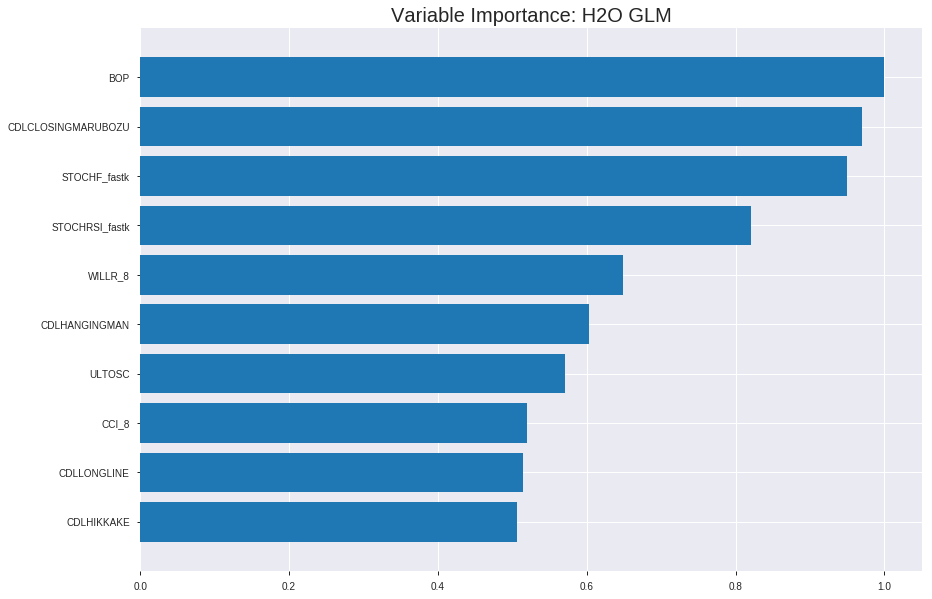

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_172300_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24798389759155665
RMSE: 0.4979798164499809
LogLoss: 0.6891071199697144
Null degrees of freedom: 4312
Residual degrees of freedom: 3313
Null deviance: 5978.575396871039
Residual deviance: 5944.238016858756
AIC: 7944.238016858756
AUC: 0.562720701772496
pr_auc: 0.5548673583781714
Gini: 0.125441403544992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42613966276329396: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      2    2131  0.9991   (2131.0/2133.0)
1      0    2180  0        (0.0/2180.0)
Total  2    4311  0.4941   (2131.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42614      0.671699  397
max f2                       0.42614      0.836467  397
max f0point5                 0.491829     0.566625  256
max accuracy                 0.50697      0.551588  195
max precision                0.600747     1         0
max recall                   0.42614      1         397
max specificity              0.600747     1         0
max absolute_mcc             0.51324      0.109523  170
max min_per_class_accuracy   0.505268     0.544495  202
max mean_per_class_accuracy  0.51324      0.552807  170

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 50.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.567779           1.16908   1.16908            0.590909         0.577437  0.590909                    0.577437            0.0119266       0.0119266                  16.9078   16.9078
    2        0.0201716                   0.559238           1.28829   1.228              0.651163         0.562961  0.62069                     0.570282            0.012844        0.0247706                  28.8287   22.7997
    3        0.0301414                   0.554479           1.19627   1.2175             0.604651         0.556569  0.615385                    0.565746            0.0119266       0.0366972                  19.6266   21.7502
    4        0.0401113                   0.550982           1.19627   1.21222            0.604651         0.552579  0.612717                    0.562473            0.0119266       0.0486239                  19.6266   21.2224
    5        0.0500812                   0.548193           0.966215  1.16325            0.488372         0.54946   0.587963                    0.559883            0.00963303      0.0582569                  -3.37849  16.325
    6        0.100162                    0.537819           1.0625    1.11287            0.537037         0.542451  0.5625                      0.551167            0.053211        0.111468                   6.24958   11.2873
    7        0.150012                    0.53123            1.15026   1.1253             0.581395         0.534324  0.568779                    0.54557             0.0573394       0.168807                   15.0256   12.5295
    8        0.200093                    0.525676           1.17241   1.13709            0.592593         0.528316  0.574739                    0.541252            0.0587156       0.227523                   17.2409   13.7087
    9        0.300023                    0.517952           1.14759   1.14058            0.580046         0.521483  0.576507                    0.534667            0.114679        0.342202                   14.7587   14.0585
    10       0.399954                    0.510975           1.0925    1.12857            0.552204         0.514329  0.570435                    0.529585            0.109174        0.451376                   9.2503    12.8571
    11       0.500116                    0.505124           0.934264  1.08966            0.472222         0.508059  0.550765                    0.525274            0.093578        0.544954                   -6.57365  8.96556
    12       0.600046                    0.499295           1.02824   1.07943            0.519722         0.50216   0.545595                    0.521425            0.102752        0.647706                   2.82381   7.94273
    13       0.699977                    0.491939           0.931841  1.05836            0.470998         0.495642  0.534945                    0.517744            0.0931193       0.740826                   -6.81592  5.83575
    14       0.799907                    0.484527           0.885937  1.03682            0.447796         0.488337  0.524058                    0.51407             0.0885321       0.829358                   -11.4063  3.68174
    15       0.899838                    0.47385            0.844624  1.01547            0.426914         0.479676  0.51327                     0.510251            0.0844037       0.913761                   -15.5376  1.54736
    16       1                           0.406467           0.860988  1                  0.435185         0.462309  0.505449                    0.505449          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25044217830742244
RMSE: 0.5004419829584869
LogLoss: 0.6940324607283291
Null degrees of freedom: 1231
Residual degrees of freedom: 232
Null deviance: 1707.0147816677918
Residual deviance: 1710.095983234603
AIC: 3710.095983234603
AUC: 0.5149532833614865
pr_auc: 0.5330308061322094
Gini: 0.029906566722972983
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43296839046353913: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    587   0.9916   (587.0/592.0)
1      2    638   0.0031   (2.0/640.0)
Total  7    1225  0.4781   (589.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.432968     0.684182   393
max f2                       0.418866     0.843882   399
max f0point5                 0.445199     0.577778   374
max accuracy                 0.447642     0.528409   365
max precision                0.605984     1          0
max recall                   0.418866     1          399
max specificity              0.605984     1          0
max absolute_mcc             0.445199     0.0520894  374
max min_per_class_accuracy   0.490601     0.510938   204
max mean_per_class_accuracy  0.495181     0.525823   185

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 49.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.559822           1.03654   1.03654            0.538462         0.581614  0.538462                    0.581614            0.0109375       0.0109375                  3.65385   3.65385
    2        0.0202922                   0.547394           1.12292   1.078              0.583333         0.553979  0.56                        0.568349            0.0109375       0.021875                   12.2917   7.8
    3        0.0300325                   0.543673           0.802083  0.988514           0.416667         0.545117  0.513514                    0.560815            0.0078125       0.0296875                  -19.7917  -1.14865
    4        0.0405844                   0.539615           1.18462   1.0395             0.615385         0.541701  0.54                        0.555845            0.0125          0.0421875                  18.4615   3.95
    5        0.0503247                   0.536962           1.12292   1.05565            0.583333         0.538262  0.548387                    0.552442            0.0109375       0.053125                   12.2917   5.56452
    6        0.100649                    0.525134           1.0246    1.04012            0.532258         0.529818  0.540323                    0.54113             0.0515625       0.104688                   2.45968   4.0121
    7        0.150162                    0.51745            1.00984   1.03014            0.52459          0.521754  0.535135                    0.534741            0.05            0.154688                   0.983607  3.01351
    8        0.200487                    0.513105           1.08669   1.04433            0.564516         0.514964  0.54251                     0.529777            0.0546875       0.209375                   8.66935   4.4332
    9        0.300325                    0.504903           1.07988   1.05615            0.560976         0.508935  0.548649                    0.522849            0.107813        0.317188                   7.9878    5.61486
    10       0.400162                    0.497159           1.00163   1.04255            0.520325         0.500928  0.541582                    0.51738             0.1             0.417187                   0.162602  4.25456
    11       0.5                         0.490261           0.939024  1.02188            0.487805         0.494084  0.530844                    0.512728            0.09375         0.510938                   -6.09756  2.1875
    12       0.599838                    0.483099           0.892073  1.00027            0.463415         0.486835  0.519621                    0.508418            0.0890625       0.6                        -10.7927  0.0270636
    13       0.699675                    0.475075           0.939024  0.991531           0.487805         0.479052  0.515081                    0.504228            0.09375         0.69375                    -6.09756  -0.846868
    14       0.799513                    0.46671            1.11118   1.00647            0.577236         0.471033  0.522843                    0.500083            0.110937        0.804688                   11.1179   0.647208
    15       0.899351                    0.455488           0.939024  0.998985           0.487805         0.461077  0.518953                    0.495753            0.09375         0.898438                   -6.09756  -0.101534
    16       1                           0.418866           1.00907   1                  0.524194         0.445745  0.519481                    0.490719           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:23:09  0.000 sec   2            4.9       1000          1.37821           1.38806
    2019-08-24 17:23:13  4.622 sec   4            3.6       1011          1.37691           1.38846
    2019-08-24 17:23:19  10.282 sec  6            2.6       1013          1.37544           1.3889
    2019-08-24 17:23:24  14.994 sec  8            1.9       1022          1.37381           1.3895
    2019-08-24 17:23:28  19.519 sec  10           1.4       1023          1.37201           1.39031

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.520259319286872)

('F1', 0.6710671067106712)

('auc', 0.511332352632132)

('logloss', 0.6932203968517104)

('mean_per_class_error', 0.47831774718924025)

('rmse', 0.5000391167349502)

('mse', 0.25003911826506914)

glm prediction progress: |████████████████████████████████████████████████| 100%


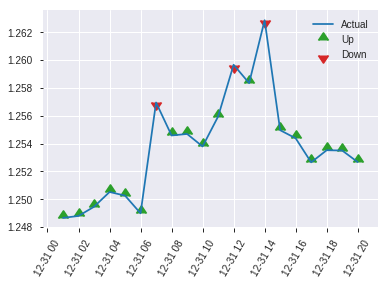


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25003911826506914
RMSE: 0.5000391167349502
LogLoss: 0.6932203968517104
Null degrees of freedom: 616
Residual degrees of freedom: -383
Null deviance: 855.3515081364842
Residual deviance: 855.4339697150107
AIC: 2855.433969715011
AUC: 0.511332352632132
pr_auc: 0.5240532997932309
Gini: 0.022664705264263896
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4387052821941441: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   294  0.9577   (294.0/307.0)
1      5    305  0.0161   (5.0/310.0)
Total  18   599  0.4846   (299.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.438705     0.671067   381
max f2                       0.419158     0.835129   398
max f0point5                 0.442444     0.564697   374
max accuracy                 0.505931     0.520259   87
max precision                0.566474     1          0
max recall                   0.419158     1          398
max specificity              0.566474     1          0
max absolute_mcc             0.538502     0.0986151  5
max min_per_class_accuracy   0.485391     0.511401   195
max mean_per_class_accuracy  0.505931     0.521682   87

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 48.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.53398            1.70599   1.70599            0.857143         0.544732  0.857143                    0.544732            0.0193548       0.0193548                  70.5991    70.5991
    2        0.0210697                   0.526406           0.663441  1.22481            0.333333         0.529243  0.615385                    0.537583            0.00645161      0.0258065                  -33.6559   22.4814
    3        0.0307942                   0.523837           1.32688   1.25705            0.666667         0.524897  0.631579                    0.533577            0.0129032       0.0387097                  32.6882    25.7046
    4        0.0405186                   0.52199            0.995161  1.19419            0.5              0.523075  0.6                         0.531057            0.00967742      0.0483871                  -0.483871  19.4194
    5        0.0502431                   0.521153           0.663441  1.09147            0.333333         0.521818  0.548387                    0.529269            0.00645161      0.0548387                  -33.6559   9.14672
    6        0.100486                    0.515346           1.09147   1.09147            0.548387         0.518308  0.548387                    0.523788            0.0548387       0.109677                   9.14672    9.14672
    7        0.150729                    0.510677           0.963059  1.04866            0.483871         0.512808  0.526882                    0.520128            0.0483871       0.158065                   -3.69407   4.86646
    8        0.200972                    0.506105           1.15567   1.07542            0.580645         0.508496  0.540323                    0.51722             0.0580645       0.216129                   15.5671    7.54162
    9        0.299838                    0.49934            0.880962  1.0113             0.442623         0.502581  0.508108                    0.512393            0.0870968       0.303226                   -11.9038   1.1299
    10       0.400324                    0.493025           1.15567   1.04754            0.580645         0.496281  0.526316                    0.508349            0.116129        0.419355                   15.5671    4.75382
    11       0.50081                     0.485376           0.930957  1.02415            0.467742         0.489471  0.514563                    0.504561            0.0935484       0.512903                   -6.90427   2.41466
    12       0.599676                    0.479227           0.783078  0.984403           0.393443         0.482107  0.494595                    0.500859            0.0774194       0.590323                   -21.6922   -1.55972
    13       0.700162                    0.470576           0.995161  0.985947           0.5              0.47511   0.49537                     0.497164            0.1             0.690323                   -0.483871  -1.40532
    14       0.799028                    0.462801           1.10936   1.00122            0.557377         0.467202  0.503043                    0.493456            0.109677        0.8                        10.936     0.121704
    15       0.899514                    0.451946           1.15567   1.01847            0.580645         0.45747   0.511712                    0.489436            0.116129        0.916129                   15.5671    1.84714
    16       1                           0.41111            0.834651  1                  0.419355         0.441539  0.502431                  

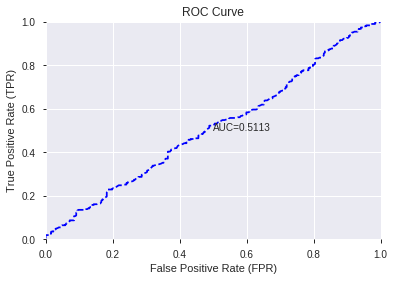

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


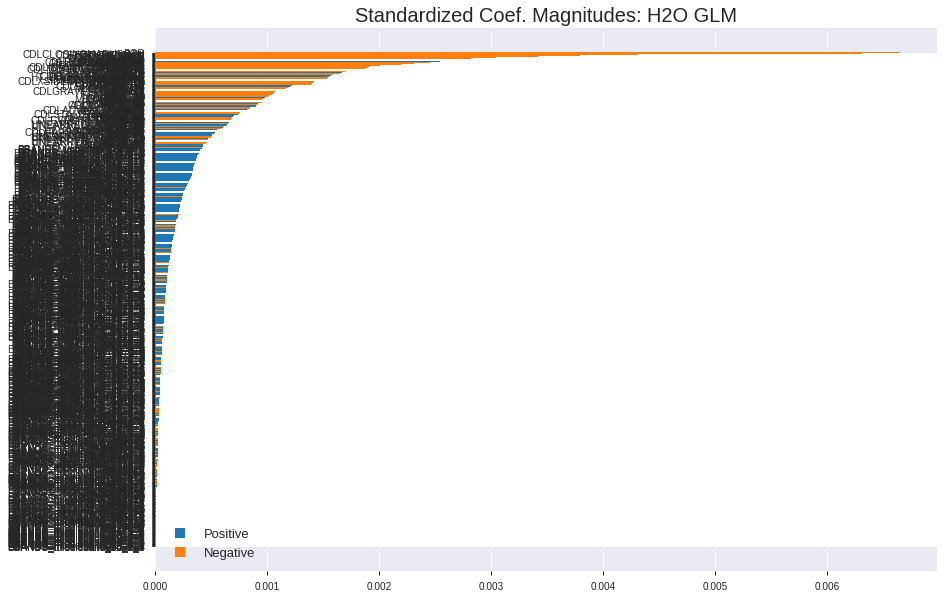

'log_likelihood'
--2019-08-24 17:23:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_172300_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_172300_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

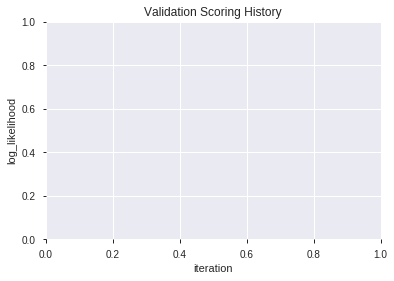

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_172400_model_6  0.559709  0.688464              0.496743  0.497677  0.247683
1               XGBoost_2_AutoML_20190824_172400  0.540165  0.700325              0.493438  0.503234  0.253245
2               XGBoost_1_AutoML_20190824_172400  0.538326  0.701764              0.500000  0.503820  0.253834
3  XGBoost_grid_1_AutoML_20190824_172400_model_1  0.537212  0.691136              0.483698  0.499115  0.249116
4  XGBoost_grid_1_AutoML_20190824_172400_model_7  0.535279  0.702365              0.496743  0.504205  0.254223
5               XGBoost_3_AutoML_20190824_172400  0.533598  0.691885              0.493454  0.499450  0.249450
6  XGBoost_grid_1_AutoML_20190824_172400_model_2  0.531727  0.695179              0.500000  0.500933  0.250934
7  XGBoost_grid_1_AutoML_20190824_172400_model_3  0.530430  0.696731              0.490196  0.501709  0.251712
8  XGBoost_grid_1_AutoML_20190824_172400_model_5  0.524356  0.725548              0.500000  0.513701  0.263889
9  XGBoost_grid_1_AutoML_20190824_172400_model_4  0.512126  0.700214              0.500000  0.503411  0.253423

variable  relative_importance  scaled_importance  percentage
0     STOCHF_fastk           343.481079           1.000000    0.035216
1              BOP           281.052979           0.818249    0.028816
2          BETA_30           163.536728           0.476116    0.016767
3             hour           160.260635           0.466578    0.016431
4      AROONOSC_12           138.787064           0.404060    0.014229
..             ...                  ...                ...         ...
274    aroondown_8             4.500601           0.013103    0.000461
275           High             4.254536           0.012387    0.000436
276  days_in_month             4.054478           0.011804    0.000416
277     PLUS_DM_12             2.818515           0.008206    0.000289
278        quarter             2.472785           0.007199    0.000254

[279 rows x 4 columns]

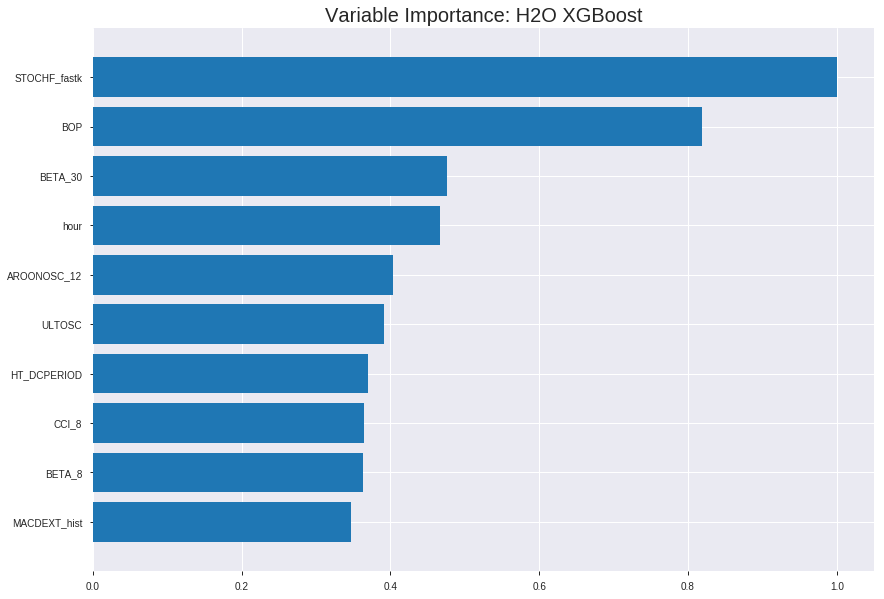

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_172400_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.20722361866475322
RMSE: 0.4552182099441467
LogLoss: 0.6059921620416516
Mean Per-Class Error: 0.21346103390581384
AUC: 0.8709227430891581
pr_auc: 0.8734744814720611
Gini: 0.7418454861783161
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.488292205901373: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1463  670   0.3141   (670.0/2133.0)
1      288   1892  0.1321   (288.0/2180.0)
Total  1751  2562  0.2221   (958.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488292     0.797976  222
max f2                       0.440328     0.871296  283
max f0point5                 0.528758     0.80803   168
max accuracy                 0.515647     0.785996  184
max precision                0.751149     1         0
max recall                   0.366077     1         349
max specificity              0.751149     1         0
max absolute_mcc             0.515647     0.575562  184
max min_per_class_accuracy   0.506144     0.783945  197
max mean_per_class_accuracy  0.515647     0.786539  184

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 50.48 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.688886           1.97844    1.97844            1                0.704745  1                           0.704745            0.0201835       0.0201835                  97.844    97.844
    2        0.0201716                   0.669128           1.97844    1.97844            1                0.676841  1                           0.690953            0.0197248       0.0399083                  97.844    97.844
    3        0.0301414                   0.653325           1.93243    1.96322            0.976744         0.660251  0.992308                    0.680798            0.0192661       0.0591743                  93.243    96.3222
    4        0.0401113                   0.64045            1.97844    1.967              1                0.646693  0.99422                     0.672321            0.0197248       0.0788991                  97.844    96.7004
    5        0.0500812                   0.631825           1.93243    1.96012            0.976744         0.63603   0.990741                    0.665097            0.0192661       0.0981651                  93.243    96.0121
    6        0.100162                    0.60472            1.85937    1.90974            0.939815         0.616074  0.965278                    0.640585            0.0931193       0.191284                   85.9368   90.9745
    7        0.150012                    0.586123           1.84041    1.8867             0.930233         0.594982  0.953632                    0.625431            0.0917431       0.283028                   84.041    88.6704
    8        0.200093                    0.570835           1.77693    1.85923            0.898148         0.578912  0.939745                    0.613788            0.0889908       0.372018                   77.6933   85.923
    9        0.300023                    0.547183           1.61121    1.77662            0.814385         0.558237  0.897991                    0.595285            0.161009        0.533028                   61.1212   77.6621
    10       0.399954                    0.525894           1.38629    1.67909            0.700696         0.536635  0.848696                    0.580631            0.138532        0.67156                    38.6285   67.9094
    11       0.500116                    0.506431           1.09455    1.56202            0.553241         0.515808  0.789522                    0.567648            0.109633        0.781193                   9.45538   56.2023
    12       0.600046                    0.48659            0.904299   1.45249            0.457077         0.49661   0.734158                    0.555818            0.090367        0.87156                    -9.57013  45.2487
    13       0.699977                    0.465256           0.592155   1.32966            0.299304         0.476372  0.672077                    0.544476            0.0591743       0.930734                   -40.7845  32.9664
    14       0.799907                    0.44078            0.413131   1.21516            0.208817         0.453089  0.614203                    0.533059            0.0412844       0.972018                   -58.6869  21.5164
    15       0.899838                    0.400874           0.234108   1.10621            0.118329         0.423197  0.559134                    0.520858            0.0233945       0.995413                   -76.5892  10.6214
    16       1                           0.238788           0.0457972  1                  0.0231481        0.360972  0.505449                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25384622315097055
RMSE: 0.5038315424335504
LogLoss: 0.7011498724487173
Mean Per-Class Error: 0.4787162162162162
AUC: 0.5171940983952703
pr_auc: 0.5330430339495931
Gini: 0.034388196790540615
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2759716510772705: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    585   0.9882   (585.0/592.0)
1      2    638   0.0031   (2.0/640.0)
Total  9    1223  0.4765   (587.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.275972     0.684917   390
max f2                       0.252044     0.84455    396
max f0point5                 0.340351     0.577917   370
max accuracy                 0.411931     0.534091   308
max precision                0.627224     0.59375    24
max recall                   0.252044     1          396
max specificity              0.719242     0.998311   0
max absolute_mcc             0.323146     0.0574615  377
max min_per_class_accuracy   0.491878     0.50625    194
max mean_per_class_accuracy  0.411931     0.521284   308

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 48.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.657995           0.888462  0.888462           0.461538         0.684865  0.461538                    0.684865            0.009375        0.009375                   -11.1538  -11.1538
    2        0.0202922                   0.633885           1.28333   1.078              0.666667         0.645879  0.56                        0.666152            0.0125          0.021875                   28.3333   7.8
    3        0.0300325                   0.621673           0.9625    1.04054            0.5              0.628042  0.540541                    0.653792            0.009375        0.03125                    -3.75     4.05405
    4        0.0405844                   0.612382           0.740385  0.9625             0.384615         0.617312  0.5                         0.644307            0.0078125       0.0390625                  -25.9615  -3.75
    5        0.0503247                   0.604927           1.12292   0.993548           0.583333         0.608575  0.516129                    0.637391            0.0109375       0.05                       12.2917   -0.645161
    6        0.100649                    0.579337           1.11774   1.05565            0.580645         0.58991   0.548387                    0.613651            0.05625         0.10625                    11.7742   5.56452
    7        0.150162                    0.56296            1.19918   1.10297            0.622951         0.571787  0.572973                    0.599847            0.059375        0.165625                   19.918    10.2973
    8        0.200487                    0.549757           1.0246    1.0833             0.532258         0.555907  0.562753                    0.588818            0.0515625       0.217188                   2.45968   8.32996
    9        0.300325                    0.527005           0.985976  1.05095            0.512195         0.537588  0.545946                    0.571787            0.0984375       0.315625                   -1.40244  5.09459
    10       0.400162                    0.509291           0.907724  1.01521            0.471545         0.519321  0.527383                    0.558697            0.090625        0.40625                    -9.22764  1.5213
    11       0.5                         0.491394           1.00163   1.0125             0.520325         0.500123  0.525974                    0.547001            0.1             0.50625                    0.162602  1.25
    12       0.599838                    0.472365           1.00163   1.01069            0.520325         0.481721  0.525034                    0.536136            0.1             0.60625                    0.162602  1.06901
    13       0.699675                    0.450042           0.954675  1.0027             0.495935         0.462747  0.520882                    0.525664            0.0953125       0.701562                   -4.53252  0.269722
    14       0.799513                    0.42283            1.12683   1.0182             0.585366         0.437971  0.528934                    0.514714            0.1125          0.814063                   12.6829   1.8198
    15       0.899351                    0.383097           0.876423  1.00246            0.455285         0.4051    0.520758                    0.502545            0.0875          0.901563                   -12.3577  0.245939
    16       1                           0.215344           0.978024  1                  0.508065         0.345628  0.519481                    0.486752            0.0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:25:20  45.584 sec  0                  0.5              0.693147            0.5             0                  1                0.494551                         0.5                0.693147              0.5               0                    1                  0.480519
    2019-08-24 17:25:21  46.750 sec  5                  0.49392          0.681044            0.691931        0.689405           1.75861          0.404591                         0.500019           0.693186              0.51283           0.528518             1.18462            0.478896
    2019-08-24 17:25:21  47.146 sec  10                 0.488369         0.670075            0.740459        0.738222           1.88851          0.358451                         0.500659           0.694472              0.509548          0.516418             0.740385           0.478084
    2019-08-24 17:25:22  47.545 sec  15                 0.482778         0.659107            0.774616        0.77207            1.84355          0.333179                         0.500691           0.694535              0.513133          0.528274             1.03654            0.478084
    2019-08-24 17:25:22  47.955 sec  20                 0.477657         0.649106            0.798459        0.795619           1.93348          0.287503                         0.500962           0.695115              0.518924          0.533839             0.888462           0.474838
    2019-08-24 17:25:22  48.339 sec  25                 0.474304         0.642596            0.813543        0.814804           1.93348          0.284489                         0.501942           0.69714               0.51297           0.528475             0.740385           0.480519
    2019-08-24 17:25:23  48.722 sec  30                 0.47066          0.63553             0.823954        0.824091           1.93348          0.286807                         0.502314           0.697934              0.514272          0.530685             0.888462           0.478896
    2019-08-24 17:25:23  49.103 sec  35                 0.466953         0.628388            0.836652        0.838401           1.97844          0.265245                         0.502308           0.697922              0.516291          0.534141             0.888462           0.477273
    2019-08-24 17:25:24  49.483 sec  40                 0.464246         0.623193            0.848004        0.848755           1.97844          0.25342                          0.503261           0.699891              0.51203           0.529253             0.740385           0.473214
    2019-08-24 17:25:24  49.968 sec  45                 0.459356         0.613876            0.863324        0.865243           1.97844          0.237654                         0.503548           0.700517              0.513422          0.532538             0.888462           0.474838
    2019-08-24 17:25:25  50.377 sec  50                 0.455218         0.605992            0.870923        0.873474           1.97844          0.222119                         0.503832           0.70115               0.517194          0.533043             0.888462           0.476461

Variable Importances: 


variable       relative_importance    scaled_importance     percentage
-------------  ---------------------  --------------------  ----------------------
STOCHF_fastk   343.4810791015625      1.0                   0.03521611929115537
BOP            281.052978515625       0.8182487933564504    0.028815547116684697
BETA_30        163.53672790527344     0.4761156810530397    0.01676694662035353
hour           160.26063537597656     0.4665777684033354    0.016431058350692924
AROONOSC_12    138.7870635986328      0.40406028757582724   0.014229435288088876
---            ---                    ---                   ---
aroondown_8    4.500601291656494      0.013102908909651266  0.0004614336032234215
High           4.254535675048828      0.012386521220258604  0.0004362052088950544
days_in_month  4.054477691650391      0.01180407870574885   0.0004156938438238384
PLUS_DM_12     2.818514823913574      0.008205735324012357  0.00028897415404206665
quarter        2.4727847576141357     0.00719918769348855   0.00025352745261331047


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5494327390599676)

('F1', 0.6702702702702703)

('auc', 0.5597089418934539)

('logloss', 0.6884642903947185)

('mean_per_class_error', 0.4488756961227278)

('rmse', 0.4976771868153936)

('mse', 0.24768258227648415)

xgboost prediction progress: |████████████████████████████████████████████| 100%


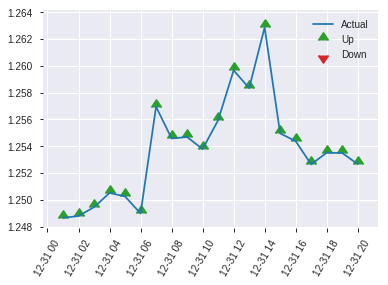


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24768258227648415
RMSE: 0.4976771868153936
LogLoss: 0.6884642903947185
Mean Per-Class Error: 0.4488756961227278
AUC: 0.5597089418934539
pr_auc: 0.5676674622418233
Gini: 0.11941788378690776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32217568159103394: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    305  0.9935   (305.0/307.0)
1      0    310  0        (0.0/310.0)
Total  2    615  0.4943   (305.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.322176     0.67027   397
max f2                       0.322176     0.83558   397
max f0point5                 0.476595     0.564516  268
max accuracy                 0.587895     0.549433  75
max precision                0.741394     1         0
max recall                   0.322176     1         397
max specificity              0.741394     1         0
max absolute_mcc             0.595587     0.143838  69
max min_per_class_accuracy   0.513026     0.541935  200
max mean_per_class_accuracy  0.587895     0.551124  75

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.691129           1.70599   1.70599            0.857143         0.707367  0.857143                    0.707367            0.0193548       0.0193548                  70.5991    70.5991
    2        0.0210697                   0.681856           0.995161  1.37792            0.5              0.686046  0.692308                    0.697526            0.00967742      0.0290323                  -0.483871  37.7916
    3        0.0307942                   0.659558           1.32688   1.3618             0.666667         0.673624  0.684211                    0.689978            0.0129032       0.0419355                  32.6882    36.18
    4        0.0405186                   0.649002           0.995161  1.27381            0.5              0.653296  0.64                        0.681174            0.00967742      0.0516129                  -0.483871  27.3806
    5        0.0502431                   0.642712           0.663441  1.15567            0.333333         0.646448  0.580645                    0.674453            0.00645161      0.0580645                  -33.6559   15.5671
    6        0.100486                    0.610661           1.47669   1.31618            0.741935         0.624904  0.66129                     0.649679            0.0741935       0.132258                   47.6691    31.6181
    7        0.150729                    0.587909           1.34828   1.32688            0.677419         0.599084  0.666667                    0.632814            0.0677419       0.2                        34.8283    32.6882
    8        0.200972                    0.577158           0.834651  1.20382            0.419355         0.582206  0.604839                    0.620162            0.0419355       0.241935                   -16.5349   20.3824
    9        0.299838                    0.546594           0.946219  1.11888            0.47541          0.560788  0.562162                    0.600585            0.0935484       0.335484                   -5.37811   11.8884
    10       0.400324                    0.526552           1.09147   1.112              0.548387         0.536142  0.558704                    0.584409            0.109677        0.445161                   9.14672    11.2002
    11       0.50081                     0.512573           0.963059  1.08212            0.483871         0.518989  0.543689                    0.571282            0.0967742       0.541935                   -3.69407   8.21171
    12       0.599676                    0.494173           0.946219  1.05971            0.47541          0.50363   0.532432                    0.560129            0.0935484       0.635484                   -5.37811   5.97123
    13       0.700162                    0.477346           1.02726   1.05506            0.516129         0.48553   0.530093                    0.549423            0.103226        0.73871                    2.72633    5.50553
    14       0.799028                    0.460332           0.750449  1.01737            0.377049         0.469037  0.511156                    0.539476            0.0741935       0.812903                   -24.9551   1.73657
    15       0.899514                    0.421893           0.898855  1.00413            0.451613         0.441406  0.504505                    0.528521            0.0903226       0.903226                   -10.1145   0.412671
    16       1                           0.298378           0.963059  1                  0.483871         0.388807  0.502431                    0

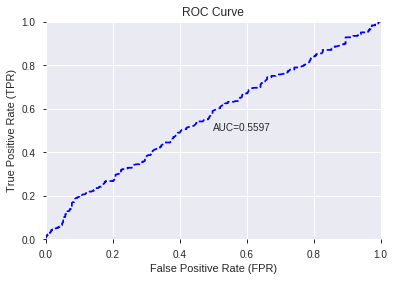

This function is available for GLM models only


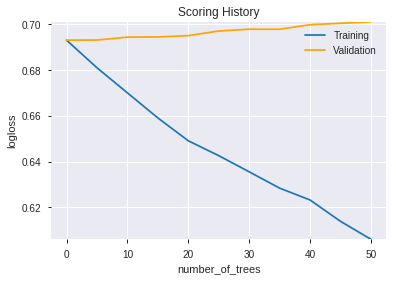

--2019-08-24 17:25:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(Shared

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_172400_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_172400_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_172551_model_6  0.533277  0.692742              0.488521  0.499754  0.249754
1  DeepLearning_grid_1_AutoML_20190824_172551_model_3  0.533120  0.772781              0.491825  0.515058  0.265284
2  DeepLearning_grid_1_AutoML_20190824_172551_model_9  0.531491  0.692802              0.495098  0.499823  0.249823
3  DeepLearning_grid_1_AutoML_20190824_172551_model_2  0.530787  0.793283              0.472234  0.529666  0.280546
4               DeepLearning_1_AutoML_20190824_172551  0.527393  0.725697              0.498356  0.513314  0.263491
5  DeepLearning_grid_1_AutoML_20190824_172551_model_8  0.523174  0.692921              0.495114  0.499888  0.249888
6  DeepLearning_grid_1_AutoML_20190824_172551_model_7  0.521982  0.763663              0.483603  0.527528  0.278286
7  DeepLearning_grid_1_AutoML_20190824_172551_model_5  0.515961  0.701869              0.498371  0.504166  0.254184
8  DeepLearning_grid_1_AutoML_20190824_172551_model_4  0.505585  0.754760              0.500000  0.521469  0.271930
9  DeepLearning_grid_1_AutoML_20190824_172551_model_1  0.505117  1.145587              0.500000  0.566258  0.320648

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.029819
1          STOCHF_fastk             0.939854           0.939854    0.028026
2          HT_TRENDMODE             0.827399           0.827399    0.024672
3                SAREXT             0.809907           0.809907    0.024151
4        STOCHRSI_fastk             0.807154           0.807154    0.024069
5             CORREL_30             0.779213           0.779213    0.023236
6             dayofyear             0.778923           0.778923    0.023227
7             CORREL_24             0.746453           0.746453    0.022259
8                  hour             0.745753           0.745753    0.022238
9         days_in_month             0.744136           0.744136    0.022190
10                  day             0.739262           0.739262    0.022044
11            CORREL_20             0.718839           0.718839    0.021435
12              CDLDOJI             0.693964           0.693964    0.020693
13        CDLHANGINGMAN             0.677823           0.677823    0.020212
14       CDLEVENINGSTAR             0.676742           0.676742    0.020180
15         is_month_end             0.676244           0.676244    0.020165
16       CDLRICKSHAWMAN             0.669300           0.669300    0.019958
17         CDLTHRUSTING             0.669180           0.669180    0.019954
18  CDLGAPSIDESIDEWHITE             0.668954           0.668954    0.019948
19       CDLMORNINGSTAR             0.666906           0.666906    0.019887
20      CDLSHOOTINGSTAR             0.665465           0.665465    0.019844
21            CORREL_14             0.660861           0.660861    0.019706
22            CDLONNECK             0.658009           0.658009    0.019621
23             CORREL_8             0.652747           0.652747    0.019464
24   CDLIDENTICAL3CROWS             0.645383           0.645383    0.019245
25    CDLLONGLEGGEDDOJI             0.645365           0.645365    0.019244
26       is_month_start             0.643456           0.643456    0.019187
27    CDLSTALLEDPATTERN             0.641389           0.641389    0.019126
28       CDLMATCHINGLOW             0.632088           0.632088    0.018848
29    CDLINVERTEDHAMMER             0.630548           0.630548    0.018802
30   CDLEVENINGDOJISTAR             0.622828           0.622828    0.018572
31   CDLMORNINGDOJISTAR             0.622816           0.622816    0.018572
32      CDLUNIQUE3RIVER             0.620400           0.620400    0.018500
33       CDL3LINESTRIKE             0.618389           0.618389    0.018440
34      CDLHOMINGPIGEON             0.618052           0.618052    0.018430
35            CORREL_12             0.617278           0.617278    0.018407
36  CDLRISEFALL3METHODS             0.616447           0.616447    0.018382
37        CDLHIKKAKEMOD             0.612531           0.612531    0.018265
38           CDL3INSIDE             0.598643           0.598643    0.017851
39    CDLGRAVESTONEDOJI             0.597529           0.597529    0.017818
40    CDLDARKCLOUDCOVER             0.597495           0.597495    0.017817
41     is_quarter_start             0.596759           0.596759    0.017795
42      CDLADVANCEBLOCK             0.595083           0.595083    0.017745
43     CDLDRAGONFLYDOJI             0.594852           0.594852    0.017738
44            CDLHAMMER             0.588809           0.588809    0.017558
45       CDL3BLACKCROWS             0.588394           0.588394    0.017545
46         CDLTASUKIGAP             0.583187           0.583187    0.017390
47            CDLTAKURI             0.579567           0.579567    0.017282
48          CDLPIERCING             0.579438           0.579438    0.017278
49            CDLINNECK             0.575545           0.575545    0.017162

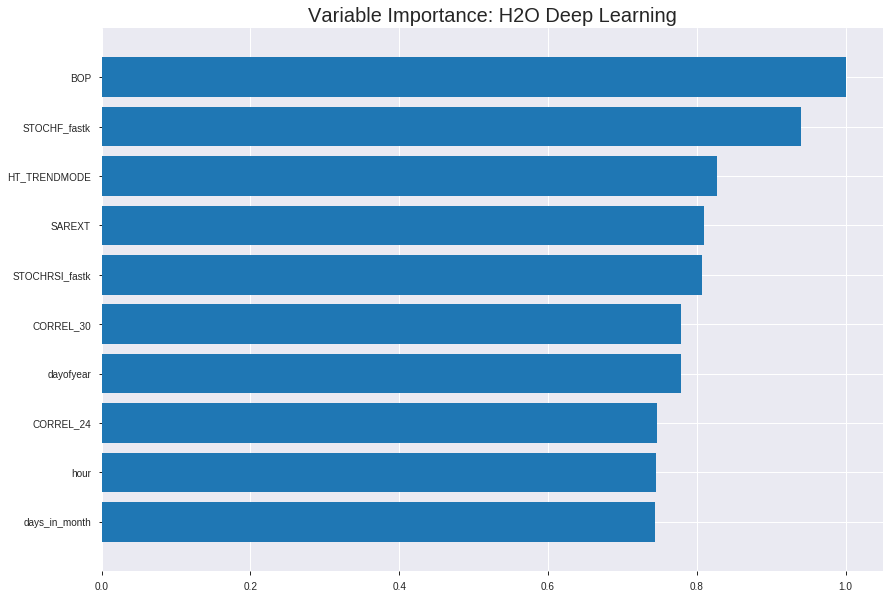

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_172551_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24576764195862003
RMSE: 0.49574957585319224
LogLoss: 0.6845181091089644
Mean Per-Class Error: 0.43644713695230475
AUC: 0.5901237435321746
pr_auc: 0.5906285523676182
Gini: 0.18024748706434912
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4027318060042436: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      39   2094  0.9817   (2094.0/2133.0)
1      6    2174  0.0028   (6.0/2180.0)
Total  45   4268  0.4869   (2100.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.402732     0.674318  370
max f2                       0.402732     0.836926  370
max f0point5                 0.521222     0.582014  238
max accuracy                 0.521222     0.5655    238
max precision                0.70121      0.928571  9
max recall                   0.278474     1         395
max specificity              0.804258     0.999531  0
max absolute_mcc             0.521222     0.136158  238
max min_per_class_accuracy   0.532827     0.56165   203
max mean_per_class_accuracy  0.521222     0.563553  238

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 53.65 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.6557             1.66369   1.66369            0.840909         0.692462  0.840909                    0.692462            0.0169725       0.0169725                  66.3688   66.3688
    2        0.0201716                   0.633742           1.38031   1.52363            0.697674         0.643497  0.770115                    0.66826             0.0137615       0.0307339                  38.0307   52.3626
    3        0.0301414                   0.618321           1.38031   1.47622            0.697674         0.625463  0.746154                    0.654104            0.0137615       0.0444954                  38.0307   47.6221
    4        0.0401113                   0.60762            1.28829   1.42951            0.651163         0.614028  0.722543                    0.644143            0.012844        0.0573394                  28.8287   42.9509
    5        0.0500812                   0.600498           1.19627   1.38308            0.604651         0.603828  0.699074                    0.636118            0.0119266       0.0692661                  19.6266   38.3076
    6        0.100162                    0.581074           1.21821   1.30064            0.615741         0.588393  0.657407                    0.612256            0.0610092       0.130275                   21.8206   30.0641
    7        0.150012                    0.571459           1.15946   1.25373            0.586047         0.576095  0.633694                    0.600239            0.0577982       0.188073                   15.9458   25.3726
    8        0.200093                    0.564316           1.12661   1.22191            0.569444         0.567648  0.617613                    0.592082            0.056422        0.244495                   12.6612   22.191
    9        0.300023                    0.551889           1.0925    1.17881            0.552204         0.557943  0.595827                    0.580711            0.109174        0.35367                    9.2503    17.8808
    10       0.399954                    0.54115            1.03742   1.14348            0.524362         0.546551  0.577971                    0.572176            0.10367         0.457339                   3.74188   14.3481
    11       0.500116                    0.532819           1.0396    1.12268            0.525463         0.536705  0.567455                    0.565072            0.104128        0.561468                   3.95971   12.2675
    12       0.600046                    0.526487           0.973154  1.09777            0.491879         0.529545  0.554869                    0.559155            0.0972477       0.658716                   -2.6846   9.77745
    13       0.699977                    0.519593           1.00988   1.08523            0.510441         0.523073  0.548526                    0.554004            0.100917        0.759633                   0.987675  8.5226
    14       0.799907                    0.512029           0.812492  1.05115            0.410673         0.515993  0.531304                    0.549255            0.0811927       0.840826                   -18.7508  5.1154
    15       0.899838                    0.49858            0.872166  1.03128            0.440835         0.506321  0.521257                    0.544487            0.087156        0.927982                   -12.7834  3.12767
    16       1                           0.262955           0.719017  1                  0.363426         0.464265  0.505449                    0.536452            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25208070002896127
RMSE: 0.5020763886391804
LogLoss: 0.6978019605554668
Mean Per-Class Error: 0.48055320945945945
AUC: 0.5091176625844595
pr_auc: 0.5244180068681572
Gini: 0.018235325168918903
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3868000016385504: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    585   0.9882   (585.0/592.0)
1      3    637   0.0047   (3.0/640.0)
Total  10   1222  0.4773   (588.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.3868       0.684211   389
max f2                       0.265724     0.843882   399
max f0point5                 0.465613     0.577217   348
max accuracy                 0.495898     0.529221   284
max precision                0.744784     0.666667   5
max recall                   0.265724     1          399
max specificity              0.816058     0.998311   0
max absolute_mcc             0.465613     0.0492194  348
max min_per_class_accuracy   0.524112     0.501689   210
max mean_per_class_accuracy  0.495898     0.519447   284

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.724757           1.03654   1.03654            0.538462         0.753708  0.538462                    0.753708            0.0109375       0.0109375                  3.65385   3.65385
    2        0.0202922                   0.705101           1.12292   1.078              0.583333         0.714953  0.56                        0.735105            0.0109375       0.021875                   12.2917   7.8
    3        0.0300325                   0.687407           0.9625    1.04054            0.5              0.694623  0.540541                    0.721976            0.009375        0.03125                    -3.75     4.05405
    4        0.0405844                   0.663785           0.740385  0.9625             0.384615         0.677264  0.5                         0.710351            0.0078125       0.0390625                  -25.9615  -3.75
    5        0.0503247                   0.633434           1.44375   1.05565            0.75             0.648562  0.548387                    0.698392            0.0140625       0.053125                   44.375    5.56452
    6        0.100649                    0.585794           0.900403  0.978024           0.467742         0.609373  0.508065                    0.653882            0.0453125       0.0984375                  -9.95968  -2.19758
    7        0.150162                    0.565639           1.16762   1.04054            0.606557         0.573827  0.540541                    0.627486            0.0578125       0.15625                    16.7623   4.05405
    8        0.200487                    0.556244           1.11774   1.05992            0.580645         0.560661  0.550607                    0.610712            0.05625         0.2125                     11.7742   5.9919
    9        0.300325                    0.541992           0.907724  1.00932            0.471545         0.54962   0.524324                    0.590403            0.090625        0.303125                   -9.22764  0.932432
    10       0.400162                    0.531561           0.939024  0.991785           0.487805         0.536406  0.515213                    0.576931            0.09375         0.396875                   -6.09756  -0.821501
    11       0.5                         0.524047           1.04858   1.00313            0.544715         0.527066  0.521104                    0.566974            0.104688        0.501563                   4.85772   0.3125
    12       0.599838                    0.516836           1.03293   1.00809            0.536585         0.520649  0.523681                    0.559264            0.103125        0.604688                   3.29268   0.808525
    13       0.699675                    0.502352           1.00163   1.00716            0.520325         0.509957  0.523202                    0.552228            0.1             0.704688                   0.162602  0.716357
    14       0.799513                    0.487694           1.07988   1.01624            0.560976         0.495733  0.527919                    0.545173            0.107813        0.8125                     7.9878    1.62437
    15       0.899351                    0.472835           0.939024  1.00767            0.487805         0.481057  0.523466                    0.538056            0.09375         0.90625                    -6.09756  0.767148
    16       1                           0.265724           0.931452  1                  0.483871         0.4454    0.519481                    0.52873           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:32:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:32:13  4 min 12.220 sec  1018 obs/sec      0.588917  1             2540       0.52799          0.765387            -0.115225      0.548194        0.543806           1.21404          0.494551                         0.522876           0.751967              -0.0952591       0.5122            0.519866             0.740385           0.479708
    2019-08-24 17:32:28  4 min 27.580 sec  2785 obs/sec      10.5504   18            45504      0.49575          0.684518            0.0168127      0.590124        0.590629           1.66369          0.4869                           0.502076           0.697802              -0.00985572      0.509118          0.524418             1.03654            0.477273
    2019-08-24 17:32:44  4 min 43.070 sec  3176 obs/sec      22.3246   38            96286      0.492587         0.677937            0.0293183      0.595786        0.603358           1.79858          0.478553                         0.516801           0.735092              -0.0699587       0.527455          0.540174             1.18462            0.480519
    2019-08-24 17:32:59  4 min 58.648 sec  3370 obs/sec      34.6378   59            149393     0.488681         0.669591            0.0446497      0.622531        0.627367           1.75362          0.457918                         0.519996           0.744786              -0.0832261       0.505993          0.517545             1.03654            0.478896
    2019-08-24 17:33:15  5 min 14.682 sec  3488 obs/sec      47.5653   81            205149     0.485746         0.663406            0.0560917      0.629447        0.637646           1.84355          0.461859                         0.520669           0.748474              -0.0860339       0.507968          0.521852             0.888462           0.480519
    2019-08-24 17:33:31  5 min 30.470 sec  3534 obs/sec      59.894    102           258323     0.483738         0.659265            0.063878       0.637568        0.645429           1.84355          0.433341                         0.517809           0.748172              -0.0741353       0.506361          0.517143             0.888462           0.479708
    2019-08-24 17:33:33  5 min 31.985 sec  3533 obs/sec      59.894    102           258323     0.49575          0.684518            0.0168127      0.590124        0.590629           1.66369          0.4869                           0.502076           0.697802              -0.00985572      0.509118          0.524418             1.03654            0.477273

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  --------------------
BOP             1.0                    1.0                  0.02981927344609367
STOCHF_fastk    0.9398536682128906     0.9398536682128906   0.028025753531754377
HT_TRENDMODE    0.8273988962173462     0.8273988962173462   0.024672433935301122
SAREXT          0.8099072575569153     0.8099072575569153   0.024150845979065468
STOCHRSI_fastk  0.8071542382240295     0.8071542382240295   0.024068752942775766
---             ---                    ---                  ---
CDL3BLACKCROWS  0.5883936882019043     0.5883936882019043   0.01754547228244816
CDLTASUKIGAP    0.583187460899353      0.583187460899353    0.017390226366890867
CDLTAKURI       0.5795666575431824     0.5795666575431824   0.01728225664151868
CDLPIERCING     0.5794376730918884     0.5794376730918884   0.017278410418895253
CDLINNECK       0.5755448341369629     0.5755448341369629   0.01716232878961672


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5348460291734197)

('F1', 0.6703296703296703)

('auc', 0.5332772932646842)

('logloss', 0.6927419369065437)

('mean_per_class_error', 0.46547231270358314)

('rmse', 0.4997539011152511)

('mse', 0.24975396167991218)

deeplearning prediction progress: |███████████████████████████████████████| 100%


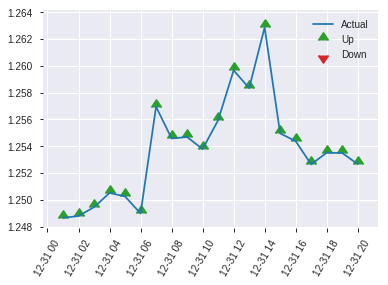


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24975396167991218
RMSE: 0.4997539011152511
LogLoss: 0.6927419369065437
Mean Per-Class Error: 0.46547231270358314
AUC: 0.5332772932646842
pr_auc: 0.5284176310536697
Gini: 0.06655458652936841
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43317086236764735: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   295  0.9609   (295.0/307.0)
1      5    305  0.0161   (5.0/310.0)
Total  17   600  0.4862   (300.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.433171     0.67033    382
max f2                       0.378238     0.83558    397
max f0point5                 0.439098     0.563197   377
max accuracy                 0.514883     0.534846   209
max precision                0.696883     0.75       3
max recall                   0.378238     1          397
max specificity              0.746083     0.996743   0
max absolute_mcc             0.439098     0.0708588  377
max min_per_class_accuracy   0.522276     0.52443    189
max mean_per_class_accuracy  0.514883     0.534528   209

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 51.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.667567           1.13733   1.13733            0.571429         0.699335  0.571429                    0.699335            0.0129032       0.0129032                  13.7327    13.7327
    2        0.0210697                   0.636897           0.663441  0.91861            0.333333         0.647358  0.461538                    0.675346            0.00645161      0.0193548                  -33.6559   -8.13896
    3        0.0307942                   0.609237           0.995161  0.942784           0.5              0.618725  0.473684                    0.657465            0.00967742      0.0290323                  -0.483871  -5.72156
    4        0.0405186                   0.590426           1.32688   1.03497            0.666667         0.598915  0.52                        0.643413            0.0129032       0.0419355                  32.6882    3.49677
    5        0.0502431                   0.581469           1.32688   1.09147            0.666667         0.585862  0.548387                    0.632274            0.0129032       0.0548387                  32.6882    9.14672
    6        0.100486                    0.560222           1.21988   1.15567            0.612903         0.569731  0.580645                    0.601003            0.0612903       0.116129                   21.9875    15.5671
    7        0.150729                    0.552216           0.963059  1.09147            0.483871         0.556368  0.548387                    0.586124            0.0483871       0.164516                   -3.69407   9.14672
    8        0.200972                    0.545884           1.15567   1.10752            0.580645         0.548051  0.556452                    0.576606            0.0580645       0.222581                   15.5671    10.7518
    9        0.299838                    0.535152           1.01148   1.07585            0.508197         0.540613  0.540541                    0.564738            0.1             0.322581                   1.14754    7.585
    10       0.400324                    0.527357           1.02726   1.06365            0.516129         0.53103   0.534413                    0.556277            0.103226        0.425806                   2.72633    6.36542
    11       0.50081                     0.522214           0.995161  1.04991            0.5              0.524537  0.527508                    0.549908            0.1             0.525806                   -0.483871  4.99113
    12       0.599676                    0.51142            0.946219  1.03282            0.47541          0.516561  0.518919                    0.544411            0.0935484       0.619355                   -5.37811   3.2816
    13       0.700162                    0.493921           0.995161  1.02741            0.5              0.504085  0.516204                    0.538623            0.1             0.719355                   -0.483871  2.74119
    14       0.799028                    0.480043           0.913591  1.01333            0.459016         0.486988  0.509128                    0.532234            0.0903226       0.809677                   -8.64093   1.33285
    15       0.899514                    0.466682           0.930957  1.00413            0.467742         0.474197  0.504505                    0.525751            0.0935484       0.903226                   -6.90427   0.412671
    16       1                           0.337367           0.963059  1                  0.483871         0.438216  0.502431                    

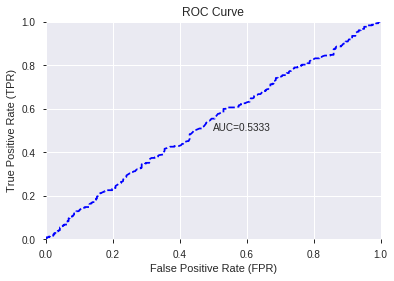

This function is available for GLM models only


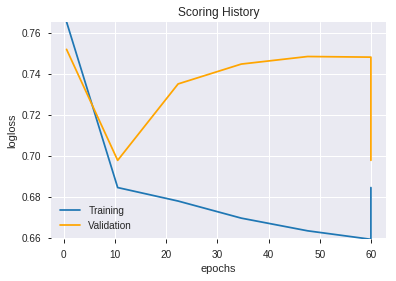

--2019-08-24 17:42:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.84.8
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.84.8|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_172551_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_172551_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'STOCHF_fastk',
 'HT_TRENDMODE',
 'SAREXT',
 'STOCHRSI_fastk',
 'CORREL_30',
 'dayofyear',
 'CORREL_24',
 'hour',
 'days_in_month',
 'day',
 'CORREL_20',
 'CDLDOJI',
 'CDLHANGINGMAN',
 'CDLEVENINGSTAR',
 'is_month_end',
 'CDLRICKSHAWMAN',
 'CDLTHRUSTING',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGSTAR',
 'CDLSHOOTINGSTAR',
 'CORREL_14',
 'CDLONNECK',
 'CORREL_8',
 'CDLIDENTICAL3CROWS',
 'CDLLONGLEGGEDDOJI',
 'is_month_start',
 'CDLSTALLEDPATTERN',
 'CDLMATCHINGLOW',
 'CDLINVERTEDHAMMER',
 'CDLEVENINGDOJISTAR',
 'CDLMORNINGDOJISTAR',
 'CDLUNIQUE3RIVER',
 'CDL3LINESTRIKE',
 'CDLHOMINGPIGEON',
 'CORREL_12',
 'CDLRISEFALL3METHODS',
 'CDLHIKKAKEMOD',
 'CDL3INSIDE',
 'CDLGRAVESTONEDOJI',
 'CDLDARKCLOUDCOVER',
 'is_quarter_start',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CDLHAMMER',
 'CDL3BLACKCROWS',
 'CDLTASUKIGAP',
 'CDLTAKURI',
 'CDLPIERCING',
 'CDLINNECK']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_174256_model_1  0.530566  0.692112              0.491825  0.499482  0.249483

variable  relative_importance  scaled_importance  percentage
0          STOCHF_fastk             0.019730           1.000000    0.100281
1                   BOP             0.018001           0.912367    0.091493
2        STOCHRSI_fastk             0.015494           0.785301    0.078751
3         CDLHANGINGMAN             0.009681           0.490700    0.049208
4                SAREXT             0.006874           0.348404    0.034938
5          is_month_end             0.006585           0.333744    0.033468
6       CDLHOMINGPIGEON             0.006070           0.307637    0.030850
7      is_quarter_start             0.005963           0.302243    0.030309
8        CDLMATCHINGLOW             0.005880           0.298002    0.029884
9             CORREL_12             0.005525           0.280040    0.028083
10       CDLEVENINGSTAR             0.005396           0.273478    0.027425
11            dayofyear             0.005209           0.264026    0.026477
12   CDLIDENTICAL3CROWS             0.004914           0.249083    0.024978
13            CDLINNECK             0.004820           0.244294    0.024498
14   CDLMORNINGDOJISTAR             0.004384           0.222203    0.022283
15       CDLMORNINGSTAR             0.004177           0.211702    0.021230
16       CDL3LINESTRIKE             0.004007           0.203077    0.020365
17       CDL3BLACKCROWS             0.003928           0.199079    0.019964
18         CDLTHRUSTING             0.003887           0.197026    0.019758
19       CDLRICKSHAWMAN             0.003885           0.196888    0.019744
20      CDLUNIQUE3RIVER             0.003720           0.188543    0.018907
21         HT_TRENDMODE             0.003681           0.186592    0.018712
22           CDL3INSIDE             0.003675           0.186248    0.018677
23            CORREL_14             0.003509           0.177877    0.017838
24     CDLDRAGONFLYDOJI             0.003399           0.172287    0.017277
25       is_month_start             0.002746           0.139194    0.013959
26    CDLGRAVESTONEDOJI             0.002544           0.128950    0.012931
27      CDLADVANCEBLOCK             0.002437           0.123493    0.012384
28                 hour             0.002405           0.121885    0.012223
29            CDLTAKURI             0.002300           0.116595    0.011692
30         CDLTASUKIGAP             0.002094           0.106118    0.010642
31            CORREL_30             0.002082           0.105538    0.010583
32            CORREL_24             0.001867           0.094636    0.009490
33        days_in_month             0.001667           0.084474    0.008471
34    CDLSTALLEDPATTERN             0.001626           0.082428    0.008266
35            CDLONNECK             0.001616           0.081929    0.008216
36        CDLHIKKAKEMOD             0.001511           0.076594    0.007681
37    CDLLONGLEGGEDDOJI             0.001365           0.069169    0.006936
38  CDLGAPSIDESIDEWHITE             0.001341           0.067945    0.006814
39   CDLEVENINGDOJISTAR             0.001310           0.066417    0.006660
40              CDLDOJI             0.001195           0.060565    0.006074
41                  day             0.000853           0.043221    0.004334
42             CORREL_8             0.000746           0.037797    0.003790
43            CDLHAMMER             0.000704           0.035679    0.003578
44    CDLINVERTEDHAMMER             0.000548           0.027766    0.002784
45            CORREL_20             0.000540           0.027355    0.002743
46      CDLSHOOTINGSTAR             0.000533           0.027008    0.002708
47  CDLRISEFALL3METHODS             0.000269           0.013614    0.001365
48          CDLPIERCING             0.000054           0.002756    0.000276
49    CDLDARKCLOUDCOVER             0.000000           0.000000    0.000000

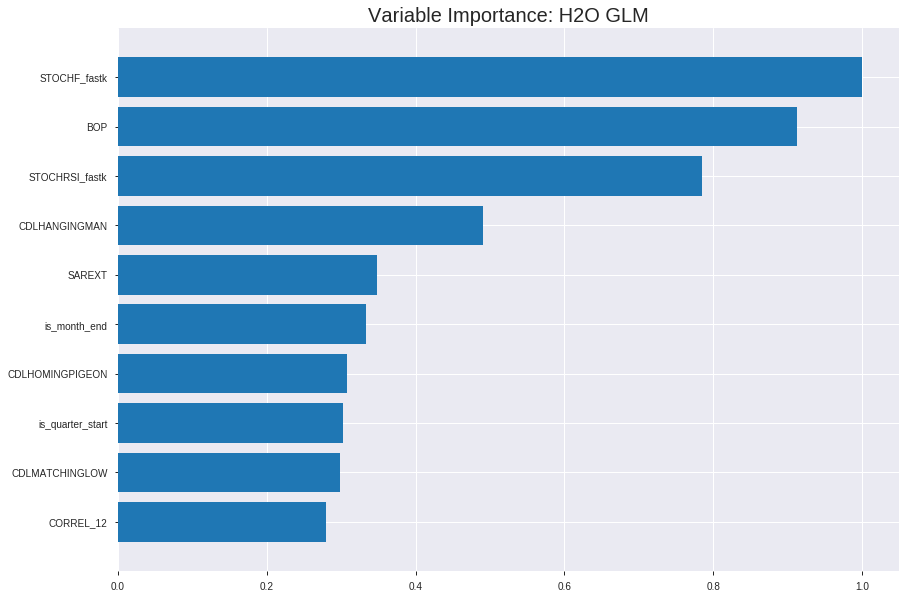

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_174256_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24824815400165867
RMSE: 0.4982450742372258
LogLoss: 0.6896398795233379
Null degrees of freedom: 4312
Residual degrees of freedom: 4263
Null deviance: 5978.575396871039
Residual deviance: 5948.833600768314
AIC: 6048.833600768314
AUC: 0.5739502015079765
pr_auc: 0.5759426371540106
Gini: 0.14790040301595297
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4757516695141109: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      38   2095  0.9822   (2095.0/2133.0)
1      13   2167  0.006    (13.0/2180.0)
Total  51   4262  0.4888   (2108.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475752     0.672772  372
max f2                       0.445263     0.836531  396
max f0point5                 0.496096     0.573388  265
max accuracy                 0.500732     0.555298  233
max precision                0.544712     0.842105  14
max recall                   0.445263     1         396
max specificity              0.59316      0.999531  0
max absolute_mcc             0.508127     0.111973  178
max min_per_class_accuracy   0.505648     0.552752  196
max mean_per_class_accuracy  0.508127     0.555534  178

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 50.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.535979           1.66369   1.66369            0.840909         0.54724   0.840909                    0.54724             0.0169725       0.0169725                  66.3688    66.3688
    2        0.0201716                   0.530819           1.3343    1.50089            0.674419         0.532895  0.758621                    0.54015             0.0133028       0.0302752                  33.4297    50.0886
    3        0.0301414                   0.529028           1.38031   1.461              0.697674         0.529749  0.738462                    0.536709            0.0137615       0.0440367                  38.0307    46.1002
    4        0.0401113                   0.52761            1.42632   1.45238            0.72093          0.52821   0.734104                    0.534597            0.0142202       0.0582569                  42.6317    45.2381
    5        0.0500812                   0.526238           1.15026   1.39224            0.581395         0.526917  0.703704                    0.533068            0.0114679       0.0697248                  15.0256    39.2236
    6        0.100162                    0.5231             0.99838   1.19531            0.50463          0.524703  0.604167                    0.528886            0.05            0.119725                   -0.162037  19.5308
    7        0.150012                    0.520944           1.22387   1.2048             0.618605         0.522034  0.608964                    0.526609            0.0610092       0.180734                   22.3872    20.48
    8        0.200093                    0.51874            1.07166   1.17148            0.541667         0.519791  0.592121                    0.524903            0.0536697       0.234404                   7.16552    17.1475
    9        0.300023                    0.514433           1.07873   1.14058            0.545244         0.51658   0.576507                    0.522131            0.107798        0.342202                   7.8732     14.0585
    10       0.399954                    0.5096             1.05578   1.1194             0.533643         0.512001  0.565797                    0.5196              0.105505        0.447706                   5.57802    11.9396
    11       0.500116                    0.505557           1.05334   1.10617            0.532407         0.5075    0.55911                     0.517176            0.105505        0.553211                   5.33363    10.6166
    12       0.600046                    0.50126            0.968564  1.08325            0.489559         0.503387  0.547527                    0.51488             0.096789        0.65                       -3.14364   8.32496
    13       0.699977                    0.497021           0.986925  1.0695             0.49884          0.499101  0.540576                    0.512627            0.0986239       0.748624                   -1.3075    6.94981
    14       0.799907                    0.491873           0.867576  1.04427            0.438515         0.494465  0.527826                    0.510358            0.0866972       0.835321                   -13.2424   4.42724
    15       0.899838                    0.487116           0.840034  1.02159            0.424594         0.489492  0.516362                    0.508041            0.083945        0.919266                   -15.9966   2.1591
    16       1                           0.438968           0.806031  1                  0.407407         0.48216   0.505449                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24950781556146337
RMSE: 0.49950757307718907
LogLoss: 0.692160985381338
Null degrees of freedom: 1231
Residual degrees of freedom: 1182
Null deviance: 1707.0147816677918
Residual deviance: 1705.484667979617
AIC: 1805.484667979617
AUC: 0.5231748838682432
pr_auc: 0.5418460924523845
Gini: 0.04634976773648636
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4672010295686039: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    586   0.9899   (586.0/592.0)
1      3    637   0.0047   (3.0/640.0)
Total  9    1223  0.4781   (589.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.467201     0.683843   391
max f2                       0.439921     0.843882   399
max f0point5                 0.482547     0.579738   349
max accuracy                 0.482612     0.534091   348
max precision                0.585557     1          0
max recall                   0.439921     1          399
max specificity              0.585557     1          0
max absolute_mcc             0.482547     0.0662827  349
max min_per_class_accuracy   0.502799     0.509375   209
max mean_per_class_accuracy  0.517845     0.523079   96

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.553722           1.33269   1.33269            0.692308         0.561192  0.692308                    0.561192            0.0140625       0.0140625                  33.2692   33.2692
    2        0.0202922                   0.544368           0.9625    1.155              0.5              0.548951  0.6                         0.555316            0.009375        0.0234375                  -3.75     15.5
    3        0.0300325                   0.536463           0.48125   0.936486           0.25             0.541663  0.486486                    0.550888            0.0046875       0.028125                   -51.875   -6.35135
    4        0.0405844                   0.52941            1.33269   1.0395             0.692308         0.531899  0.54                        0.545951            0.0140625       0.0421875                  33.2692   3.95
    5        0.0503247                   0.525977           1.12292   1.05565            0.583333         0.52716   0.548387                    0.542314            0.0109375       0.053125                   12.2917   5.56452
    6        0.100649                    0.522056           1.14879   1.10222            0.596774         0.523537  0.572581                    0.532926            0.0578125       0.110937                   14.879    10.2218
    7        0.150162                    0.519178           1.13607   1.11338            0.590164         0.520629  0.578378                    0.528871            0.05625         0.167187                   13.6066   11.3378
    8        0.200487                    0.516557           1.08669   1.10668            0.564516         0.51793   0.574899                    0.526125            0.0546875       0.221875                   8.66935   10.668
    9        0.300325                    0.511955           0.892073  1.03534            0.463415         0.514283  0.537838                    0.522188            0.0890625       0.310937                   -10.7927  3.53378
    10       0.400162                    0.507702           1.04858   1.03864            0.544715         0.509844  0.539554                    0.519108            0.104688        0.415625                   4.85772   3.8641
    11       0.5                         0.502763           0.939024  1.01875            0.487805         0.505027  0.529221                    0.516297            0.09375         0.509375                   -6.09756  1.875
    12       0.599838                    0.498511           1.01728   1.0185             0.528455         0.500815  0.529093                    0.51372             0.101562        0.610938                   1.72764   1.85047
    13       0.699675                    0.493723           1.03293   1.02056            0.536585         0.496142  0.530162                    0.511212            0.103125        0.714063                   3.29268   2.05626
    14       0.799513                    0.488709           0.954675  1.01234            0.495935         0.491091  0.525888                    0.508699            0.0953125       0.809375                   -4.53252  1.2335
    15       0.899351                    0.483428           0.985976  1.00941            0.512195         0.486186  0.524368                    0.5062              0.0984375       0.907813                   -1.40244  0.940884
    16       1                           0.439921           0.915927  1                  0.475806         0.478255  0.519481                    0.503387            0.0921


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:42:57  0.000 sec   2            4.9       49            1.38291           1.38468
    2019-08-24 17:42:57  0.015 sec   4            3         49            1.38135           1.38443
    2019-08-24 17:42:57  0.035 sec   6            1.9       50            1.37928           1.38432
    2019-08-24 17:42:57  0.055 sec   8            1.2       51            1.37678           1.38462
    2019-08-24 17:42:57  0.074 sec   10           0.73      51            1.37402           1.3857
    2019-08-24 17:42:57  0.085 sec   12           0.45      51            1.37127           1.38796
    2019-08-24 17:42:57  0.098 sec   14           0.28      51            1.36874           1.39162
    2019-08-24 17:42:57  0.112 sec   16           0.17      51            1.3666            1.3966

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5348460291734197)

('F1', 0.6710239651416122)

('auc', 0.5305663549437848)

('logloss', 0.6921120126430627)

('mean_per_class_error', 0.4655511190501209)

('rmse', 0.4994823402412882)

('mse', 0.24948260821291396)

glm prediction progress: |████████████████████████████████████████████████| 100%


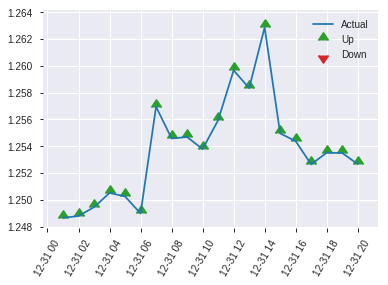


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24948260821291396
RMSE: 0.4994823402412882
LogLoss: 0.6921120126430627
Null degrees of freedom: 616
Residual degrees of freedom: 567
Null deviance: 855.3515081364842
Residual deviance: 854.0662236015394
AIC: 954.0662236015394
AUC: 0.5305663549437848
pr_auc: 0.5322082602968835
Gini: 0.06113270988756958
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4766101901592146: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    300  0.9772   (300.0/307.0)
1      2    308  0.0065   (2.0/310.0)
Total  9    608  0.4895   (302.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.47661      0.671024   390
max f2                       0.469386     0.835129   398
max f0point5                 0.47661      0.561634   390
max accuracy                 0.49983      0.534846   224
max precision                0.557394     1          0
max recall                   0.469386     1          398
max specificity              0.557394     1          0
max absolute_mcc             0.521713     0.0832979  31
max min_per_class_accuracy   0.503167     0.525806   193
max mean_per_class_accuracy  0.49983      0.534449   224

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.25 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.533835           0.852995  0.852995           0.428571         0.543491  0.428571                    0.543491            0.00967742      0.00967742                 -14.7005   -14.7005
    2        0.0210697                   0.528562           1.32688   1.07171            0.666667         0.53026   0.538462                    0.537384            0.0129032       0.0225806                  32.6882    7.17122
    3        0.0307942                   0.524038           1.6586    1.25705            0.833333         0.525371  0.631579                    0.533591            0.016129        0.0387097                  65.8602    25.7046
    4        0.0405186                   0.52359            0.995161  1.19419            0.5              0.523844  0.6                         0.531252            0.00967742      0.0483871                  -0.483871  19.4194
    5        0.0502431                   0.522794           1.32688   1.21988            0.666667         0.523089  0.612903                    0.529672            0.0129032       0.0612903                  32.6882    21.9875
    6        0.100486                    0.520116           1.02726   1.12357            0.516129         0.521297  0.564516                    0.525484            0.0516129       0.112903                   2.72633    12.3569
    7        0.150729                    0.517278           1.02726   1.09147            0.516129         0.518568  0.548387                    0.523179            0.0516129       0.164516                   2.72633    9.14672
    8        0.200972                    0.515364           1.09147   1.09147            0.548387         0.516237  0.548387                    0.521443            0.0548387       0.219355                   9.14672    9.14672
    9        0.299838                    0.511577           1.0441    1.07585            0.52459          0.513501  0.540541                    0.518825            0.103226        0.322581                   4.41036    7.585
    10       0.400324                    0.507273           0.963059  1.04754            0.483871         0.509559  0.526316                    0.516499            0.0967742       0.419355                   -3.69407   4.75382
    11       0.50081                     0.502981           1.05937   1.04991            0.532258         0.50471   0.527508                    0.514133            0.106452        0.525806                   5.93652    4.99113
    12       0.599676                    0.498169           1.0441    1.04895            0.52459          0.500959  0.527027                    0.511961            0.103226        0.629032                   4.41036    4.89538
    13       0.700162                    0.493646           0.834651  1.0182             0.419355         0.49581   0.511574                    0.509643            0.083871        0.712903                   -16.5349   1.81974
    14       0.799028                    0.488495           0.913591  1.00525            0.459016         0.491017  0.505071                    0.507339            0.0903226       0.803226                   -8.64093   0.52542
    15       0.899514                    0.484035           0.802549  0.98261            0.403226         0.486396  0.493694                    0.504999            0.0806452       0.883871                   -19.7451   -1.73903
    16       1                           0.466222           1.15567   1                  0.580645         0.479854  0.502431                    

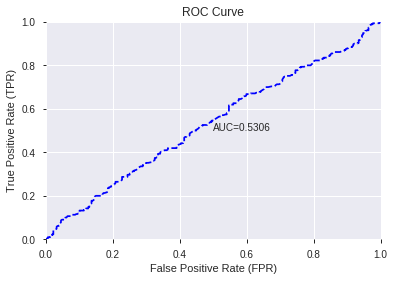

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


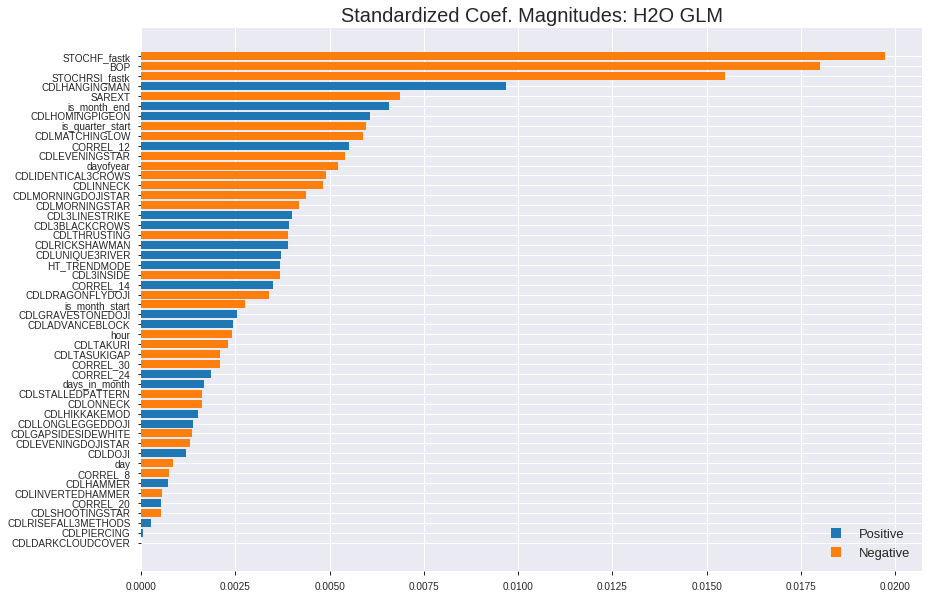

'log_likelihood'
--2019-08-24 17:43:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.20.195
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.20.195|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_174256_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_174256_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['STOCHF_fastk',
 'BOP',
 'STOCHRSI_fastk',
 'CDLHANGINGMAN',
 'SAREXT',
 'is_month_end',
 'CDLHOMINGPIGEON',
 'is_quarter_start',
 'CDLMATCHINGLOW',
 'CORREL_12',
 'CDLEVENINGSTAR',
 'dayofyear',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDL3LINESTRIKE',
 'CDL3BLACKCROWS',
 'CDLTHRUSTING',
 'CDLRICKSHAWMAN',
 'CDLUNIQUE3RIVER',
 'HT_TRENDMODE',
 'CDL3INSIDE',
 'CORREL_14',
 'CDLDRAGONFLYDOJI',
 'is_month_start',
 'CDLGRAVESTONEDOJI',
 'CDLADVANCEBLOCK',
 'hour',
 'CDLTAKURI',
 'CDLTASUKIGAP',
 'CORREL_30',
 'CORREL_24',
 'days_in_month',
 'CDLSTALLEDPATTERN',
 'CDLONNECK',
 'CDLHIKKAKEMOD',
 'CDLLONGLEGGEDDOJI',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGDOJISTAR',
 'CDLDOJI',
 'day',
 'CORREL_8',
 'CDLHAMMER',
 'CDLINVERTEDHAMMER',
 'CORREL_20',
 'CDLSHOOTINGSTAR',
 'CDLRISEFALL3METHODS',
 'CDLPIERCING',
 'CDLDARKCLOUDCOVER']

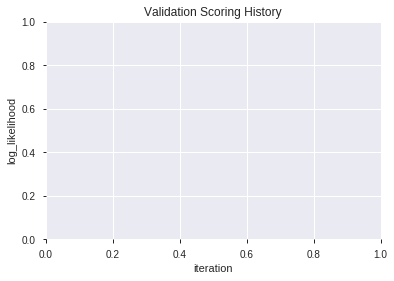

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_174314_model_4  0.565588  0.688669              0.490196  0.497755  0.247760
1  XGBoost_grid_1_AutoML_20190824_174314_model_2  0.564264  0.688358              0.491857  0.497601  0.247606
2               XGBoost_3_AutoML_20190824_174314  0.556289  0.693339              0.498371  0.500003  0.250003
3               XGBoost_2_AutoML_20190824_174314  0.554828  0.693751              0.493485  0.500094  0.250094
4  XGBoost_grid_1_AutoML_20190824_174314_model_3  0.551424  0.697317              0.485216  0.501822  0.251825
5  XGBoost_grid_1_AutoML_20190824_174314_model_6  0.550778  0.691563              0.490149  0.499157  0.249158
6               XGBoost_1_AutoML_20190824_174314  0.549133  0.695229              0.485326  0.500957  0.250958
7  XGBoost_grid_1_AutoML_20190824_174314_model_1  0.548345  0.692772              0.491857  0.499809  0.249810
8  XGBoost_grid_1_AutoML_20190824_174314_model_7  0.544930  0.695087              0.493485  0.500877  0.250878
9  XGBoost_grid_1_AutoML_20190824_174314_model_5  0.541899  0.708756              0.493470  0.506785  0.256831

variable  relative_importance  scaled_importance  percentage
0        STOCHF_fastk           632.626221           1.000000    0.183442
1                hour           527.251831           0.833433    0.152887
2                 BOP           416.263794           0.657993    0.120703
3           dayofyear           330.073212           0.521751    0.095711
4           CORREL_30           312.571564           0.494086    0.090636
5      STOCHRSI_fastk           289.377045           0.457422    0.083910
6              SAREXT           246.118439           0.389042    0.071367
7           CORREL_24           222.228668           0.351280    0.064439
8                 day           202.256317           0.319709    0.058648
9           CORREL_20           112.913765           0.178484    0.032741
10       HT_TRENDMODE            57.465302           0.090836    0.016663
11      days_in_month            32.521671           0.051407    0.009430
12          CORREL_14            24.078392           0.038061    0.006982
13          CORREL_12            18.687298           0.029539    0.005419
14       is_month_end             9.559405           0.015111    0.002772
15  CDLLONGLEGGEDDOJI             8.704619           0.013759    0.002524
16     CDLRICKSHAWMAN             5.950022           0.009405    0.001725

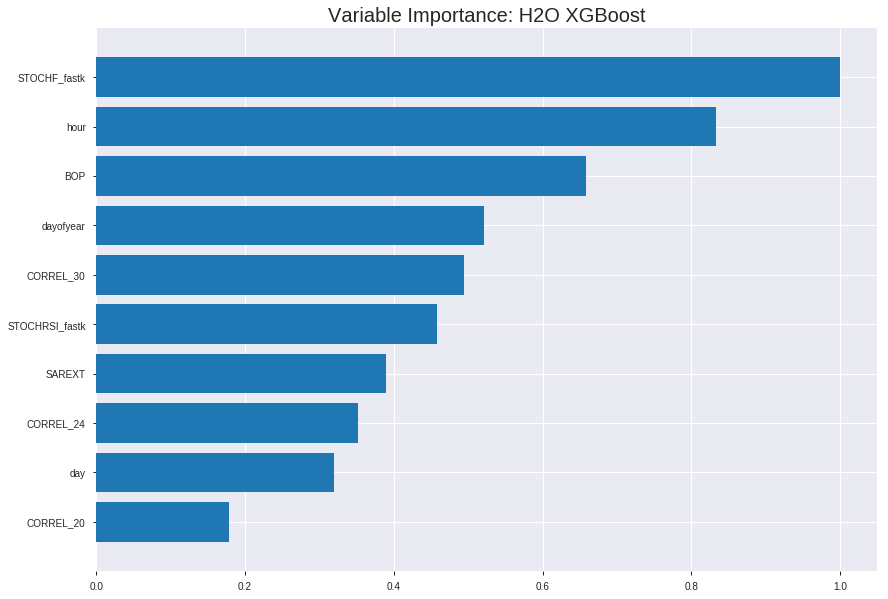

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_174314_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.23356670748754452
RMSE: 0.4832873963673629
LogLoss: 0.65980580082399
Mean Per-Class Error: 0.36432878703811233
AUC: 0.6822751476363136
pr_auc: 0.6832552810727569
Gini: 0.36455029527262717
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4642929997709062: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      751   1382  0.6479   (1382.0/2133.0)
1      315   1865  0.1445   (315.0/2180.0)
Total  1066  3247  0.3935   (1697.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464293     0.687304  266
max f2                       0.349202     0.837821  382
max f0point5                 0.503914     0.639599  206
max accuracy                 0.503914     0.635752  206
max precision                0.710008     1         0
max recall                   0.341503     1         387
max specificity              0.710008     1         0
max absolute_mcc             0.503914     0.27137   206
max min_per_class_accuracy   0.504641     0.632911  205
max mean_per_class_accuracy  0.503914     0.635671  206

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.655247           1.84355   1.84355            0.931818         0.669959  0.931818                    0.669959            0.0188073       0.0188073                  84.3547   84.3547
    2        0.0201716                   0.639078           1.74839   1.79651            0.883721         0.645999  0.908046                    0.658117            0.0174312       0.0362385                  74.8389   79.6515
    3        0.0301414                   0.628087           1.47233   1.68928            0.744186         0.633716  0.853846                    0.650046            0.0146789       0.0509174                  47.2328   68.9284
    4        0.0401113                   0.621156           1.65637   1.6811             0.837209         0.624951  0.849711                    0.643809            0.0165138       0.0674312                  65.6369   68.1103
    5        0.0500812                   0.615025           1.61036   1.66702            0.813953         0.618244  0.842593                    0.638719            0.016055        0.0834862                  61.0358   66.7019
    6        0.100162                    0.593246           1.54795   1.60748            0.782407         0.603104  0.8125                      0.620911            0.0775229       0.161009                   54.7946   60.7483
    7        0.150012                    0.576269           1.26068   1.49224            0.637209         0.584313  0.75425                     0.60875             0.062844        0.223853                   26.0681   49.2239
    8        0.200093                    0.561131           1.19073   1.41677            0.601852         0.568136  0.716107                    0.598584            0.059633        0.283486                   19.0728   41.6774
    9        0.300023                    0.536961           1.3312    1.38827            0.672854         0.548477  0.7017                      0.581895            0.133028        0.416514                   33.1201   38.8272
    10       0.399954                    0.520134           1.07873   1.31093            0.545244         0.527866  0.662609                    0.568395            0.107798        0.524312                   7.8732    31.0932
    11       0.500116                    0.504811           1.08539   1.26576            0.548611         0.512352  0.639777                    0.557171            0.108716        0.633028                   8.53944   26.5762
    12       0.600046                    0.488478           0.913479  1.20709            0.461717         0.496359  0.610124                    0.547044            0.0912844       0.724312                   -8.65206  20.7093
    13       0.699977                    0.473747           0.853805  1.15666            0.431555         0.481032  0.584631                    0.53762             0.0853211       0.809633                   -14.6195  15.6657
    14       0.799907                    0.453573           0.757408  1.10678            0.382831         0.464239  0.55942                     0.528453            0.0756881       0.885321                   -24.2592  10.678
    15       0.899838                    0.422564           0.642649  1.05524            0.324826         0.440702  0.533368                    0.518708            0.0642202       0.949541                   -35.7351  5.52362
    16       1                           0.306066           0.50377   1                  0.25463          0.388972  0.505449                    0.505713          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25099235816163734
RMSE: 0.5009913753365793
LogLoss: 0.6952223173228133
Mean Per-Class Error: 0.4669763513513513
AUC: 0.5405590160472973
pr_auc: 0.5555924439536575
Gini: 0.08111803209459456
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34212809801101685: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      17   575   0.9713   (575.0/592.0)
1      7    633   0.0109   (7.0/640.0)
Total  24   1208  0.4724   (582.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.342128     0.685065   384
max f2                       0.299942     0.844327   397
max f0point5                 0.41498      0.580956   306
max accuracy                 0.422266     0.544643   294
max precision                0.612235     0.727273   17
max recall                   0.299942     1          397
max specificity              0.686529     0.998311   0
max absolute_mcc             0.422266     0.0824213  294
max min_per_class_accuracy   0.467053     0.520312   206
max mean_per_class_accuracy  0.422266     0.533024   294

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 47.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.622188           1.18462   1.18462            0.615385         0.640642  0.615385                    0.640642            0.0125          0.0125                     18.4615   18.4615
    2        0.0202922                   0.60831            1.60417   1.386              0.833333         0.616121  0.72                        0.628872            0.015625        0.028125                   60.4167   38.6
    3        0.0300325                   0.598033           0.9625    1.24865            0.5              0.60233   0.648649                    0.620263            0.009375        0.0375                     -3.75     24.8649
    4        0.0405844                   0.592549           1.33269   1.2705             0.692308         0.595128  0.66                        0.613728            0.0140625       0.0515625                  33.2692   27.05
    5        0.0503247                   0.586226           1.44375   1.30403            0.75             0.589078  0.677419                    0.608957            0.0140625       0.065625                   44.375    30.4032
    6        0.100649                    0.566043           0.9625    1.13327            0.5              0.575963  0.58871                     0.59246             0.0484375       0.114062                   -3.75     13.3266
    7        0.150162                    0.547412           0.946721  1.07176            0.491803         0.555341  0.556757                    0.580221            0.046875        0.160938                   -5.32787  7.17568
    8        0.200487                    0.530981           1.11774   1.0833             0.580645         0.538959  0.562753                    0.569864            0.05625         0.217188                   11.7742   8.32996
    9        0.300325                    0.505204           1.11118   1.09257            0.577236         0.517535  0.567568                    0.552468            0.110937        0.328125                   11.1179   9.25676
    10       0.400162                    0.486131           0.892073  1.04255            0.463415         0.49596   0.541582                    0.53837             0.0890625       0.417187                   -10.7927  4.25456
    11       0.5                         0.466731           1.03293   1.04063            0.536585         0.476533  0.540584                    0.526022            0.103125        0.520312                   3.29268   4.0625
    12       0.599838                    0.453256           1.06423   1.04455            0.552846         0.459527  0.542625                    0.514955            0.10625         0.626563                   6.42276   4.45535
    13       0.699675                    0.439672           0.876423  1.02056            0.455285         0.446558  0.530162                    0.505195            0.0875          0.714063                   -12.3577  2.05626
    14       0.799513                    0.421891           1.17378   1.0397             0.609756         0.431318  0.540102                    0.49597             0.117188        0.83125                    17.378    3.96954
    15       0.899351                    0.395005           0.829472  1.01636            0.430894         0.409975  0.527978                    0.486423            0.0828125       0.914062                   -17.0528  1.63583
    16       1                           0.29737            0.853831  1                  0.443548         0.364558  0.519481                    0.474158            0.0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:43:24  3.569 sec   0                  0.5              0.693147            0.5             0                  1                0.494551                         0.5                0.693147              0.5               0                    1                  0.480519
    2019-08-24 17:43:24  3.661 sec   5                  0.49689          0.68694             0.625677        0.623472           1.70865          0.453049                         0.499399           0.691946              0.534836          0.554518             1.48077            0.479708
    2019-08-24 17:43:24  3.740 sec   10                 0.494614         0.68241             0.640347        0.63624            1.57376          0.438674                         0.49935            0.691848              0.536674          0.544588             1.03654            0.478896
    2019-08-24 17:43:24  3.823 sec   15                 0.492605         0.678407            0.644604        0.643632           1.66369          0.452817                         0.5002             0.693557              0.528739          0.540229             0.888462           0.474026
    2019-08-24 17:43:24  3.909 sec   20                 0.490692         0.674598            0.653143        0.652494           1.84355          0.441456                         0.500774           0.69472               0.525709          0.539652             1.03654            0.480519
    2019-08-24 17:43:24  3.991 sec   25                 0.48914          0.671491            0.654772        0.655436           1.84355          0.444702                         0.500642           0.694472              0.533831          0.54555              1.03654            0.480519
    2019-08-24 17:43:24  4.088 sec   30                 0.487683         0.668582            0.660166        0.661548           1.79858          0.444006                         0.500707           0.694604              0.534618          0.548879             1.18462            0.479708
    2019-08-24 17:43:24  4.193 sec   35                 0.48648          0.66618             0.666454        0.668769           1.84355          0.434732                         0.500626           0.694439              0.537331          0.550756             1.18462            0.479708
    2019-08-24 17:43:24  4.287 sec   40                 0.485277         0.663763            0.669593        0.67246            1.84355          0.425226                         0.500617           0.694423              0.538488          0.554146             1.18462            0.478896
    2019-08-24 17:43:24  4.386 sec   45                 0.484287         0.66178             0.674045        0.6773             1.84355          0.420821                         0.500835           0.694891              0.538975          0.555696             1.03654            0.478896
    2019-08-24 17:43:25  4.500 sec   50                 0.483287         0.659806            0.682275        0.683255           1.84355          0.393462                         0.500991           0.695222              0.540559          0.555592             1.18462            0.472403

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
STOCHF_fastk       632.626                1                    0.183442
hour               527.252                0.833433             0.152887
BOP                416.264                0.657993             0.120703
dayofyear          330.073                0.521751             0.0957109
CORREL_30          312.572                0.494086             0.090636
STOCHRSI_fastk     289.377                0.457422             0.0839103
SAREXT             246.118                0.389042             0.0713667
CORREL_24          222.229                0.35128              0.0644394
day                202.256                0.319709             0.058648
CORREL_20          112.914                0.178484             0.0327415
HT_TRENDMODE       57.4653                0.0908361            0.0166631
days_in_month      32.5217                0.0514074            0.00943027
CORREL_14          24.0784                0.038061             0.00698198
CORREL_12          18.6873                0.0295392            0.00541873
is_month_end       9.55941                0.0151107            0.00277193
CDLLONGLEGGEDDOJI  8.70462                0.0137595            0.00252407
CDLRICKSHAWMAN     5.95002                0.00940527           0.00172532

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5753646677471637)

('F1', 0.6717557251908397)

('auc', 0.5655878953451717)

('logloss', 0.6886692705570747)

('mean_per_class_error', 0.424503520016812)

('rmse', 0.49775518238866284)

('mse', 0.247760221594771)

xgboost prediction progress: |████████████████████████████████████████████| 100%


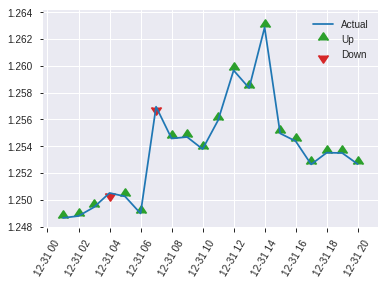


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.247760221594771
RMSE: 0.49775518238866284
LogLoss: 0.6886692705570747
Mean Per-Class Error: 0.424503520016812
AUC: 0.5655878953451717
pr_auc: 0.5517556797396796
Gini: 0.13117579069034346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33767199516296387: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    299  0.9739   (299.0/307.0)
1      2    308  0.0065   (2.0/310.0)
Total  10   607  0.4878   (301.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.337672     0.671756  389
max f2                       0.324996     0.836481  395
max f0point5                 0.47102      0.575221  209
max accuracy                 0.476617     0.575365  195
max precision                0.677009     1         0
max recall                   0.324996     1         395
max specificity              0.677009     1         0
max absolute_mcc             0.476617     0.151208  195
max min_per_class_accuracy   0.472573     0.570968  204
max mean_per_class_accuracy  0.476617     0.575496  195

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 48.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.635638           1.13733   1.13733            0.571429         0.652651  0.571429                    0.652651            0.0129032       0.0129032                  13.7327    13.7327
    2        0.0210697                   0.625298           1.32688   1.22481            0.666667         0.62767   0.615385                    0.641121            0.0129032       0.0258065                  32.6882    22.4814
    3        0.0307942                   0.619092           0.663441  1.04754            0.333333         0.62292   0.526316                    0.635374            0.00645161      0.0322581                  -33.6559   4.75382
    4        0.0405186                   0.61157            0.995161  1.03497            0.5              0.614251  0.52                        0.630304            0.00967742      0.0419355                  -0.483871  3.49677
    5        0.0502431                   0.607113           1.32688   1.09147            0.666667         0.61032   0.548387                    0.626436            0.0129032       0.0548387                  32.6882    9.14672
    6        0.100486                    0.581058           1.34828   1.21988            0.677419         0.591379  0.612903                    0.608908            0.0677419       0.122581                   34.8283    21.9875
    7        0.150729                    0.562204           1.02726   1.15567            0.516129         0.570478  0.580645                    0.596098            0.0516129       0.174194                   2.72633    15.5671
    8        0.200972                    0.542043           1.28408   1.18777            0.645161         0.551466  0.596774                    0.58494             0.0645161       0.23871                    28.4079    18.7773
    9        0.299838                    0.510818           0.848334  1.07585            0.42623          0.526821  0.540541                    0.565776            0.083871        0.322581                   -15.1666   7.585
    10       0.400324                    0.489395           1.34828   1.14423            0.677419         0.498906  0.574899                    0.548991            0.135484        0.458065                   34.8283    14.4234
    11       0.50081                     0.472234           1.12357   1.14009            0.564516         0.480822  0.572816                    0.535313            0.112903        0.570968                   12.3569    14.0088
    12       0.599676                    0.458272           0.848334  1.09199            0.42623          0.465211  0.548649                    0.523756            0.083871        0.654839                   -15.1666   9.19878
    13       0.700162                    0.445198           0.802549  1.05045            0.403226         0.45125   0.527778                    0.51335             0.0806452       0.735484                   -19.7451   5.0448
    14       0.799028                    0.428981           0.848334  1.02544            0.42623          0.436858  0.515213                    0.503885            0.083871        0.819355                   -15.1666   2.544
    15       0.899514                    0.399266           0.898855  1.0113             0.451613         0.415458  0.508108                    0.494007            0.0903226       0.909677                   -10.1145   1.1299
    16       1                           0.300991           0.898855  1                  0.451613         0.366595  0.502431                    0.4812

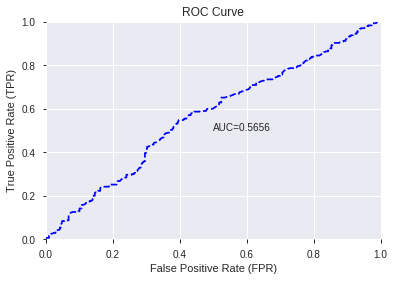

This function is available for GLM models only


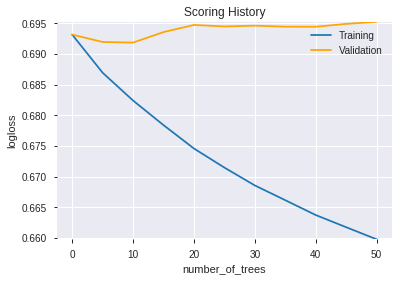

--2019-08-24 17:43:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.179.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.179.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_174314_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_174314_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCHF_fastk',
 'hour',
 'BOP',
 'dayofyear',
 'CORREL_30',
 'STOCHRSI_fastk',
 'SAREXT',
 'CORREL_24',
 'day',
 'CORREL_20',
 'HT_TRENDMODE',
 'days_in_month',
 'CORREL_14',
 'CORREL_12',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'CDLRICKSHAWMAN']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 899 935] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


11

['BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'WILLR_12',
 'WILLR_14',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'CDLCLOSINGMARUBOZU']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_174351_model_3  0.544142  0.700645              0.490196  0.503161  0.253171
1  DeepLearning_grid_1_AutoML_20190824_174351_model_7  0.542519  0.691711              0.498356  0.499241  0.249242
2  DeepLearning_grid_1_AutoML_20190824_174351_model_9  0.542251  0.691599              0.486939  0.499230  0.249231
3  DeepLearning_grid_1_AutoML_20190824_174351_model_6  0.537291  0.691982              0.498371  0.499367  0.249367
4  DeepLearning_grid_1_AutoML_20190824_174351_model_4  0.536729  0.699007              0.496711  0.502408  0.252414
5               DeepLearning_1_AutoML_20190824_174351  0.536282  0.700808              0.493485  0.503536  0.253549
6  DeepLearning_grid_1_AutoML_20190824_174351_model_5  0.535557  0.693531              0.500000  0.500161  0.250161
7  DeepLearning_grid_1_AutoML_20190824_174351_model_8  0.517406  0.692412              0.493485  0.499636  0.249636
8  DeepLearning_grid_1_AutoML_20190824_174351_model_2  0.511264  0.707692              0.490212  0.506655  0.256700
9  DeepLearning_grid_1_AutoML_20190824_174351_model_1  0.500357  0.762686              0.482006  0.529219  0.280072

variable  relative_importance  scaled_importance  percentage
0         STOCHF_fastk             1.000000           1.000000    0.112825
1                CCI_8             0.972309           0.972309    0.109701
2       STOCHRSI_fastk             0.961926           0.961926    0.108529
3               ULTOSC             0.957937           0.957937    0.108079
4                  BOP             0.908278           0.908278    0.102476
5   CDLCLOSINGMARUBOZU             0.725517           0.725517    0.081856
6              WILLR_8             0.720457           0.720457    0.081285
7             WILLR_14             0.679613           0.679613    0.076677
8                CMO_8             0.666335           0.666335    0.075179
9                RSI_8             0.654796           0.654796    0.073877
10            WILLR_12             0.616133           0.616133    0.069515

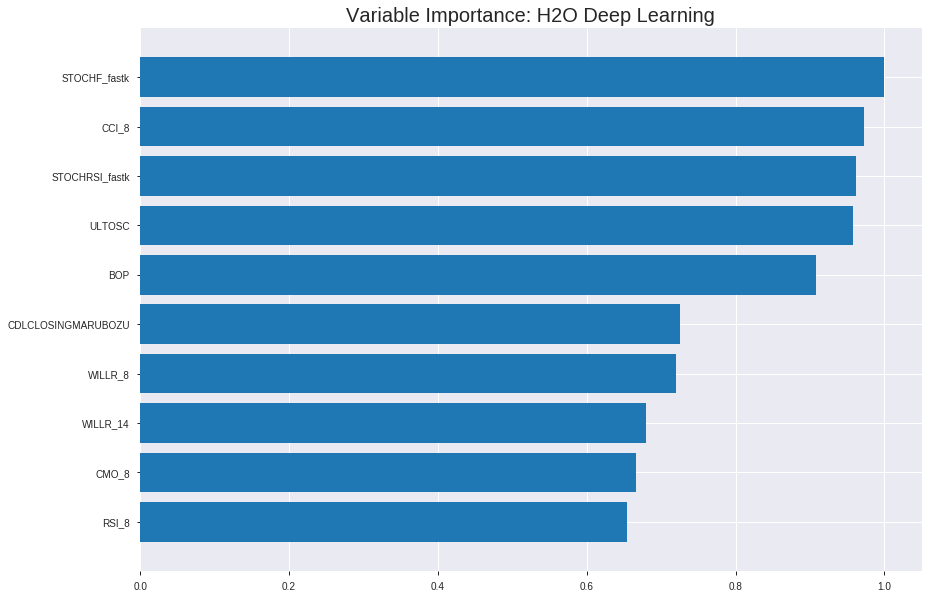

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_174351_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24314471999201054
RMSE: 0.493097069543118
LogLoss: 0.6791492269873373
Mean Per-Class Error: 0.4286302618958524
AUC: 0.5959080117162803
pr_auc: 0.5941584696584453
Gini: 0.19181602343256055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32271292219809566: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      84   2049  0.9606   (2049.0/2133.0)
1      33   2147  0.0151   (33.0/2180.0)
Total  117  4196  0.4827   (2082.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.322713     0.673463  356
max f2                       0.223856     0.83692   383
max f0point5                 0.440501     0.581783  280
max accuracy                 0.503137     0.571992  222
max precision                0.984682     1         0
max recall                   0.0893319    1         396
max specificity              0.984682     1         0
max absolute_mcc             0.503137     0.143696  222
max min_per_class_accuracy   0.513214     0.564679  212
max mean_per_class_accuracy  0.503137     0.57137   222

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 52.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.805441           1.70865   1.70865            0.863636         0.865188  0.863636                    0.865188            0.0174312       0.0174312                  70.8653   70.8653
    2        0.0201716                   0.768816           1.24228   1.47815            0.627907         0.785429  0.747126                    0.825767            0.0123853       0.0298165                  24.2277   47.8145
    3        0.0301414                   0.745093           1.15026   1.36969            0.581395         0.756972  0.692308                    0.803012            0.0114679       0.0412844                  15.0256   36.9689
    4        0.0401113                   0.723914           1.3343    1.36089            0.674419         0.734515  0.687861                    0.785986            0.0133028       0.0545872                  33.4297   36.0893
    5        0.0500812                   0.709438           1.28829   1.34644            0.651163         0.715132  0.680556                    0.771881            0.012844        0.0674312                  28.8287   34.6439
    6        0.100162                    0.659131           1.29148   1.31896            0.652778         0.68156   0.666667                    0.726721            0.0646789       0.13211                    29.1482   31.896
    7        0.150012                    0.625826           1.22387   1.28736            0.618605         0.642863  0.650696                    0.698855            0.0610092       0.193119                   22.3872   28.7362
    8        0.200093                    0.600564           0.98922   1.21274            0.5              0.611942  0.612978                    0.677101            0.0495413       0.242661                   -1.07798  21.274
    9        0.300023                    0.562026           1.11545   1.18034            0.563805         0.580791  0.5966                      0.645023            0.111468        0.354128                   11.5455   18.0337
    10       0.399954                    0.533062           1.12005   1.16527            0.566125         0.547115  0.588986                    0.62056             0.111927        0.466055                   12.0045   16.5273
    11       0.500116                    0.512504           0.98922   1.13001            0.5              0.522562  0.571164                    0.600933            0.0990826       0.565138                   -1.07798  13.0013
    12       0.600046                    0.494842           1.03283   1.11383            0.522042         0.503788  0.562983                    0.584755            0.103211        0.668349                   3.28285   11.3828
    13       0.699977                    0.470347           0.904299  1.08392            0.457077         0.483254  0.547864                    0.570264            0.090367        0.758716                   -9.57013  8.39153
    14       0.799907                    0.438394           0.92725   1.06434            0.468677         0.455113  0.537971                    0.555879            0.0926606       0.851376                   -7.27495  6.43436
    15       0.899838                    0.393302           0.78954   1.03383            0.399072         0.417492  0.522546                    0.54051             0.0788991       0.930275                   -21.046   3.38256
    16       1                           0.0454172          0.696118  1                  0.351852         0.336464  0.505449                    0.520072           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25840024049367105
RMSE: 0.5083308376379216
LogLoss: 0.7169407847588328
Mean Per-Class Error: 0.47010135135135134
AUC: 0.5239323796452703
pr_auc: 0.5287465920563215
Gini: 0.04786475929054057
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22754653007987388: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    583   0.9848   (583.0/592.0)
1      4    636   0.0063   (4.0/640.0)
Total  13   1219  0.4765   (587.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.227547     0.684239   387
max f2                       0.00957871   0.843882   399
max f0point5                 0.349589     0.578302   349
max accuracy                 0.452752     0.538961   267
max precision                0.841326     0.666667   8
max recall                   0.00957871   1          399
max specificity              0.988324     0.998311   0
max absolute_mcc             0.452752     0.0675945  267
max min_per_class_accuracy   0.512701     0.511824   206
max mean_per_class_accuracy  0.452752     0.529899   267

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 51.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.823794           0.888462  0.888462           0.461538         0.866332  0.461538                    0.866332            0.009375        0.009375                   -11.1538  -11.1538
    2        0.0202922                   0.780567           1.28333   1.078              0.666667         0.79492   0.56                        0.832054            0.0125          0.021875                   28.3333   7.8
    3        0.0300325                   0.755191           0.48125   0.884459           0.25             0.768471  0.459459                    0.811433            0.0046875       0.0265625                  -51.875   -11.5541
    4        0.0405844                   0.737335           1.18462   0.9625             0.615385         0.746055  0.5                         0.794435            0.0125          0.0390625                  18.4615   -3.75
    5        0.0503247                   0.713465           1.28333   1.0246             0.666667         0.724583  0.532258                    0.780915            0.0125          0.0515625                  28.3333   2.45968
    6        0.100649                    0.6584             0.931452  0.978024           0.483871         0.684027  0.508065                    0.732471            0.046875        0.0984375                  -6.85484  -2.19758
    7        0.150162                    0.629932           1.16762   1.04054            0.606557         0.64315   0.540541                    0.703019            0.0578125       0.15625                    16.7623   4.05405
    8        0.200487                    0.602185           0.9625    1.02095            0.5              0.615887  0.530364                    0.681148            0.0484375       0.204687                   -3.75     2.09514
    9        0.300325                    0.561321           0.923374  0.988514           0.479675         0.578476  0.513514                    0.647017            0.0921875       0.296875                   -7.6626   -1.14865
    10       0.400162                    0.536752           1.12683   1.02302            0.585366         0.549905  0.53144                     0.622788            0.1125          0.409375                   12.6829   2.30223
    11       0.5                         0.512412           1.03293   1.025              0.536585         0.524517  0.532468                    0.603166            0.103125        0.5125                     3.29268   2.5
    12       0.599838                    0.492153           1.11118   1.03934            0.577236         0.503336  0.539919                    0.58655             0.110937        0.623437                   11.1179   3.93437
    13       0.699675                    0.4645             1.00163   1.03396            0.520325         0.478737  0.537123                    0.571166            0.1             0.723437                   0.162602  3.39617
    14       0.799513                    0.428581           0.923374  1.02015            0.479675         0.447327  0.529949                    0.555702            0.0921875       0.815625                   -7.6626   2.01523
    15       0.899351                    0.381256           0.985976  1.01636            0.512195         0.407267  0.527978                    0.539224            0.0984375       0.914062                   -1.40244  1.63583
    16       1                           0.00957871         0.853831  1                  0.443548         0.320187  0.519481                    0.517178            0.0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples      training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  -----------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:45:21  0.000 sec                           0         0             0            nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:45:24  1 min 30.833 sec  18229 obs/sec     10        1             43130        0.50757          0.710542            -0.0306309     0.547678        0.54189            1.34894          0.482031                         0.511543           0.719331              -0.048296        0.521678          0.53059              1.18462            0.480519
    2019-08-24 17:45:29  1 min 36.235 sec  28167 obs/sec     50        5             215650       0.502611         0.699506            -0.0105904     0.560998        0.563662           1.52879          0.493856                         0.511997           0.720165              -0.0501584       0.511923          0.522546             0.888462           0.480519
    2019-08-24 17:45:34  1 min 41.404 sec  33998 obs/sec     100       10            431300       0.506181         0.708673            -0.0249982     0.56624         0.565377           1.57376          0.491537                         0.519787           0.741629              -0.0823575       0.51818           0.526729             1.03654            0.480519
    2019-08-24 17:45:40  1 min 47.088 sec  37762 obs/sec     160       16            690080       0.499819         0.695228            0.00060516     0.580633        0.58292            1.61872          0.492001                         0.515676           0.731996              -0.0653043       0.517634          0.522478             1.03654            0.480519
    2019-08-24 17:45:45  1 min 52.591 sec  40109 obs/sec     220       22            948860       0.496234         0.686012            0.0148898      0.589189        0.591237           1.70865          0.483654                         0.51081            0.721157              -0.0452952       0.521896          0.528648             0.888462           0.480519
    2019-08-24 17:45:51  1 min 57.911 sec  41820 obs/sec     280       28            1.20764e+06  0.493097         0.679149            0.0273056      0.595908        0.594158           1.70865          0.482727                         0.508331           0.716941              -0.0351723       0.523932          0.528747             0.888462           0.476461

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
STOCHF_fastk        1                      1                    0.112825
CCI_8               0.972309               0.972309             0.109701
STOCHRSI_fastk      0.961926               0.961926             0.108529
ULTOSC              0.957937               0.957937             0.108079
BOP                 0.908278               0.908278             0.102476
CDLCLOSINGMARUBOZU  0.725517               0.725517             0.0818563
WILLR_8             0.720457               0.720457             0.0812854
WILLR_14            0.679613               0.679613             0.0766772
CMO_8               0.666335               0.666335             0.0751792
RSI_8               0.654796               0.654796             0.0738772
WILLR_12            0.616133               0.616133             0.0695151

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5478119935170178)

('F1', 0.6717557251908397)

('auc', 0.5441420615740254)

('logloss', 0.70064492728756)

('mean_per_class_error', 0.4520962488179048)

('rmse', 0.5031606696444071)

('mse', 0.2531706594770081)

deeplearning prediction progress: |███████████████████████████████████████| 100%


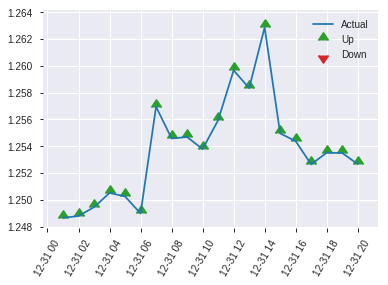


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2531706594770081
RMSE: 0.5031606696444071
LogLoss: 0.70064492728756
Mean Per-Class Error: 0.4520962488179048
AUC: 0.5441420615740254
pr_auc: 0.5434830810011102
Gini: 0.0882841231480509
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2820812841356324: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    299  0.9739   (299.0/307.0)
1      2    308  0.0065   (2.0/310.0)
Total  10   607  0.4878   (301.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.282081     0.671756  389
max f2                       0.120377     0.835129  398
max f0point5                 0.35536      0.563114  370
max accuracy                 0.517739     0.547812  205
max precision                0.843014     1         0
max recall                   0.120377     1         398
max specificity              0.843014     1         0
max absolute_mcc             0.517739     0.095873  205
max min_per_class_accuracy   0.514976     0.541935  209
max mean_per_class_accuracy  0.517739     0.547904  205

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.787554           1.42166   1.42166            0.714286         0.812125  0.714286                    0.812125            0.016129        0.016129                   42.1659    42.1659
    2        0.0210697                   0.769636           0.995161  1.22481            0.5              0.778637  0.615385                    0.796669            0.00967742      0.0258065                  -0.483871  22.4814
    3        0.0307942                   0.743212           1.6586    1.3618             0.833333         0.755277  0.684211                    0.783598            0.016129        0.0419355                  65.8602    36.18
    4        0.0405186                   0.717543           0.995161  1.27381            0.5              0.72954   0.64                        0.770624            0.00967742      0.0516129                  -0.483871  27.3806
    5        0.0502431                   0.700447           1.32688   1.28408            0.666667         0.70857   0.645161                    0.758614            0.0129032       0.0645161                  32.6882    28.4079
    6        0.100486                    0.656153           0.963059  1.12357            0.483871         0.677504  0.564516                    0.718059            0.0483871       0.112903                   -3.69407   12.3569
    7        0.150729                    0.630524           1.21988   1.15567            0.612903         0.643896  0.580645                    0.693338            0.0612903       0.174194                   21.9875    15.5671
    8        0.200972                    0.607856           0.898855  1.09147            0.451613         0.616296  0.548387                    0.674077            0.0451613       0.219355                   -10.1145   9.14672
    9        0.299838                    0.562019           1.01148   1.06509            0.508197         0.582069  0.535135                    0.64374             0.1             0.319355                   1.14754    6.50915
    10       0.400324                    0.535482           1.12357   1.07977            0.564516         0.548824  0.54251                     0.619915            0.112903        0.432258                   12.3569    7.97701
    11       0.50081                     0.513482           1.09147   1.08212            0.548387         0.523329  0.543689                    0.600535            0.109677        0.541935                   9.14672    8.21171
    12       0.599676                    0.497133           0.946219  1.05971            0.47541          0.505067  0.532432                    0.584796            0.0935484       0.635484                   -5.37811   5.97123
    13       0.700162                    0.46928            1.02726   1.05506            0.516129         0.484483  0.530093                    0.570399            0.103226        0.73871                    2.72633    5.50553
    14       0.799028                    0.438859           0.717821  1.01333            0.360656         0.456179  0.509128                    0.556266            0.0709677       0.809677                   -28.2179   1.33285
    15       0.899514                    0.395817           0.995161  1.0113             0.5              0.417055  0.508108                    0.540715            0.1             0.909677                   -0.483871  1.1299
    16       1                           0.109312           0.898855  1                  0.451613         0.331671  0.502431                    0.5

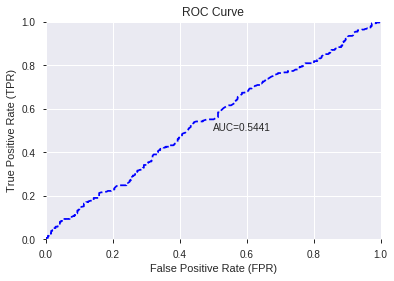

This function is available for GLM models only


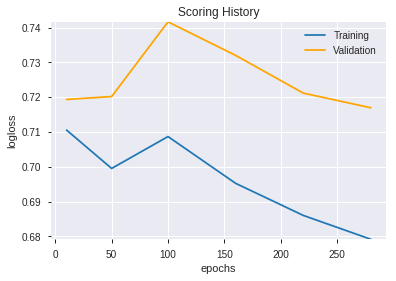

--2019-08-24 18:01:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_174351_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_174351_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHF_fastk',
 'CCI_8',
 'STOCHRSI_fastk',
 'ULTOSC',
 'BOP',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'WILLR_14',
 'CMO_8',
 'RSI_8',
 'WILLR_12']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190824_180114_model_1  0.530509  0.691237              0.493485  0.49905  0.249051

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             0.021264           1.000000    0.146269
1                  BOP             0.020725           0.974629    0.142558
2         STOCHF_fastk             0.020012           0.941122    0.137657
3       STOCHRSI_fastk             0.016181           0.760930    0.111300
4               ULTOSC             0.014081           0.662191    0.096858
5              WILLR_8             0.012728           0.598579    0.087553
6                CCI_8             0.010316           0.485152    0.070963
7             WILLR_12             0.007786           0.366149    0.053556
8             WILLR_14             0.007775           0.365644    0.053482
9                CMO_8             0.007265           0.341636    0.049971
10               RSI_8             0.007245           0.340695    0.049833

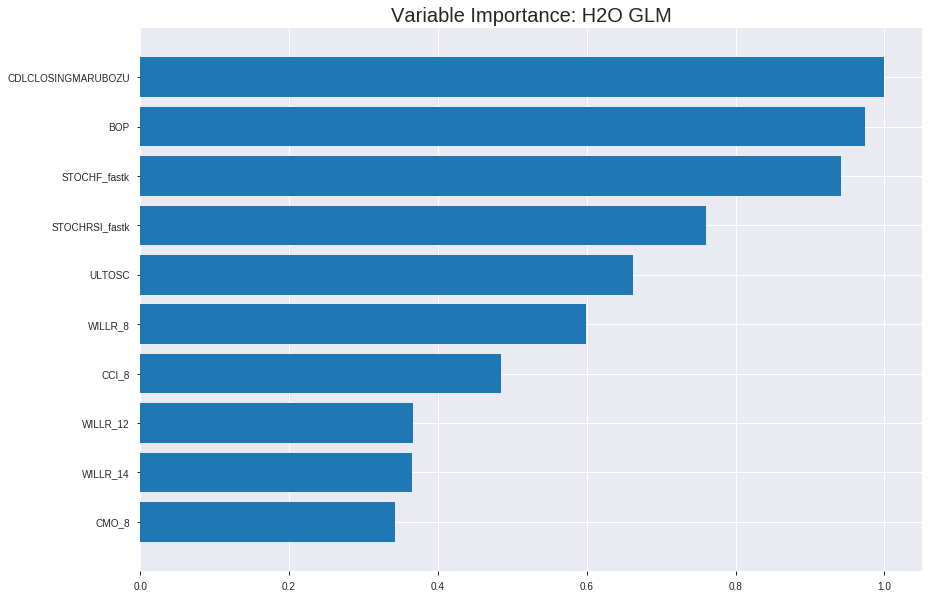

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_180114_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24788275900734835
RMSE: 0.49787825721490225
LogLoss: 0.6889026335608389
Null degrees of freedom: 4312
Residual degrees of freedom: 4301
Null deviance: 5978.575396871039
Residual deviance: 5942.474117095799
AIC: 5966.474117095799
AUC: 0.5580104259409798
pr_auc: 0.5565625792396395
Gini: 0.11602085188195965
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43679767012150506: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      4    2129  0.9981   (2129.0/2133.0)
1      1    2179  0.0005   (1.0/2180.0)
Total  5    4308  0.4939   (2130.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.436798     0.671702   396
max f2                       0.43418      0.836339   399
max f0point5                 0.483808     0.566963   284
max accuracy                 0.507476     0.544633   194
max precision                0.579039     1          0
max recall                   0.43418      1          399
max specificity              0.579039     1          0
max absolute_mcc             0.525873     0.0937261  125
max min_per_class_accuracy   0.50451      0.53945    205
max mean_per_class_accuracy  0.507476     0.545074   194

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 50.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.567324           1.48383   1.48383            0.75             0.571421  0.75                        0.571421            0.0151376       0.0151376                  48.383     48.383
    2        0.0201716                   0.55994            1.01223   1.25074            0.511628         0.56338   0.632184                    0.567447            0.0100917       0.0252294                  1.22253    25.0738
    3        0.0301414                   0.555884           1.24228   1.24794            0.627907         0.557647  0.630769                    0.564205            0.0123853       0.0376147                  24.2277    24.7939
    4        0.0401113                   0.55261            1.10425   1.21222            0.55814          0.554034  0.612717                    0.561677            0.0110092       0.0486239                  10.4246    21.2224
    5        0.0500812                   0.550249           1.10425   1.19073            0.55814          0.551529  0.601852                    0.559657            0.0110092       0.059633                   10.4246    19.0728
    6        0.100162                    0.542835           1.14493   1.16783            0.578704         0.546452  0.590278                    0.553054            0.0573394       0.116972                   14.4931    16.7829
    7        0.150012                    0.537274           1.05824   1.13141            0.534884         0.540088  0.57187                     0.548746            0.0527523       0.169725                   5.82355    13.1411
    8        0.200093                    0.53163            1.20905   1.15084            0.611111         0.534516  0.581692                    0.545184            0.0605505       0.230275                   20.9047    15.0842
    9        0.300023                    0.521938           1.0925    1.13141            0.552204         0.526575  0.57187                     0.538986            0.109174        0.33945                    9.2503     13.1411
    10       0.399954                    0.512764           1.0007    1.09875            0.5058           0.517217  0.555362                    0.533547            0.1             0.43945                    0.0696056  9.87512
    11       0.500116                    0.504355           1.00296   1.07957            0.506944         0.508461  0.545665                    0.528523            0.100459        0.539908                   0.295935   7.95662
    12       0.600046                    0.496457           0.991515  1.0649             0.50116          0.500602  0.538253                    0.523873            0.0990826       0.638991                   -0.848464  6.49024
    13       0.699977                    0.4886             0.945612  1.04787            0.477958         0.492478  0.529646                    0.519391            0.0944954       0.733486                   -5.43881   4.78722
    14       0.799907                    0.480146           0.945612  1.0351             0.477958         0.48447   0.523188                    0.515028            0.0944954       0.827982                   -5.43881   3.50971
    15       0.899838                    0.468971           0.904299  1.02057            0.457077         0.474978  0.515846                    0.510581            0.090367        0.918349                   -9.57013   2.05714
    16       1                           0.434041           0.815191  1                  0.412037         0.459344  0.505449                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24929577558434296
RMSE: 0.4992952789525883
LogLoss: 0.6917355901532752
Null degrees of freedom: 1231
Residual degrees of freedom: 1220
Null deviance: 1707.0147816677918
Residual deviance: 1704.4364941376703
AIC: 1728.4364941376703
AUC: 0.5270428631756756
pr_auc: 0.5411295744176289
Gini: 0.054085726351351227
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44478446854505815: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      8    584   0.9865   (584.0/592.0)
1      3    637   0.0047   (3.0/640.0)
Total  11   1221  0.4765   (587.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.444784     0.684578   388
max f2                       0.433098     0.843882   399
max f0point5                 0.465207     0.578866   346
max accuracy                 0.493215     0.534091   236
max precision                0.575643     1          0
max recall                   0.433098     1          399
max specificity              0.575643     1          0
max absolute_mcc             0.530554     0.0699733  95
max min_per_class_accuracy   0.50325      0.520312   201
max mean_per_class_accuracy  0.493215     0.530089   236

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.566537           1.03654   1.03654            0.538462         0.57153   0.538462                    0.57153             0.0109375       0.0109375                  3.65385   3.65385
    2        0.0202922                   0.55629            1.12292   1.078              0.583333         0.561781  0.56                        0.566851            0.0109375       0.021875                   12.2917   7.8
    3        0.0300325                   0.553224           1.28333   1.14459            0.666667         0.554835  0.594595                    0.562954            0.0125          0.034375                   28.3333   14.4595
    4        0.0405844                   0.551406           1.03654   1.1165             0.538462         0.552399  0.58                        0.560209            0.0109375       0.0453125                  3.65385   11.65
    5        0.0503247                   0.549705           1.12292   1.11774            0.583333         0.550552  0.580645                    0.55834             0.0109375       0.05625                    12.2917   11.7742
    6        0.100649                    0.541056           1.05565   1.08669            0.548387         0.545346  0.564516                    0.551843            0.053125        0.109375                   5.56452   8.66935
    7        0.150162                    0.535414           1.13607   1.10297            0.590164         0.538278  0.572973                    0.54737             0.05625         0.165625                   13.6066   10.2973
    8        0.200487                    0.529683           1.21089   1.13006            0.629032         0.53233   0.587045                    0.543595            0.0609375       0.226562                   21.0887   13.0061
    9        0.300325                    0.52023            0.892073  1.05095            0.463415         0.524715  0.545946                    0.537319            0.0890625       0.315625                   -10.7927  5.09459
    10       0.400162                    0.511028           0.954675  1.02693            0.495935         0.515674  0.533469                    0.531919            0.0953125       0.410938                   -4.53252  2.6927
    11       0.5                         0.50281            1.09553   1.04063            0.569106         0.506689  0.540584                    0.526881            0.109375        0.520312                   9.55285   4.0625
    12       0.599838                    0.493288           1.06423   1.04455            0.552846         0.498443  0.542625                    0.522148            0.10625         0.626563                   6.42276   4.45535
    13       0.699675                    0.484782           0.829472  1.01386            0.430894         0.489424  0.526682                    0.517478            0.0828125       0.709375                   -17.0528  1.38631
    14       0.799513                    0.475986           0.970325  1.00843            0.504065         0.480268  0.523858                    0.512832            0.096875        0.80625                    -2.96748  0.84264
    15       0.899351                    0.466575           1.03293   1.01115            0.536585         0.471527  0.525271                    0.508246            0.103125        0.909375                   3.29268   1.11462
    16       1                           0.433098           0.900403  1                  0.467742         0.45814   0.519481                    0.503203            0.090


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 18:01:15  0.000 sec   2            4.9       12            1.38196           1.38398
    2019-08-24 18:01:15  0.010 sec   4            3         12            1.38058           1.38366
    2019-08-24 18:01:15  0.021 sec   6            1.9       12            1.37915           1.38348
    2019-08-24 18:01:15  0.028 sec   8            1.2       12            1.37781           1.38347
    2019-08-24 18:01:15  0.035 sec   10           0.73      12            1.37662           1.3836
    2019-08-24 18:01:15  0.040 sec   12           0.45      12            1.37561           1.38379
    2019-08-24 18:01:15  0.047 sec   14           0.28      12            1.37479           1.384
    2019-08-24 18:01:15  0.053 sec   16           0.17      12            1.37414           1.3842
    2019-08-24 18:01:15  0.057 sec   17           0.11      12            1.37364           1.38437

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5380875202593193)

('F1', 0.6717226435536294)

('auc', 0.5305085636229905)

('logloss', 0.6912374657099617)

('mean_per_class_error', 0.46041819901229375)

('rmse', 0.4990496761978552)

('mse', 0.2490505793131841)

glm prediction progress: |████████████████████████████████████████████████| 100%


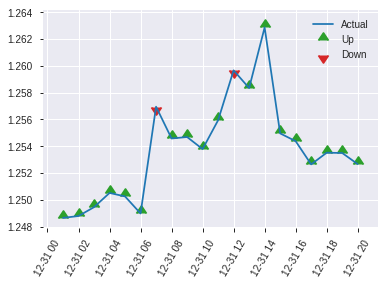


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2490505793131841
RMSE: 0.4990496761978552
LogLoss: 0.6912374657099617
Null degrees of freedom: 616
Residual degrees of freedom: 605
Null deviance: 855.3515081364842
Residual deviance: 852.9870326860927
AIC: 876.9870326860927
AUC: 0.5305085636229905
pr_auc: 0.5400611055434733
Gini: 0.06101712724598096
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4410568883038776: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    303  0.987    (303.0/307.0)
1      0    310  0        (0.0/310.0)
Total  4    613  0.4911   (303.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.441057     0.671723  395
max f2                       0.441057     0.836481  395
max f0point5                 0.461678     0.56367   373
max accuracy                 0.534429     0.538088  81
max precision                0.574446     1         0
max recall                   0.441057     1         395
max specificity              0.574446     1         0
max absolute_mcc             0.534429     0.10032   81
max min_per_class_accuracy   0.507215     0.503226  198
max mean_per_class_accuracy  0.534429     0.539582  81

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.568436           1.70599   1.70599            0.857143         0.571442  0.857143                    0.571442            0.0193548       0.0193548                  70.5991    70.5991
    2        0.0210697                   0.558706           0.995161  1.37792            0.5              0.561419  0.692308                    0.566816            0.00967742      0.0290323                  -0.483871  37.7916
    3        0.0307942                   0.555979           0.995161  1.25705            0.5              0.557637  0.631579                    0.563917            0.00967742      0.0387097                  -0.483871  25.7046
    4        0.0405186                   0.552047           1.32688   1.27381            0.666667         0.553435  0.64                        0.561402            0.0129032       0.0516129                  32.6882    27.3806
    5        0.0502431                   0.550507           1.32688   1.28408            0.666667         0.551324  0.645161                    0.559451            0.0129032       0.0645161                  32.6882    28.4079
    6        0.100486                    0.544546           1.02726   1.15567            0.516129         0.546964  0.580645                    0.553207            0.0516129       0.116129                   2.72633    15.5671
    7        0.150729                    0.537467           1.21988   1.17707            0.612903         0.541007  0.591398                    0.549141            0.0612903       0.177419                   21.9875    17.7072
    8        0.200972                    0.533645           1.09147   1.15567            0.548387         0.535615  0.580645                    0.545759            0.0548387       0.232258                   9.14672    15.5671
    9        0.299838                    0.524943           0.880962  1.06509            0.442623         0.529154  0.535135                    0.540284            0.0870968       0.319355                   -11.9038   6.50915
    10       0.400324                    0.516181           0.995161  1.04754            0.5              0.520561  0.526316                    0.535333            0.1             0.419355                   -0.483871  4.75382
    11       0.50081                     0.507087           0.866753  1.01126            0.435484         0.511387  0.508091                    0.530529            0.0870968       0.506452                   -13.3247   1.12642
    12       0.599676                    0.500206           1.10936   1.02744            0.557377         0.503654  0.516216                    0.526098            0.109677        0.616129                   10.936     2.74368
    13       0.700162                    0.490218           1.02726   1.02741            0.516129         0.494903  0.516204                    0.521621            0.103226        0.719355                   2.72633    2.74119
    14       0.799028                    0.481769           0.848334  1.00525            0.42623          0.486053  0.505071                    0.51722             0.083871        0.803226                   -15.1666   0.52542
    15       0.899514                    0.470261           1.02726   1.00771            0.516129         0.476314  0.506306                    0.51265             0.103226        0.906452                   2.72633    0.771287
    16       1                           0.432644           0.930957  1                  0.467742         0.459162  0.502431                   

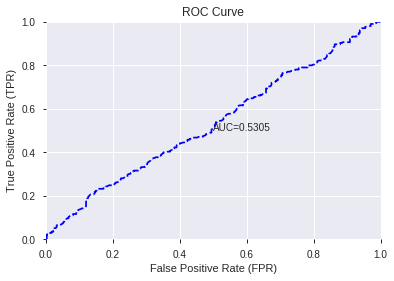

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


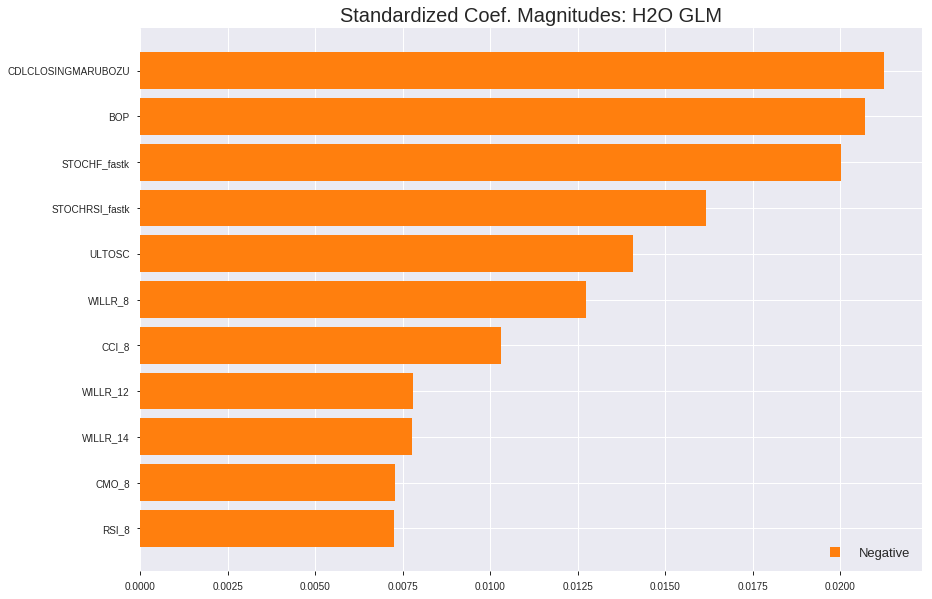

'log_likelihood'
--2019-08-24 18:01:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_180114_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_180114_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLCLOSINGMARUBOZU',
 'BOP',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'ULTOSC',
 'WILLR_8',
 'CCI_8',
 'WILLR_12',
 'WILLR_14',
 'CMO_8',
 'RSI_8']

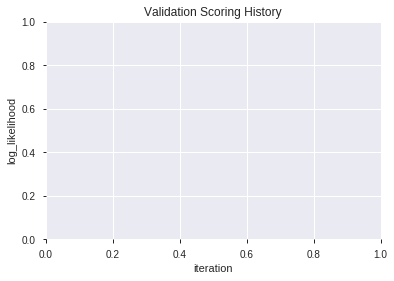

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_180132_model_3  0.557907  0.689466              0.496727  0.498129  0.248133
1  XGBoost_grid_1_AutoML_20190824_180132_model_6  0.549564  0.692585              0.498371  0.499619  0.249619
2  XGBoost_grid_1_AutoML_20190824_180132_model_4  0.543475  0.691949              0.498371  0.499365  0.249366
3  XGBoost_grid_1_AutoML_20190824_180132_model_1  0.543097  0.695588              0.500000  0.500960  0.250961
4  XGBoost_grid_1_AutoML_20190824_180132_model_2  0.539104  0.692786              0.498371  0.499781  0.249781
5               XGBoost_1_AutoML_20190824_180132  0.535715  0.697266              0.490165  0.501881  0.251884
6               XGBoost_2_AutoML_20190824_180132  0.533356  0.698370              0.500000  0.502421  0.252427
7               XGBoost_3_AutoML_20190824_180132  0.523705  0.697231              0.498371  0.501928  0.251931
8  XGBoost_grid_1_AutoML_20190824_180132_model_7  0.519397  0.703182              0.498371  0.504734  0.254756
9  XGBoost_grid_1_AutoML_20190824_180132_model_5  0.509462  0.720499              0.495114  0.512380  0.262533

variable  relative_importance  scaled_importance  percentage
0         STOCHF_fastk           647.473267           1.000000    0.155720
1               ULTOSC           550.641602           0.850447    0.132431
2                  BOP           548.197083           0.846671    0.131844
3                CCI_8           441.516937           0.681908    0.106187
4              WILLR_8           409.549103           0.632534    0.098498
5                CMO_8           394.465057           0.609238    0.094870
6             WILLR_12           391.832642           0.605172    0.094237
7             WILLR_14           387.072876           0.597821    0.093093
8                RSI_8           176.982697           0.273344    0.042565
9       STOCHRSI_fastk           167.866409           0.259264    0.040373
10  CDLCLOSINGMARUBOZU            42.337868           0.065389    0.010182

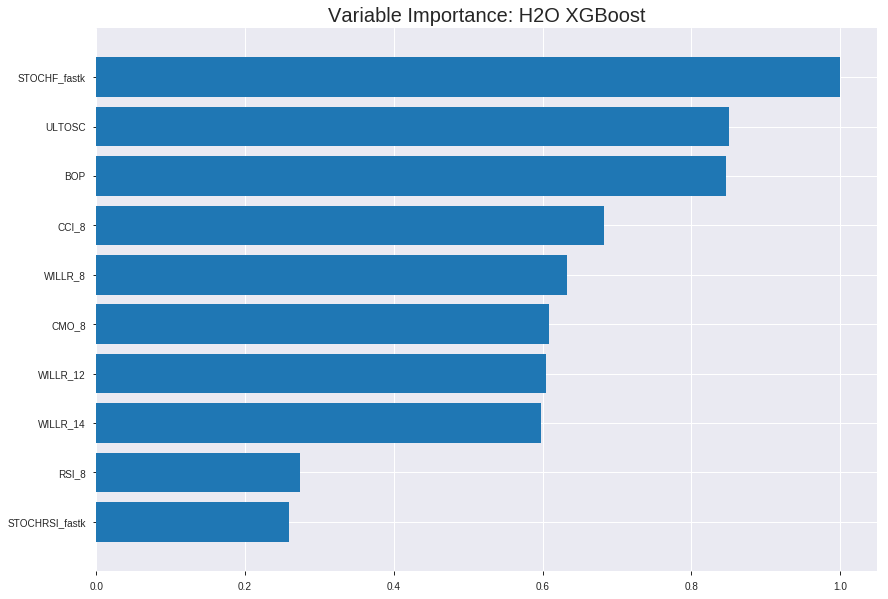

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_180132_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.22793702989761477
RMSE: 0.4774275127154014
LogLoss: 0.6480615834098566
Mean Per-Class Error: 0.32733723445893925
AUC: 0.7299156548256537
pr_auc: 0.7341596493739599
Gini: 0.45983130965130736
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46490618288517: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      742  1391  0.6521   (1391.0/2133.0)
1      227  1953  0.1041   (227.0/2180.0)
Total  969  3344  0.3751   (1618.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464906     0.707096  255
max f2                       0.350181     0.840421  353
max f0point5                 0.512449     0.678485  180
max accuracy                 0.508804     0.672386  186
max precision                0.79699      1         0
max recall                   0.283883     1         379
max specificity              0.79699      1         0
max absolute_mcc             0.508804     0.345688  186
max min_per_class_accuracy   0.504692     0.667431  192
max mean_per_class_accuracy  0.508804     0.672663  186

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 50.55 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.684173           1.88851   1.88851            0.954545         0.716829  0.954545                    0.716829            0.0192661       0.0192661                  88.8511   88.8511
    2        0.0201716                   0.64997            1.88642   1.88748            0.953488         0.665439  0.954023                    0.691429            0.0188073       0.0380734                  88.642    88.7478
    3        0.0301414                   0.631094           1.7944    1.85669            0.906977         0.638203  0.938462                    0.673824            0.0178899       0.0559633                  79.4399   85.669
    4        0.0401113                   0.619284           1.88642   1.86408            0.953488         0.62468   0.942197                    0.661609            0.0188073       0.0747706                  88.642    86.408
    5        0.0500812                   0.61345            1.84041   1.85937            0.930233         0.61615   0.939815                    0.652559            0.0183486       0.0931193                  84.041    85.9368
    6        0.100162                    0.586163           1.59374   1.72656            0.805556         0.598903  0.872685                    0.625731            0.0798165       0.172936                   59.3744   72.6556
    7        0.150012                    0.569116           1.40791   1.62067            0.711628         0.577217  0.819165                    0.60961             0.0701835       0.243119                   40.7913   62.067
    8        0.200093                    0.554629           1.34644   1.55203            0.680556         0.561676  0.784473                    0.597612            0.0674312       0.31055                    34.6439   55.2033
    9        0.300023                    0.534956           1.27612   1.46013            0.645012         0.54482   0.738022                    0.580029            0.127523        0.438073                   27.6117   46.0132
    10       0.399954                    0.519533           1.25317   1.40842            0.633411         0.526762  0.711884                    0.56672             0.125229        0.563303                   25.3165   40.842
    11       0.500116                    0.504643           1.03044   1.33272            0.520833         0.512106  0.673621                    0.555782            0.103211        0.666514                   3.04377   33.2719
    12       0.600046                    0.491547           0.954793  1.26978            0.482599         0.498137  0.641808                    0.546182            0.0954128       0.761927                   -4.52074  26.978
    13       0.699977                    0.476559           0.739046  1.19401            0.37355          0.484508  0.603511                    0.537377            0.0738532       0.83578                    -26.0954  19.4011
    14       0.799907                    0.459677           0.743637  1.13775            0.37587          0.46861   0.575072                    0.528786            0.0743119       0.910092                   -25.6363  13.7747
    15       0.899838                    0.428978           0.546252  1.07206            0.276102         0.445814  0.541871                    0.519572            0.0545872       0.964679                   -45.3748  7.20588
    16       1                           0.178059           0.352639  1                  0.178241         0.378867  0.505449                    0.505478            0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25166400445175685
RMSE: 0.5016612447177446
LogLoss: 0.6968876325099921
Mean Per-Class Error: 0.463745777027027
AUC: 0.5277554898648649
pr_auc: 0.5312562453111727
Gini: 0.05551097972972974
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22819969058036804: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    592   1        (592.0/592.0)
1      0    640   0        (0.0/640.0)
Total  0    1232  0.4805   (592.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.2282       0.683761   399
max f2                       0.2282       0.843882   399
max f0point5                 0.364149     0.577848   367
max accuracy                 0.467266     0.536526   265
max precision                0.670706     0.615385   12
max recall                   0.2282       1          399
max specificity              0.776643     0.998311   0
max absolute_mcc             0.5075       0.0726144  189
max min_per_class_accuracy   0.502747     0.528716   198
max mean_per_class_accuracy  0.5075       0.536254   189

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.670555           1.18462   1.18462            0.615385         0.711724  0.615385                    0.711724            0.0125          0.0125                     18.4615   18.4615
    2        0.0202922                   0.649777           0.48125   0.847              0.25             0.663132  0.44                        0.6884              0.0046875       0.0171875                  -51.875   -15.3
    3        0.0300325                   0.634391           0.9625    0.884459           0.5              0.641442  0.459459                    0.67317             0.009375        0.0265625                  -3.75     -11.5541
    4        0.0405844                   0.614669           1.48077   1.0395             0.769231         0.627599  0.54                        0.661322            0.015625        0.0421875                  48.0769   3.95
    5        0.0503247                   0.608624           0.9625    1.0246             0.5              0.611553  0.532258                    0.651689            0.009375        0.0515625                  -3.75     2.45968
    6        0.100649                    0.578332           0.807258  0.915927           0.419355         0.591666  0.475806                    0.621677            0.040625        0.0921875                  -19.2742  -8.40726
    7        0.150162                    0.56438            1.16762   0.998919           0.606557         0.571523  0.518919                    0.60514             0.0578125       0.15                       16.7623   -0.108108
    8        0.200487                    0.554966           1.08669   1.02095            0.564516         0.55947   0.530364                    0.593676            0.0546875       0.204687                   8.66935   2.09514
    9        0.300325                    0.533977           1.12683   1.05615            0.585366         0.543459  0.548649                    0.576982            0.1125          0.317188                   12.6829   5.61486
    10       0.400162                    0.52054            0.985976  1.03864            0.512195         0.527234  0.539554                    0.56457             0.0984375       0.415625                   -1.40244  3.8641
    11       0.5                         0.50274            1.14248   1.05938            0.593496         0.510801  0.550325                    0.553834            0.114062        0.529687                   14.248    5.9375
    12       0.599838                    0.488572           0.923374  1.03674            0.479675         0.495767  0.538566                    0.544169            0.0921875       0.621875                   -7.6626   3.67388
    13       0.699675                    0.474245           1.00163   1.03173            0.520325         0.480916  0.535963                    0.535144            0.1             0.721875                   0.162602  3.17285
    14       0.799513                    0.455906           0.923374  1.0182             0.479675         0.465837  0.528934                    0.526489            0.0921875       0.814063                   -7.6626   1.8198
    15       0.899351                    0.426854           0.985976  1.01462            0.512195         0.443627  0.527076                    0.51729             0.0984375       0.9125                     -1.40244  1.46209
    16       1                           0.2282             0.869355  1                  0.451613         0.375576  0.519481                    0.503027            0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:01:39  2.062 sec   0                  0.5              0.693147            0.5             0                  1                0.494551                         0.5                0.693147              0.5               0                    1                  0.480519
    2019-08-24 18:01:39  2.148 sec   5                  0.49725          0.687652            0.607495        0.600037           1.70865          0.467424                         0.499448           0.692046              0.539992          0.54581              1.20313            0.480519
    2019-08-24 18:01:39  2.225 sec   10                 0.493869         0.680907            0.643465        0.642453           1.66369          0.435428                         0.499522           0.692209              0.536308          0.537192             0.888462           0.480519
    2019-08-24 18:01:39  2.348 sec   15                 0.49099          0.675172            0.666148        0.666457           1.79858          0.424762                         0.499927           0.693034              0.529558          0.5333               0.888462           0.480519
    2019-08-24 18:01:39  2.443 sec   20                 0.488782         0.670744            0.674557        0.673723           1.79858          0.415256                         0.500734           0.694709              0.521953          0.524329             1.03654            0.480519
    2019-08-24 18:01:40  2.530 sec   25                 0.48638          0.665923            0.685958        0.68876            1.88851          0.399722                         0.50086            0.695017              0.525901          0.525814             1.03654            0.475649
    2019-08-24 18:01:40  2.610 sec   30                 0.484399         0.662004            0.700297        0.700778           1.88851          0.391143                         0.501335           0.69601               0.521387          0.524643             0.888462           0.476461
    2019-08-24 18:01:40  2.702 sec   35                 0.482497         0.658172            0.709063        0.7122             1.88851          0.380709                         0.501354           0.696137              0.523123          0.529183             1.03654            0.480519
    2019-08-24 18:01:40  2.813 sec   40                 0.48054          0.654296            0.716888        0.718905           1.93348          0.380478                         0.500991           0.695425              0.529385          0.533137             0.888462           0.472403
    2019-08-24 18:01:40  2.910 sec   45                 0.478798         0.650807            0.725235        0.72852            1.97844          0.386738                         0.501357           0.696251              0.529847          0.531459             0.740385           0.480519
    2019-08-24 18:01:40  3.007 sec   50                 0.477428         0.648062            0.729916        0.73416            1.88851          0.375145                         0.501661           0.696888              0.527755          0.531256             1.18462            0.480519

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ------------
STOCHF_fastk        647.473                1                    0.15572
ULTOSC              550.642                0.850447             0.132431
BOP                 548.197                0.846671             0.131844
CCI_8               441.517                0.681908             0.106187
WILLR_8             409.549                0.632534             0.0984982
CMO_8               394.465                0.609238             0.0948704
WILLR_12            391.833                0.605172             0.0942373
WILLR_14            387.073                0.597821             0.0930926
RSI_8               176.983                0.273344             0.042565
STOCHRSI_fastk      167.866                0.259264             0.0403725
CDLCLOSINGMARUBOZU  42.3379                0.0653894            0.0101824

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5575364667747164)

('F1', 0.6695557963163598)

('auc', 0.5579069034359567)

('logloss', 0.6894661999422995)

('mean_per_class_error', 0.44273405484921713)

('rmse', 0.49812939587597505)

('mse', 0.24813289503576386)

xgboost prediction progress: |████████████████████████████████████████████| 100%


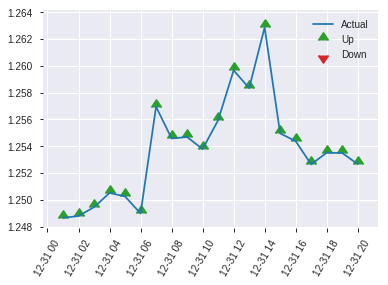


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24813289503576386
RMSE: 0.49812939587597505
LogLoss: 0.6894661999422995
Mean Per-Class Error: 0.44273405484921713
AUC: 0.5579069034359567
pr_auc: 0.5638781131154649
Gini: 0.11581380687191345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3178071677684784: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    304  0.9902   (304.0/307.0)
1      1    309  0.0032   (1.0/310.0)
Total  4    613  0.4943   (305.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317807     0.669556  395
max f2                       0.247117     0.835129  398
max f0point5                 0.498341     0.564804  223
max accuracy                 0.498341     0.557536  223
max precision                0.70541      1         0
max recall                   0.247117     1         398
max specificity              0.70541      1         0
max absolute_mcc             0.498341     0.115253  223
max min_per_class_accuracy   0.507496     0.547231  206
max mean_per_class_accuracy  0.498341     0.557266  223

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.57 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.667573           1.42166   1.42166            0.714286         0.680644  0.714286                    0.680644            0.016129        0.016129                   42.1659    42.1659
    2        0.0210697                   0.647221           0.995161  1.22481            0.5              0.65466   0.615385                    0.668651            0.00967742      0.0258065                  -0.483871  22.4814
    3        0.0307942                   0.629373           1.32688   1.25705            0.666667         0.637495  0.631579                    0.658812            0.0129032       0.0387097                  32.6882    25.7046
    4        0.0405186                   0.616342           1.6586    1.35342            0.833333         0.623146  0.68                        0.650252            0.016129        0.0548387                  65.8602    35.3419
    5        0.0502431                   0.603822           1.99032   1.47669            1                0.610492  0.741935                    0.642557            0.0193548       0.0741935                  99.0323    47.6691
    6        0.100486                    0.58102            1.02726   1.25198            0.516129         0.590559  0.629032                    0.616558            0.0516129       0.125806                   2.72633    25.1977
    7        0.150729                    0.564093           1.09147   1.19847            0.548387         0.572738  0.602151                    0.601951            0.0548387       0.180645                   9.14672    19.8474
    8        0.200972                    0.554644           1.15567   1.18777            0.580645         0.559425  0.596774                    0.59132             0.0580645       0.23871                    15.5671    18.7773
    9        0.299838                    0.537302           1.01148   1.12964            0.508197         0.545122  0.567568                    0.576087            0.1             0.33871                    1.14754    12.9643
    10       0.400324                    0.520785           1.02726   1.10394            0.516129         0.528256  0.554656                    0.564081            0.103226        0.441935                   2.72633    10.3944
    11       0.50081                     0.507457           1.05937   1.095              0.532258         0.514748  0.550162                    0.554182            0.106452        0.548387                   5.93652    9.49995
    12       0.599676                    0.491462           0.978847  1.07585            0.491803         0.499232  0.540541                    0.545123            0.0967742       0.645161                   -2.11528   7.585
    13       0.700162                    0.479064           0.770447  1.03202            0.387097         0.485901  0.518519                    0.536624            0.0774194       0.722581                   -22.9553   3.20191
    14       0.799028                    0.461184           0.978847  1.02544            0.491803         0.470884  0.515213                    0.528489            0.0967742       0.819355                   -2.11528   2.544
    15       0.899514                    0.431936           0.898855  1.0113             0.451613         0.446431  0.508108                    0.519322            0.0903226       0.909677                   -10.1145   1.1299
    16       1                           0.213918           0.898855  1                  0.451613         0.383528  0.502431                    0.505

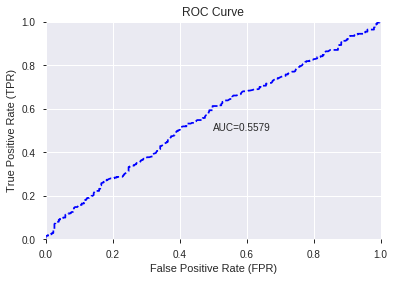

This function is available for GLM models only


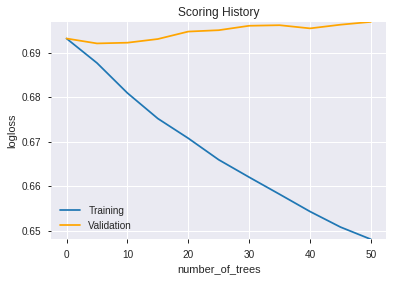

--2019-08-24 18:01:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.1.44
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.1.44|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genm

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_180132_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_180132_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['STOCHF_fastk',
 'ULTOSC',
 'BOP',
 'CCI_8',
 'WILLR_8',
 'CMO_8',
 'WILLR_12',
 'WILLR_14',
 'RSI_8',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

65

['BBANDS_upperband_20_3_5',
 'BBANDS_upperband_24_6_2',
 'BBANDS_lowerband_30_7_3',
 'BOP',
 'aroondown_8',
 'aroonup_8',
 'CCI_8',
 'CMO_8',
 'MACDFIX_hist_8',
 'MFI_8',
 'MINUS_DM_8',
 'PLUS_DI_8',
 'ROC_8',
 'RSI_8',
 'WILLR_8',
 'ADXR_12',
 'aroondown_12',
 'DX_12',
 'MFI_12',
 'MINUS_DI_12',
 'MOM_12',
 'ROCP_12',
 'ADX_14',
 'aroondown_14',
 'aroonup_14',
 'DX_14',
 'MFI_14',
 'PLUS_DI_14',
 'ROC_14',
 'WILLR_14',
 'MINUS_DI_20',
 'MOM_20',
 'aroondown_24',
 'MFI_24',
 'ROCP_24',
 'ROCR_24',
 'WILLR_24',
 'aroondown_30',
 'aroonup_30',
 'MINUS_DM_30',
 'ROC_30',
 'PPO',
 'STOCH_slowk',
 'STOCH_slowd',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'ATR_20',
 'NATR_30',
 'HT_DCPERIOD',
 'HT_PHASOR_quadrature',
 'CDLSHORTLINE',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'LINEARREG_SLOPE_8',
 'STDDEV_8',
 'VAR_12',
 'BETA_14',
 'LINEARREG_SLOPE_14',
 'LINEARREG_ANGLE_20',
 'STDDEV_20',
 'BETA_30',
 'STDDEV_30']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_180653_model_7  0.532263  0.721971              0.485247  0.512024  0.262168
1  DeepLearning_grid_1_AutoML_20190824_180653_model_4  0.528039  0.786339              0.498371  0.530609  0.281546
2  DeepLearning_grid_1_AutoML_20190824_180653_model_3  0.524929  0.958895              0.495114  0.576491  0.332342
3  DeepLearning_grid_1_AutoML_20190824_180653_model_5  0.521940  0.701889              0.500000  0.504223  0.254240
4  DeepLearning_grid_1_AutoML_20190824_180653_model_9  0.521005  0.693460              0.500000  0.500146  0.250146
5  DeepLearning_grid_1_AutoML_20190824_180653_model_2  0.516991  0.816392              0.498371  0.543034  0.294886
6  DeepLearning_grid_1_AutoML_20190824_180653_model_6  0.516323  0.700123              0.486971  0.503246  0.253256
7  DeepLearning_grid_1_AutoML_20190824_180653_model_8  0.514994  0.692900              0.493454  0.499876  0.249876
8               DeepLearning_1_AutoML_20190824_180653  0.514311  0.768367              0.482053  0.528524  0.279337
9  DeepLearning_grid_1_AutoML_20190824_180653_model_1  0.502443  1.399162              0.498371  0.622933  0.388046

variable  relative_importance  scaled_importance  percentage
0                  BOP             1.000000           1.000000    0.016784
1          aroondown_8             0.980172           0.980172    0.016452
2         aroondown_12             0.960223           0.960223    0.016117
3            STDDEV_20             0.958585           0.958585    0.016089
4         STOCHF_fastk             0.957497           0.957497    0.016071
..                 ...                  ...                ...         ...
60              ROC_30             0.874618           0.874618    0.014680
61  LINEARREG_SLOPE_14             0.872567           0.872567    0.014646
62                 PPO             0.870257           0.870257    0.014607
63              ROC_14             0.866538           0.866538    0.014544
64            WILLR_24             0.865347           0.865347    0.014524

[65 rows x 4 columns]

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_180653_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24282836884869413
RMSE: 0.4927761853506053
LogLoss: 0.6784940922760675
Mean Per-Class Error: 0.4286811227671754
AUC: 0.60176797980189
pr_auc: 0.6236162436840154
Gini: 0.20353595960378001
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24797644454251666: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      115  2018  0.9461   (2018.0/2133.0)
1      41   2139  0.0188   (41.0/2180.0)
Total  156  4157  0.4774   (2059.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.247976     0.675083  360
max f2                       0.146462     0.83666   394
max f0point5                 0.388172     0.57753   271
max accuracy                 0.476273     0.570137  186
max precision                0.994503     1         0
max recall                   0.146462     1         394
max specificity              0.994503     1         0
max absolute_mcc             0.549173     0.171344  127
max min_per_class_accuracy   0.45175      0.567276  209
max mean_per_class_accuracy  0.476273     0.571319  186

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 45.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.795203           1.79858   1.79858            0.909091         0.872637  0.909091                    0.872637            0.0183486       0.0183486                  79.8582    79.8582
    2        0.0201716                   0.733096           1.70238   1.75103            0.860465         0.762642  0.885057                    0.818271            0.0169725       0.0353211                  70.2379    75.1033
    3        0.0301414                   0.697525           1.7944    1.76538            0.906977         0.71265   0.892308                    0.783335            0.0178899       0.053211                   79.4399    76.5378
    4        0.0401113                   0.668102           1.51834   1.70397            0.767442         0.680004  0.861272                    0.757652            0.0151376       0.0683486                  51.8338    70.3975
    5        0.0500812                   0.631911           1.42632   1.6487             0.72093          0.649024  0.833333                    0.736027            0.0142202       0.0825688                  42.6317    64.87
    6        0.100162                    0.582381           1.25484   1.45177            0.634259         0.600961  0.733796                    0.668494            0.062844        0.145413                   25.4844    45.1772
    7        0.150012                    0.55968            1.18706   1.36381            0.6              0.57045   0.689335                    0.635914            0.0591743       0.204587                   18.7064    36.3809
    8        0.200093                    0.540947           1.19073   1.32049            0.601852         0.54998   0.667439                    0.614405            0.059633        0.26422                    19.0728    32.0489
    9        0.300023                    0.504503           1.06496   1.23538            0.538283         0.521982  0.62442                     0.583621            0.106422        0.370642                   6.49609    23.5379
    10       0.399954                    0.473521           0.991515  1.17445            0.50116          0.488954  0.593623                    0.559968            0.0990826       0.469725                   -0.848464  17.4448
    11       0.500116                    0.451641           0.98464   1.13643            0.497685         0.460584  0.574409                    0.540064            0.0986239       0.568349                   -1.53595   13.6434
    12       0.600046                    0.432678           0.876757  1.09319            0.443155         0.443051  0.55255                     0.523908            0.0876147       0.655963                   -12.3243   9.31877
    13       0.699977                    0.405786           0.92725   1.0695             0.468677         0.419504  0.540576                    0.509003            0.0926606       0.748624                   -7.27495   6.94981
    14       0.799907                    0.370554           0.92266   1.05115            0.466357         0.389182  0.531304                    0.494034            0.0922018       0.840826                   -7.73399   5.1154
    15       0.899838                    0.312649           0.908889  1.03535            0.459397         0.344476  0.523319                    0.477425            0.0908257       0.931651                   -9.11109   3.53549
    16       1                           0.121107           0.682379  1                  0.344907         0.255536  0.505449                    0.4



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2597276295640397
RMSE: 0.509634800189351
LogLoss: 0.7175239569244867
Mean Per-Class Error: 0.4613386824324325
AUC: 0.5414418813344595
pr_auc: 0.5451537072854437
Gini: 0.08288376266891895
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19535405752867196: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    586   0.9899   (586.0/592.0)
1      1    639   0.0016   (1.0/640.0)
Total  7    1225  0.4765   (587.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.195354     0.685255   394
max f2                       0.183802     0.84455    396
max f0point5                 0.310774     0.581645   341
max accuracy                 0.419237     0.544643   258
max precision                0.898467     0.625      6
max recall                   0.183802     1          396
max specificity              0.958787     0.998311   0
max absolute_mcc             0.419237     0.0812693  258
max min_per_class_accuracy   0.45581      0.523649   220
max mean_per_class_accuracy  0.419237     0.538661   258

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 47.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105519                   0.856478           0.888462  0.888462           0.461538         0.905328  0.461538                    0.905328            0.009375        0.009375                   -11.1538   -11.1538
    2        0.0202922                   0.788494           1.12292   1.001              0.583333         0.823493  0.52                        0.866047            0.0109375       0.0203125                  12.2917    0.1
    3        0.0300325                   0.750121           1.12292   1.04054            0.583333         0.767221  0.540541                    0.833995            0.0109375       0.03125                    12.2917    4.05405
    4        0.0405844                   0.713488           1.03654   1.0395             0.538462         0.732384  0.54                        0.807577            0.0109375       0.0421875                  3.65385    3.95
    5        0.0503247                   0.694294           1.28333   1.08669            0.666667         0.701743  0.564516                    0.787093            0.0125          0.0546875                  28.3333    8.66935
    6        0.100649                    0.629262           0.993548  1.04012            0.516129         0.655549  0.540323                    0.721321            0.05            0.104688                   -0.645161  4.0121
    7        0.150162                    0.596204           1.16762   1.08216            0.606557         0.612047  0.562162                    0.68529             0.0578125       0.1625                     16.7623    8.21622
    8        0.200487                    0.57972            1.05565   1.07551            0.548387         0.588245  0.558704                    0.660931            0.053125        0.215625                   5.56452    7.55061
    9        0.300325                    0.538208           1.06423   1.07176            0.552846         0.560189  0.556757                    0.627441            0.10625         0.321875                   6.42276    7.17568
    10       0.400162                    0.488083           1.04858   1.06597            0.544715         0.51381   0.553753                    0.599091            0.104688        0.426563                   4.85772    6.59736
    11       0.5                         0.455914           0.970325  1.04688            0.504065         0.471731  0.543831                    0.57366             0.096875        0.523438                   -2.96748   4.6875
    12       0.599838                    0.431354           1.01728   1.04195            0.528455         0.443991  0.541272                    0.552078            0.101562        0.625                      1.72764    4.19486
    13       0.699675                    0.40688            1.01728   1.03843            0.528455         0.419453  0.539443                    0.533154            0.101562        0.726562                   1.72764    3.84281
    14       0.799513                    0.369279           0.985976  1.03188            0.512195         0.38673   0.536041                    0.514869            0.0984375       0.825                      -1.40244   3.18782
    15       0.899351                    0.319169           0.954675  1.02331            0.495935         0.347001  0.531588                    0.496234            0.0953125       0.920312                   -4.53252   2.33078
    16       1                           0.160001           0.791734  1                  0.41129          0.265352  0.519481                    0.472996


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:14:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 18:14:13  8.106 sec         262 obs/sec       0.320195  1             1381       0.55142          0.859601            -0.2164        0.539143        0.542792           1.30397          0.493624                         0.570591           0.923845              -0.304276        0.512427          0.534198             1.03654            0.480519
    2019-08-24 18:14:42  37.933 sec        613 obs/sec       4.59216   14            19806      0.492776         0.678494            0.0285712      0.601768        0.623616           1.79858          0.477394                         0.509635           0.717524              -0.0404899       0.541442          0.545154             0.888462           0.476461
    2019-08-24 18:15:12  1 min  7.087 sec  675 obs/sec       9.16555   28            39531      0.485416         0.662588            0.0573736      0.690699        0.695233           1.97844          0.410155                         0.525738           0.780555              -0.107283        0.555523          0.557921             1.03654            0.478084
    2019-08-24 18:15:42  1 min 37.401 sec  707 obs/sec       14.0974   43            60802      0.464982         0.620603            0.135065       0.746263        0.752999           1.93348          0.354973                         0.558867           0.94392               -0.251228        0.556623          0.552011             0.888462           0.478896
    2019-08-24 18:16:11  2 min  7.038 sec  729 obs/sec       19.0619   58            82214      0.562861         0.968238            -0.267402      0.803213        0.815606           1.97844          0.297473                         0.637968           1.42151               -0.630487        0.541689          0.552579             0.888462           0.480519
    2019-08-24 18:16:41  2 min 36.459 sec  743 obs/sec       23.9882   73            103461     0.432899         0.546202            0.250304       0.849049        0.826915           1.97844          0.26339                          0.559812           1.00716               -0.255463        0.566148          0.567107             1.18462            0.478084
    2019-08-24 18:16:44  2 min 39.694 sec  742 obs/sec       23.9882   73            103461     0.492776         0.678494            0.0285712      0.601768        0.623616           1.79858          0.477394                         0.509635           0.717524              -0.0404899       0.541442          0.545154             0.888462           0.476461

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
BOP                 1.0                    1.0                  0.01678444430486211
aroondown_8         0.9801715612411499     0.9801715612411499   0.01645163497886182
aroondown_12        0.9602228999137878     0.9602228999137878   0.016116807783856157
STDDEV_20           0.9585851430892944     0.9585851430892944   0.01608931894565054
STOCHF_fastk        0.9574974775314331     0.9574974775314331   0.0160710630836723
---                 ---                    ---                  ---
ROC_30              0.8746179342269897     0.8746179342269897   0.014679976005066462
LINEARREG_SLOPE_14  0.8725670576095581     0.8725670576095581   0.014645553180705036
PPO                 0.8702569603919983     0.8702569603919983   0.014606779482618086
ROC_14              0.8665384650230408     0.8665384650230408   0.014544366604199931
WILLR_24            0.8653466105461121     0.8653466105461121   0.014524361989112422


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5332252836304701)

('F1', 0.6710816777041944)

('auc', 0.5322633182725649)

('logloss', 0.7219708198259541)

('mean_per_class_error', 0.4668487968897762)

('rmse', 0.5120235242219005)

('mse', 0.2621680893566151)

deeplearning prediction progress: |███████████████████████████████████████| 100%


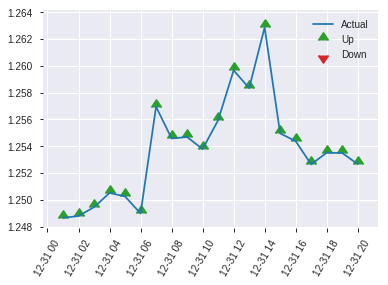


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2621680893566151
RMSE: 0.5120235242219005
LogLoss: 0.7219708198259541
Mean Per-Class Error: 0.4668487968897762
AUC: 0.5322633182725649
pr_auc: 0.525032787472508
Gini: 0.0645266365451298
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24033281943254114: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   292  0.9511   (292.0/307.0)
1      6    304  0.0194   (6.0/310.0)
Total  21   596  0.483    (298.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.240333     0.671082   380
max f2                       0.200555     0.83603    396
max f0point5                 0.284101     0.567211   356
max accuracy                 0.473897     0.533225   207
max precision                0.905364     1          0
max recall                   0.200555     1          396
max specificity              0.905364     1          0
max absolute_mcc             0.284101     0.0897478  356
max min_per_class_accuracy   0.481419     0.525806   200
max mean_per_class_accuracy  0.473897     0.533151   207

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 48.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.845421           0.852995  0.852995           0.428571         0.87751   0.428571                    0.87751             0.00967742      0.00967742                 -14.7005   -14.7005
    2        0.0210697                   0.820836           0.995161  0.91861            0.5              0.829946  0.461538                    0.855558            0.00967742      0.0193548                  -0.483871  -8.13896
    3        0.0307942                   0.759275           0.995161  0.942784           0.5              0.784728  0.473684                    0.83319             0.00967742      0.0290323                  -0.483871  -5.72156
    4        0.0405186                   0.732997           0.995161  0.955355           0.5              0.744732  0.48                        0.81196             0.00967742      0.0387097                  -0.483871  -4.46452
    5        0.0502431                   0.704009           0.995161  0.963059           0.5              0.719243  0.483871                    0.794015            0.00967742      0.0483871                  -0.483871  -3.69407
    6        0.100486                    0.645058           1.21988   1.09147            0.612903         0.668646  0.548387                    0.731331            0.0612903       0.109677                   21.9875    9.14672
    7        0.150729                    0.621423           1.09147   1.09147            0.548387         0.635362  0.548387                    0.699341            0.0548387       0.164516                   9.14672    9.14672
    8        0.200972                    0.600566           1.21988   1.12357            0.612903         0.609854  0.564516                    0.676969            0.0612903       0.225806                   21.9875    12.3569
    9        0.299838                    0.563859           1.01148   1.08661            0.508197         0.58056   0.545946                    0.64518             0.1             0.325806                   1.14754    8.66085
    10       0.400324                    0.523903           0.866753  1.03142            0.435484         0.545378  0.518219                    0.620129            0.0870968       0.412903                   -13.3247   3.14222
    11       0.50081                     0.479968           1.12357   1.04991            0.564516         0.498401  0.527508                    0.595704            0.112903        0.525806                   12.3569    4.99113
    12       0.599676                    0.446422           0.913591  1.02744            0.459016         0.462582  0.516216                    0.573757            0.0903226       0.616129                   -8.64093   2.74368
    13       0.700162                    0.411195           0.963059  1.0182             0.483871         0.428362  0.511574                    0.55289             0.0967742       0.712903                   -3.69407   1.81974
    14       0.799028                    0.364079           0.946219  1.00929            0.47541          0.388275  0.507099                    0.532522            0.0935484       0.806452                   -5.37811   0.929137
    15       0.899514                    0.296537           1.05937   1.01489            0.532258         0.328413  0.50991                     0.509721            0.106452        0.912903                   5.93652    1.48852
    16       1                           0.167405           0.866753  1                  0.435484         0.252996  0.502431              

This function is available for GLM models only


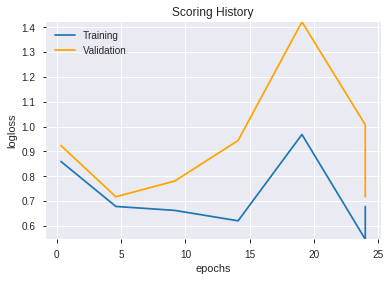

--2019-08-24 18:25:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.82.88
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.82.88|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_180653_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_180653_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'aroondown_8',
 'aroondown_12',
 'STDDEV_20',
 'STOCHF_fastk',
 'BETA_14',
 'BETA_30',
 'ULTOSC',
 'BBANDS_upperband_24_6_2',
 'BETA_8',
 'WILLR_8',
 'MOM_20',
 'STOCHRSI_fastk',
 'CDLSHORTLINE',
 'ADOSC',
 'aroonup_8',
 'ROC_8',
 'MOM_12',
 'STDDEV_8',
 'PLUS_DI_8',
 'HT_DCPERIOD',
 'DX_12',
 'ROCR_24',
 'STOCHF_fastd',
 'aroondown_14',
 'MINUS_DM_30',
 'MINUS_DI_20',
 'STDDEV_30',
 'MINUS_DM_8',
 'DX_14',
 'WILLR_14',
 'CCI_8',
 'MFI_24',
 'aroondown_24',
 'HT_PHASOR_quadrature',
 'MFI_8',
 'RSI_8',
 'ADX_14',
 'STOCH_slowd',
 'STOCH_slowk',
 'MINUS_DI_12',
 'NATR_30',
 'BBANDS_upperband_20_3_5',
 'LINEARREG_ANGLE_8',
 'MFI_12',
 'MACDFIX_hist_8',
 'ROCP_24',
 'aroondown_30',
 'BBANDS_lowerband_30_7_3',
 'ADXR_12',
 'PLUS_DI_14',
 'CMO_8',
 'aroonup_14',
 'LINEARREG_SLOPE_8',
 'ATR_20',
 'VAR_12',
 'LINEARREG_ANGLE_20',
 'MFI_14',
 'ROCP_12',
 'aroonup_30',
 'ROC_30',
 'LINEARREG_SLOPE_14',
 'PPO',
 'ROC_14',
 'WILLR_24']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_182542_model_1  0.516728  0.69235              0.491841  0.499603  0.249603

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.007353           1.000000    0.063932
1         STOCHF_fastk             0.007213           0.980946    0.062713
2       STOCHRSI_fastk             0.006234           0.847773    0.054199
3              WILLR_8             0.005179           0.704311    0.045028
4               ULTOSC             0.004634           0.630176    0.040288
..                 ...                  ...                ...         ...
60                 PPO             0.000406           0.055229    0.003531
61        aroondown_12             0.000185           0.025191    0.001611
62         aroondown_8             0.000152           0.020730    0.001325
63        aroondown_14             0.000122           0.016555    0.001058
64  LINEARREG_ANGLE_20             0.000039           0.005253    0.000336

[65 rows x 4 columns]

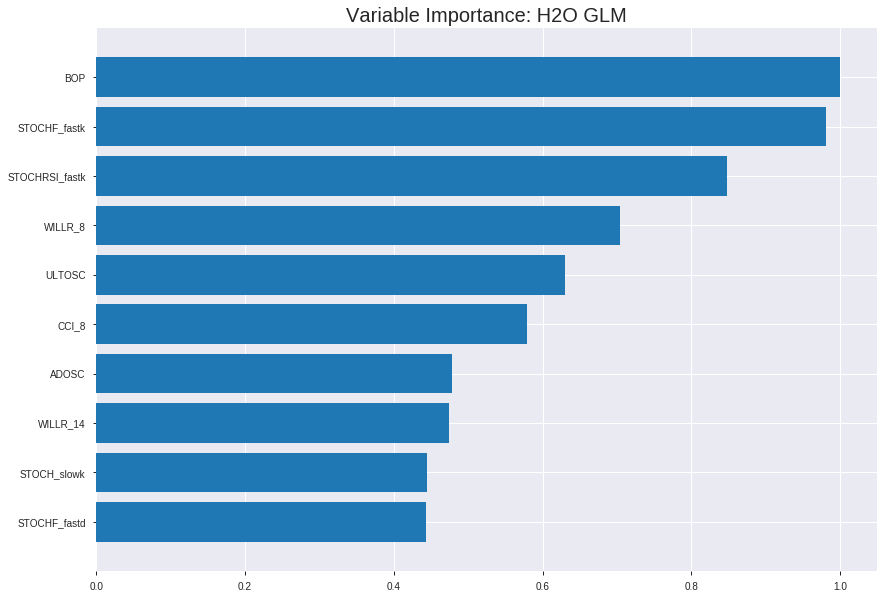

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_182542_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2487875181511938
RMSE: 0.49878604446314834
LogLoss: 0.6907197796790661
Null degrees of freedom: 4312
Residual degrees of freedom: 4247
Null deviance: 5978.575396871039
Residual deviance: 5958.1488195116235
AIC: 6090.1488195116235
AUC: 0.5500636567353557
pr_auc: 0.5470984370273526
Gini: 0.10012731347071147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4617516356074707: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      4    2129  0.9981   (2129.0/2133.0)
1      0    2180  0        (0.0/2180.0)
Total  4    4309  0.4936   (2129.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.461752     0.671906   395
max f2                       0.461752     0.836595   395
max f0point5                 0.493896     0.563988   273
max accuracy                 0.496341     0.540459   258
max precision                0.560384     1          0
max recall                   0.461752     1          395
max specificity              0.560384     1          0
max absolute_mcc             0.511522     0.0850446  163
max min_per_class_accuracy   0.505301     0.533028   200
max mean_per_class_accuracy  0.511522     0.540988   163

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 50.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102017                   0.54433            1.25901   1.25901            0.636364         0.54881   0.636364                    0.54881             0.012844        0.012844                   25.9008    25.9008
    2        0.0201716                   0.539424           0.966215  1.11429            0.488372         0.541881  0.563218                    0.545385            0.00963303      0.0224771                  -3.37849   11.4294
    3        0.0301414                   0.537216           1.3343    1.18706            0.674419         0.538175  0.6                         0.543               0.0133028       0.0357798                  33.4297    18.7064
    4        0.0401113                   0.53514            1.01223   1.14361            0.511628         0.536114  0.578035                    0.541289            0.0100917       0.0458716                  1.22253    14.3607
    5        0.0500812                   0.533618           1.01223   1.11745            0.511628         0.534284  0.564815                    0.539894            0.0100917       0.0559633                  1.22253    11.7452
    6        0.100162                    0.527618           1.12661   1.12203            0.569444         0.530595  0.56713                     0.535245            0.056422        0.112385                   12.6612    12.2032
    7        0.150012                    0.523155           1.09504   1.11306            0.553488         0.525193  0.562597                    0.531904            0.0545872       0.166972                   9.50437    11.3064
    8        0.200093                    0.520033           1.08081   1.10499            0.546296         0.521538  0.558517                    0.52931             0.0541284       0.221101                   8.08146    10.4992
    9        0.300023                    0.514793           1.12923   1.11306            0.570766         0.517304  0.562597                    0.525311            0.112844        0.333945                   12.9226    11.3064
    10       0.399954                    0.509683           1.01447   1.08843            0.512761         0.512205  0.550145                    0.522036            0.101376        0.435321                   1.44671    8.84289
    11       0.500116                    0.505173           0.98922   1.06856            0.5              0.507292  0.540102                    0.519083            0.0990826       0.534404                   -1.07798   6.85596
    12       0.600046                    0.500675           0.996106  1.05649            0.50348          0.502821  0.534003                    0.516375            0.0995413       0.633945                   -0.389429  5.64933
    13       0.699977                    0.495817           1.02824   1.05246            0.519722         0.498262  0.531964                    0.513789            0.102752        0.736697                   2.82381    5.24595
    14       0.799907                    0.490442           0.853805  1.02764            0.431555         0.493251  0.51942                     0.511223            0.0853211       0.822018                   -14.6195   2.76421
    15       0.899838                    0.48341            0.91807   1.01547            0.464037         0.487116  0.51327                     0.508546            0.0917431       0.913761                   -8.19302   1.54736
    16       1                           0.450959           0.860988  1                  0.435185         0.477621  0.505449                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2495503987796168
RMSE: 0.49955019645638893
LogLoss: 0.6922449783852351
Null degrees of freedom: 1231
Residual degrees of freedom: 1166
Null deviance: 1707.0147816677918
Residual deviance: 1705.6916267412194
AIC: 1837.6916267412194
AUC: 0.5181495460304054
pr_auc: 0.5383664045991001
Gini: 0.036299092060810834
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4652184588499562: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      10   582   0.9831   (582.0/592.0)
1      2    638   0.0031   (2.0/640.0)
Total  12   1220  0.474    (584.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.465218     0.686022   388
max f2                       0.460641     0.844327   397
max f0point5                 0.470129     0.579764   375
max accuracy                 0.477905     0.532468   340
max precision                0.57629      1          0
max recall                   0.460641     1          397
max specificity              0.57629      1          0
max absolute_mcc             0.470129     0.0727313  375
max min_per_class_accuracy   0.502301     0.509375   204
max mean_per_class_accuracy  0.516422     0.523923   123

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 50.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.551088           1.18462   1.18462            0.615385         0.561846  0.615385                    0.561846            0.0125          0.0125                     18.4615   18.4615
    2        0.0202922                   0.542482           1.28333   1.232              0.666667         0.546135  0.64                        0.554305            0.0125          0.025                      28.3333   23.2
    3        0.0300325                   0.540087           0.802083  1.09257            0.416667         0.541022  0.567568                    0.549997            0.0078125       0.0328125                  -19.7917  9.25676
    4        0.0405844                   0.537412           0.592308  0.9625             0.307692         0.538547  0.5                         0.54702             0.00625         0.0390625                  -40.7692  -3.75
    5        0.0503247                   0.534715           1.12292   0.993548           0.583333         0.535748  0.516129                    0.544838            0.0109375       0.05                       12.2917   -0.645161
    6        0.100649                    0.526903           1.24194   1.11774            0.645161         0.530891  0.580645                    0.537864            0.0625          0.1125                     24.1935   11.7742
    7        0.150162                    0.522703           1.10451   1.11338            0.57377          0.524556  0.578378                    0.533476            0.0546875       0.167187                   10.4508   11.3378
    8        0.200487                    0.519183           0.869355  1.05213            0.451613         0.520847  0.546559                    0.530306            0.04375         0.210938                   -13.0645  5.21255
    9        0.300325                    0.512865           1.07988   1.06135            0.560976         0.515942  0.551351                    0.525531            0.107813        0.31875                    7.9878    6.13514
    10       0.400162                    0.507493           0.892073  1.01912            0.463415         0.51003   0.529412                    0.521663            0.0890625       0.407813                   -10.7927  1.91176
    11       0.5                         0.502109           1.01728   1.01875            0.528455         0.504476  0.529221                    0.518232            0.101562        0.509375                   1.72764   1.875
    12       0.599838                    0.496786           0.985976  1.01329            0.512195         0.499635  0.526387                    0.515136            0.0984375       0.607812                   -1.40244  1.3295
    13       0.699675                    0.491629           0.923374  1.00046            0.479675         0.494058  0.519722                    0.512129            0.0921875       0.7                        -7.6626   0.0464037
    14       0.799513                    0.484611           1.06423   1.00843            0.552846         0.487937  0.523858                    0.509108            0.10625         0.80625                    6.42276   0.84264
    15       0.899351                    0.477591           1.09553   1.0181             0.569106         0.481352  0.528881                    0.506027            0.109375        0.915625                   9.55285   1.80957
    16       1                           0.459352           0.838306  1                  0.435484         0.471927  0.519481                    0.502595            0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 18:25:43  0.000 sec   2            4.9       66            1.38144           1.38449
    2019-08-24 18:25:43  0.031 sec   4            3         66            1.3802            1.38454
    2019-08-24 18:25:43  0.062 sec   6            1.9       66            1.37884           1.38469
    2019-08-24 18:25:43  0.093 sec   8            1.2       66            1.37745           1.38494
    2019-08-24 18:25:43  0.126 sec   10           0.73      66            1.37608           1.38532
    2019-08-24 18:25:43  0.158 sec   12           0.45      66            1.37483           1.38584

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5251215559157212)

('F1', 0.6717391304347826)

('auc', 0.5167279604917516)

('logloss', 0.6923500022468353)

('mean_per_class_error', 0.4744089524009667)

('rmse', 0.49960264513062597)

('mse', 0.2496028030215182)

glm prediction progress: |████████████████████████████████████████████████| 100%


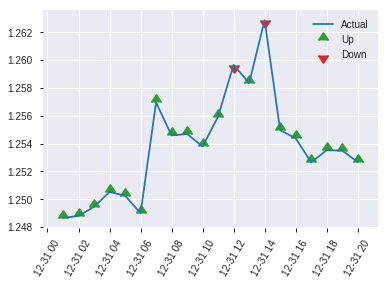


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2496028030215182
RMSE: 0.49960264513062597
LogLoss: 0.6923500022468353
Null degrees of freedom: 616
Residual degrees of freedom: 551
Null deviance: 855.3515081364842
Residual deviance: 854.3599027725948
AIC: 986.3599027725948
AUC: 0.5167279604917516
pr_auc: 0.5261699656946696
Gini: 0.03345592098350325
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46586435434045503: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    301  0.9805   (301.0/307.0)
1      1    309  0.0032   (1.0/310.0)
Total  7    610  0.4895   (302.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.465864     0.671739   392
max f2                       0.459528     0.83603    396
max f0point5                 0.480339     0.564894   358
max accuracy                 0.510041     0.525122   163
max precision                0.561        1          0
max recall                   0.459528     1          396
max specificity              0.561        1          0
max absolute_mcc             0.544235     0.0803874  3
max min_per_class_accuracy   0.505641     0.498371   199
max mean_per_class_accuracy  0.510041     0.525591   163

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 50.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113452                   0.538558           1.42166   1.42166            0.714286         0.545548  0.714286                    0.545548            0.016129        0.016129                   42.1659    42.1659
    2        0.0210697                   0.536874           0.995161  1.22481            0.5              0.537666  0.615385                    0.54191             0.00967742      0.0258065                  -0.483871  22.4814
    3        0.0307942                   0.533848           0.995161  1.15229            0.5              0.535567  0.578947                    0.539907            0.00967742      0.0354839                  -0.483871  15.2292
    4        0.0405186                   0.532374           1.6586    1.27381            0.833333         0.5329    0.64                        0.538225            0.016129        0.0516129                  65.8602    27.3806
    5        0.0502431                   0.530883           1.32688   1.28408            0.666667         0.531533  0.645161                    0.53693             0.0129032       0.0645161                  32.6882    28.4079
    6        0.100486                    0.52679            0.706243  0.995161           0.354839         0.528848  0.5                         0.532889            0.0354839       0.1                        -29.3757   -0.483871
    7        0.150729                    0.523982           1.09147   1.02726            0.548387         0.525696  0.516129                    0.530492            0.0548387       0.154839                   9.14672    2.72633
    8        0.200972                    0.520418           1.34828   1.10752            0.677419         0.52203   0.556452                    0.528376            0.0677419       0.222581                   34.8283    10.7518
    9        0.299838                    0.515436           0.913591  1.04357            0.459016         0.517933  0.524324                    0.524933            0.0903226       0.312903                   -8.64093   4.35745
    10       0.400324                    0.510049           1.09147   1.0556             0.548387         0.512589  0.530364                    0.521834            0.109677        0.422581                   9.14672    5.55962
    11       0.50081                     0.505641           0.770447  0.998382           0.387097         0.507918  0.501618                    0.519042            0.0774194       0.5                        -22.9553   -0.161812
    12       0.599676                    0.499832           0.946219  0.989782           0.47541          0.502843  0.497297                    0.516371            0.0935484       0.593548                   -5.37811   -1.0218
    13       0.700162                    0.494513           1.15567   1.01359            0.580645         0.497316  0.509259                    0.513637            0.116129        0.709677                   15.5671    1.35902
    14       0.799028                    0.488263           1.01148   1.01333            0.508197         0.491644  0.509128                    0.510915            0.1             0.809677                   1.14754    1.33285
    15       0.899514                    0.481685           1.02726   1.01489            0.516129         0.485153  0.50991                     0.508037            0.103226        0.912903                   2.72633    1.48852
    16       1                           0.456243           0.866753  1                  0.435484         0.474276  0.502431                

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


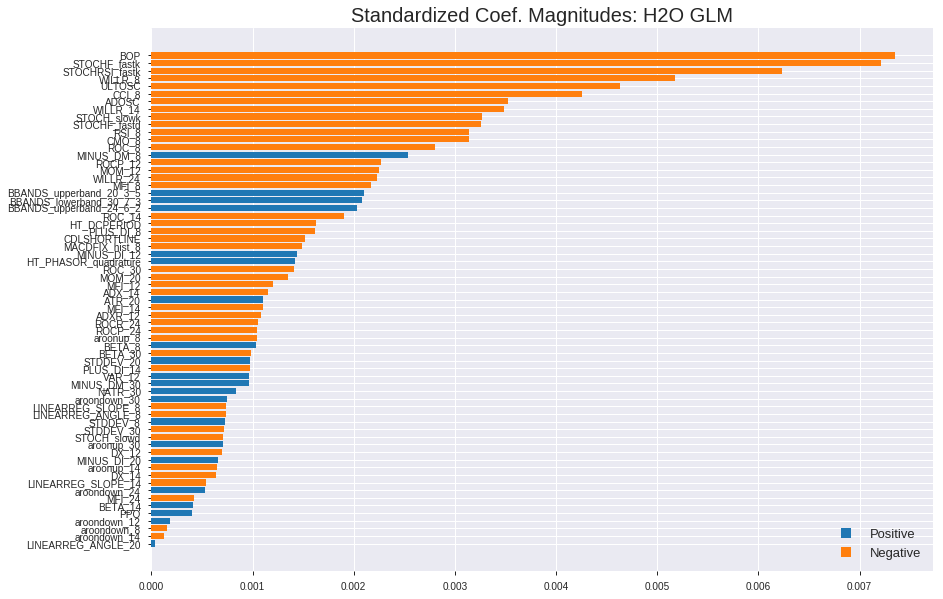

'log_likelihood'
--2019-08-24 18:25:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.239.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.239.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_182542_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_182542_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'WILLR_8',
 'ULTOSC',
 'CCI_8',
 'ADOSC',
 'WILLR_14',
 'STOCH_slowk',
 'STOCHF_fastd',
 'RSI_8',
 'CMO_8',
 'ROC_8',
 'MINUS_DM_8',
 'ROCP_12',
 'MOM_12',
 'WILLR_24',
 'MFI_8',
 'BBANDS_upperband_20_3_5',
 'BBANDS_lowerband_30_7_3',
 'BBANDS_upperband_24_6_2',
 'ROC_14',
 'HT_DCPERIOD',
 'PLUS_DI_8',
 'CDLSHORTLINE',
 'MACDFIX_hist_8',
 'MINUS_DI_12',
 'HT_PHASOR_quadrature',
 'ROC_30',
 'MOM_20',
 'MFI_12',
 'ADX_14',
 'ATR_20',
 'MFI_14',
 'ADXR_12',
 'ROCR_24',
 'ROCP_24',
 'aroonup_8',
 'BETA_8',
 'BETA_30',
 'STDDEV_20',
 'PLUS_DI_14',
 'VAR_12',
 'MINUS_DM_30',
 'NATR_30',
 'aroondown_30',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8',
 'STDDEV_8',
 'STDDEV_30',
 'STOCH_slowd',
 'aroonup_30',
 'DX_12',
 'MINUS_DI_20',
 'aroonup_14',
 'DX_14',
 'LINEARREG_SLOPE_14',
 'aroondown_24',
 'MFI_24',
 'BETA_14',
 'PPO',
 'aroondown_12',
 'aroondown_8',
 'aroondown_14',
 'LINEARREG_ANGLE_20']

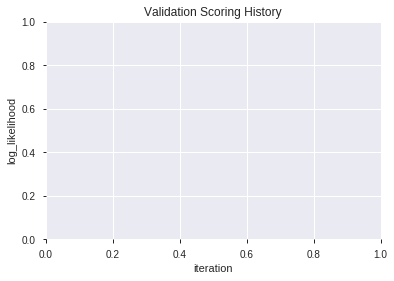

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_182602_model_3  0.541736  0.692404              0.485326  0.499640  0.249640
1  XGBoost_grid_1_AutoML_20190824_182602_model_6  0.528938  0.694989              0.493470  0.500920  0.250921
2  XGBoost_grid_1_AutoML_20190824_182602_model_5  0.528570  0.725322              0.498356  0.513694  0.263882
3  XGBoost_grid_1_AutoML_20190824_182602_model_2  0.522896  0.697011              0.500000  0.501835  0.251838
4  XGBoost_grid_1_AutoML_20190824_182602_model_7  0.521530  0.705735              0.488599  0.505872  0.255907
5               XGBoost_2_AutoML_20190824_182602  0.518388  0.705347              0.500000  0.505742  0.255775
6  XGBoost_grid_1_AutoML_20190824_182602_model_1  0.517154  0.699005              0.488536  0.502779  0.252787
7  XGBoost_grid_1_AutoML_20190824_182602_model_4  0.516239  0.697040              0.496743  0.501922  0.251926
8               XGBoost_3_AutoML_20190824_182602  0.509856  0.698709              0.495114  0.502721  0.252729
9               XGBoost_1_AutoML_20190824_182602  0.509578  0.709722              0.500000  0.507715  0.257775

variable  relative_importance  scaled_importance  percentage
0                 BOP           337.549561           1.000000    0.049247
1        STOCHF_fastk           236.375107           0.700268    0.034486
2             BETA_30           229.221802           0.679076    0.033443
3         HT_DCPERIOD           204.090759           0.604625    0.029776
4               ADOSC           183.746506           0.544354    0.026808
..                ...                  ...                ...         ...
59         aroonup_30            26.477867           0.078441    0.003863
60       aroondown_30            25.976971           0.076958    0.003790
61  LINEARREG_SLOPE_8            24.164186           0.071587    0.003525
62              RSI_8            14.286638           0.042325    0.002084
63          aroonup_8             7.982305           0.023648    0.001165

[64 rows x 4 columns]

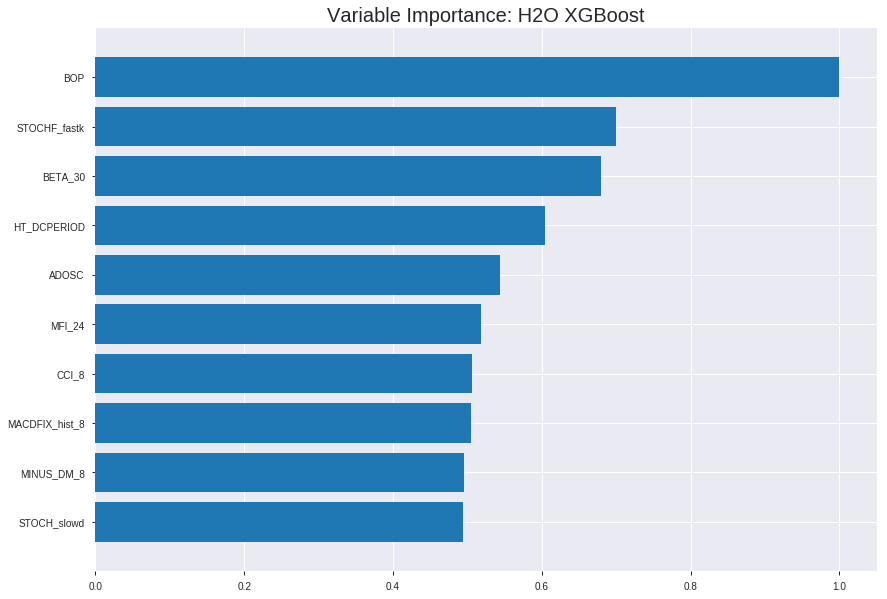

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_182602_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21393765920104577
RMSE: 0.46253395464662456
LogLoss: 0.6196584610779103
Mean Per-Class Error: 0.2560955625233874
AUC: 0.8291325264412014
pr_auc: 0.8346106720754347
Gini: 0.6582650528824028
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4817567401462131: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1276  857   0.4018   (857.0/2133.0)
1      302   1878  0.1385   (302.0/2180.0)
Total  1578  2735  0.2687   (1159.0/4313.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481757     0.764191  229
max f2                       0.439699     0.861507  284
max f0point5                 0.524147     0.759696  170
max accuracy                 0.511323     0.743566  188
max precision                0.773667     1         0
max recall                   0.36237      1         352
max specificity              0.773667     1         0
max absolute_mcc             0.511323     0.488569  188
max min_per_class_accuracy   0.505472     0.73945   196
max mean_per_class_accuracy  0.511323     0.743904  188

Gains/Lift Table: Avg response rate: 50.54 %, avg score: 50.49 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102017                   0.682452           1.97844    1.97844            1                0.70163   1                           0.70163             0.0201835       0.0201835                  97.844    97.844
    2        0.0201716                   0.658604           1.93243    1.9557             0.976744         0.66987   0.988506                    0.685933            0.0192661       0.0394495                  93.243    95.57
    3        0.0301414                   0.645583           1.97844    1.96322            1                0.651538  0.992308                    0.674556            0.0197248       0.0591743                  97.844    96.3222
    4        0.0401113                   0.63551            1.93243    1.95557            0.976744         0.639357  0.988439                    0.665807            0.0192661       0.0784404                  93.243    95.5568
    5        0.0500812                   0.627974           1.97844    1.96012            1                0.631576  0.990741                    0.658992            0.0197248       0.0981651                  97.844    96.0121
    6        0.100162                    0.598777           1.85937    1.90974            0.939815         0.612418  0.965278                    0.635705            0.0931193       0.191284                   85.9368   90.9745
    7        0.150012                    0.579597           1.70238    1.84084            0.860465         0.588296  0.930448                    0.619951            0.0848624       0.276147                   70.2379   84.0836
    8        0.200093                    0.565857           1.63954    1.79045            0.828704         0.572718  0.904983                    0.608129            0.0821101       0.358257                   63.9541   79.0454
    9        0.300023                    0.543666           1.49186    1.691              0.75406          0.553956  0.854714                    0.590085            0.149083        0.507339                   49.1863   69.1001
    10       0.399954                    0.523803           1.25776    1.58275            0.635731         0.533201  0.8                         0.575872            0.125688        0.633028                   25.7756   58.2752
    11       0.500116                    0.505561           1.04418    1.47489            0.527778         0.514762  0.74548                     0.563633            0.104587        0.737615                   4.41769   47.4887
    12       0.600046                    0.487264           0.954793   1.38827            0.482599         0.496685  0.7017                      0.552484            0.0954128       0.833028                   -4.52074  38.8272
    13       0.699977                    0.469273           0.743637   1.29624            0.37587          0.478737  0.655184                    0.541956            0.0743119       0.907339                   -25.6363  29.6242
    14       0.799907                    0.445275           0.5233     1.19968            0.264501         0.457574  0.606377                    0.531414            0.0522936       0.959633                   -47.67    19.968
    15       0.899838                    0.411092           0.307553   1.10061            0.155452         0.429707  0.5563                      0.520119            0.0307339       0.990367                   -69.2447  10.0606
    16       1                           0.19578            0.0961742  1                  0.0486111        0.368288  0.505449                    0.5



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2506570608305843
RMSE: 0.5006566296680633
LogLoss: 0.694808805069214
Mean Per-Class Error: 0.4529771959459459
AUC: 0.5441115920608108
pr_auc: 0.5477329368325269
Gini: 0.08822318412162167
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3095555404822032: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   572   0.9662   (572.0/592.0)
1      8    632   0.0125   (8.0/640.0)
Total  28   1204  0.4708   (580.0/1232.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.309556     0.685466   373
max f2                       0.190442     0.843882   399
max f0point5                 0.407706     0.582248   307
max accuracy                 0.525649     0.542208   152
max precision                0.764634     1          0
max recall                   0.190442     1          399
max specificity              0.764634     1          0
max absolute_mcc             0.525649     0.0968907  152
max min_per_class_accuracy   0.50255      0.533784   188
max mean_per_class_accuracy  0.525649     0.547023   152

Gains/Lift Table: Avg response rate: 51.95 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105519                   0.678288           1.03654   1.03654            0.538462         0.700895  0.538462                    0.700895            0.0109375       0.0109375                  3.65385   3.65385
    2        0.0202922                   0.654793           1.12292   1.078              0.583333         0.665364  0.56                        0.68384             0.0109375       0.021875                   12.2917   7.8
    3        0.0300325                   0.63475            0.802083  0.988514           0.416667         0.641235  0.513514                    0.670022            0.0078125       0.0296875                  -19.7917  -1.14865
    4        0.0405844                   0.628507           1.18462   1.0395             0.615385         0.631317  0.54                        0.659959            0.0125          0.0421875                  18.4615   3.95
    5        0.0503247                   0.621942           0.802083  0.993548           0.416667         0.625726  0.516129                    0.653333            0.0078125       0.05                       -19.7917  -0.645161
    6        0.100649                    0.591925           1.14879   1.07117            0.596774         0.60424   0.556452                    0.628787            0.0578125       0.107813                   14.879    7.11694
    7        0.150162                    0.572091           1.10451   1.08216            0.57377          0.581801  0.562162                    0.613294            0.0546875       0.1625                     10.4508   8.21622
    8        0.200487                    0.561263           1.14879   1.09889            0.596774         0.566698  0.57085                     0.601598            0.0578125       0.220312                   14.879    9.88866
    9        0.300325                    0.537489           1.14248   1.11338            0.593496         0.548988  0.578378                    0.584109            0.114062        0.334375                   14.248    11.3378
    10       0.400162                    0.521957           1.07988   1.10502            0.560976         0.52954   0.574037                    0.570494            0.107813        0.442188                   7.9878    10.502
    11       0.5                         0.502492           0.907724  1.06563            0.471545         0.51251   0.553571                    0.558916            0.090625        0.532813                   -9.22764  6.5625
    12       0.599838                    0.484052           0.876423  1.03413            0.455285         0.492709  0.537212                    0.547896            0.0875          0.620313                   -12.3577  3.4134
    13       0.699675                    0.464554           0.907724  1.0161             0.471545         0.473949  0.527842                    0.537345            0.090625        0.710938                   -9.22764  1.60963
    14       0.799513                    0.432602           1.09553   1.02602            0.569106         0.449849  0.532995                    0.526419            0.109375        0.820312                   9.55285   2.60152
    15       0.899351                    0.390368           0.985976  1.02157            0.512195         0.414359  0.530686                    0.513979            0.0984375       0.91875                    -1.40244  2.15704
    16       1                           0.190442           0.807258  1                  0.419355         0.337125  0.519481                    0.496179            0.08


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:26:11  2.116 sec   0                  0.5              0.693147            0.5             0                  1                0.494551                         0.5                0.693147              0.5               0                    1                  0.480519
    2019-08-24 18:26:11  2.255 sec   5                  0.494948         0.683077            0.66699         0.661019           1.66369          0.413401                         0.499469           0.692086              0.527959          0.537669             0.898333           0.475649
    2019-08-24 18:26:11  2.341 sec   10                 0.490285         0.673834            0.712027        0.710476           1.79858          0.383028                         0.499232           0.691612              0.532303          0.534798             0.740385           0.473214
    2019-08-24 18:26:11  2.440 sec   15                 0.485249         0.663907            0.741457        0.739308           1.93348          0.342917                         0.498436           0.690009              0.544521          0.554582             1.33269            0.475649
    2019-08-24 18:26:12  2.543 sec   20                 0.481495         0.656534            0.755279        0.75308            1.88851          0.339207                         0.498605           0.690351              0.541159          0.552041             0.888462           0.474838
    2019-08-24 18:26:12  2.651 sec   25                 0.477893         0.649466            0.76901         0.769923           1.93348          0.319035                         0.499352           0.69187               0.536545          0.544085             0.740385           0.466721
    2019-08-24 18:26:12  2.762 sec   30                 0.473738         0.641368            0.788051        0.789601           1.93348          0.309297                         0.499352           0.691909              0.542181          0.545405             0.592308           0.466721
    2019-08-24 18:26:12  2.889 sec   35                 0.470909         0.635862            0.800075        0.804113           1.97844          0.306283                         0.499897           0.693107              0.542433          0.543922             0.592308           0.472403
    2019-08-24 18:26:12  3.005 sec   40                 0.46865          0.631476            0.808092        0.814183           1.97844          0.306979                         0.500155           0.693658              0.54261           0.546421             0.740385           0.469968
    2019-08-24 18:26:12  3.148 sec   45                 0.466057         0.626431            0.816441        0.820978           1.97844          0.284257                         0.500454           0.694319              0.542115          0.546876             0.888462           0.471591
    2019-08-24 18:26:12  3.293 sec   50                 0.462534         0.619658            0.829133        0.834611           1.97844          0.268722                         0.500657           0.694809              0.544112          0.547733             1.03654            0.470779

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ---------------------
BOP                337.549560546875       1.0                  0.049247210429369276
STOCHF_fastk       236.37510681152344     0.7002678552700956   0.03448623842540951
BETA_30            229.2218017578125      0.6790759892753018   0.033442598141372896
HT_DCPERIOD        204.09075927734375     0.6046245740823649   0.029776073630601998
ADOSC              183.7465057373047      0.5443541548079962   0.026807923609930846
---                ---                    ---                  ---
aroonup_30         26.477867126464844     0.07844142082000401  0.0038630211575014454
aroondown_30       25.976970672607422     0.07695750108671831  0.0037899422501360314
LINEARREG_SLOPE_8  24.164186477661133     0.07158707728284981  0.0035254638589720254
RSI_8              14.286638259887695     0.04232456483350607  0.0020843667506871564
aroonup_8          7.982304573059082      0.02364780022265972  0.001164588193757009


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5429497568881686)

('F1', 0.6746724890829694)

('auc', 0.5417358411264054)

('logloss', 0.6924036470928132)

('mean_per_class_error', 0.4564305978774824)

('rmse', 0.49964035614134134)

('mse', 0.2496404854850464)

xgboost prediction progress: |████████████████████████████████████████████| 100%


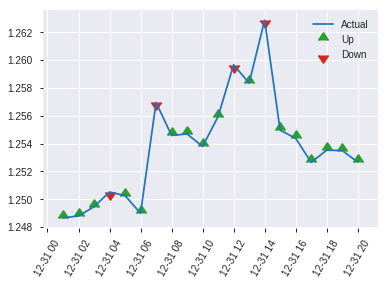


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2496404854850464
RMSE: 0.49964035614134134
LogLoss: 0.6924036470928132
Mean Per-Class Error: 0.4564305978774824
AUC: 0.5417358411264054
pr_auc: 0.533517344685021
Gini: 0.08347168225281076
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.322176069021225: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   297  0.9674   (297.0/307.0)
1      1    309  0.0032   (1.0/310.0)
Total  11   606  0.483    (298.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.322176     0.674672  389
max f2                       0.322176     0.836945  389
max f0point5                 0.322176     0.565106  389
max accuracy                 0.540064     0.54295   149
max precision                0.751199     1         0
max recall                   0.265656     1         395
max specificity              0.751199     1         0
max absolute_mcc             0.322176     0.110889  389
max min_per_class_accuracy   0.517277     0.519355  193
max mean_per_class_accuracy  0.540064     0.543569  149

Gains/Lift Table: Avg response rate: 50.24 %, avg score: 51.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.678426           0.568664  0.568664           0.285714         0.700459  0.285714                    0.700459            0.00645161      0.00645161                 -43.1336  -43.1336
    2        0.0210697                   0.657906           1.32688   0.91861            0.666667         0.663652  0.461538                    0.683471            0.0129032       0.0193548                  32.6882   -8.13896
    3        0.0307942                   0.640981           1.6586    1.15229            0.833333         0.648382  0.578947                    0.67239             0.016129        0.0354839                  65.8602   15.2292
    4        0.0405186                   0.634539           1.6586    1.27381            0.833333         0.637841  0.64                        0.664099            0.016129        0.0516129                  65.8602   27.3806
    5        0.0502431                   0.627698           1.32688   1.28408            0.666667         0.631909  0.645161                    0.657868            0.0129032       0.0645161                  32.6882   28.4079
    6        0.100486                    0.594514           0.963059  1.12357            0.483871         0.608244  0.564516                    0.633056            0.0483871       0.112903                   -3.69407  12.3569
    7        0.150729                    0.578687           1.02726   1.09147            0.516129         0.58637   0.548387                    0.617494            0.0516129       0.164516                   2.72633   9.14672
    8        0.200972                    0.567835           0.898855  1.04331            0.451613         0.572802  0.524194                    0.606321            0.0451613       0.209677                   -10.1145  4.33143
    9        0.299838                    0.549643           1.30513   1.12964            0.655738         0.558425  0.567568                    0.590528            0.129032        0.33871                    30.513    12.9643
    10       0.400324                    0.534493           0.930957  1.07977            0.467742         0.542732  0.54251                     0.578531            0.0935484       0.432258                   -6.90427  7.97701
    11       0.50081                     0.514376           0.898855  1.04347            0.451613         0.525344  0.524272                    0.567859            0.0903226       0.522581                   -10.1145  4.34701
    12       0.599676                    0.497639           1.07673   1.04895            0.540984         0.507827  0.527027                    0.557962            0.106452        0.629032                   7.67319   4.89538
    13       0.700162                    0.479572           0.963059  1.03663            0.483871         0.489381  0.520833                    0.548119            0.0967742       0.725806                   -3.69407  3.66263
    14       0.799028                    0.455757           0.815706  1.00929            0.409836         0.468168  0.507099                    0.538227            0.0806452       0.806452                   -18.4294  0.929137
    15       0.899514                    0.416288           1.02726   1.0113             0.516129         0.439561  0.508108                    0.527205            0.103226        0.909677                   2.72633   1.1299
    16       1                           0.224234           0.898855  1                  0.451613         0.36197   0.502431                    0.510601       

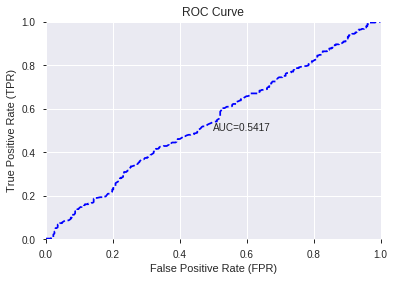

This function is available for GLM models only


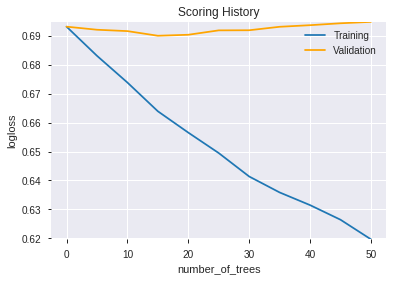

--2019-08-24 18:26:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_182602_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_182602_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a5a8',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'STOCHF_fastk',
 'BETA_30',
 'HT_DCPERIOD',
 'ADOSC',
 'MFI_24',
 'CCI_8',
 'MACDFIX_hist_8',
 'MINUS_DM_8',
 'STOCH_slowd',
 'STDDEV_20',
 'MFI_12',
 'CMO_8',
 'STDDEV_30',
 'HT_PHASOR_quadrature',
 'STDDEV_8',
 'PLUS_DI_14',
 'ADXR_12',
 'ULTOSC',
 'BETA_8',
 'WILLR_8',
 'MFI_8',
 'PLUS_DI_8',
 'ROC_30',
 'DX_14',
 'MFI_14',
 'BETA_14',
 'WILLR_14',
 'ROCP_24',
 'STOCHRSI_fastk',
 'LINEARREG_ANGLE_20',
 'ROC_8',
 'BBANDS_lowerband_30_7_3',
 'MOM_20',
 'NATR_30',
 'LINEARREG_SLOPE_14',
 'WILLR_24',
 'PPO',
 'ATR_20',
 'MINUS_DM_30',
 'ROC_14',
 'STOCH_slowk',
 'DX_12',
 'ROCP_12',
 'ADX_14',
 'MINUS_DI_12',
 'aroondown_14',
 'MOM_12',
 'VAR_12',
 'ROCR_24',
 'LINEARREG_ANGLE_8',
 'MINUS_DI_20',
 'aroondown_24',
 'aroondown_12',
 'BBANDS_upperband_24_6_2',
 'aroonup_14',
 'BBANDS_upperband_20_3_5',
 'aroondown_8',
 'STOCHF_fastd',
 'aroonup_30',
 'aroondown_30',
 'LINEARREG_SLOPE_8',
 'RSI_8',
 'aroonup_8']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.562
GLM             0.538
XGBoost         0.575
dtype: float64

DeepLearning    GLM  XGBoost
All          0.562  0.520    0.549
DLF          0.553  0.535    0.575
Fwe          0.548  0.538    0.558
RFE          0.533  0.525    0.543
XGBF         0.535  0.535    0.575





F1


DeepLearning    0.680
GLM             0.672
XGBoost         0.675
dtype: float64

DeepLearning    GLM  XGBoost
All          0.680  0.671    0.670
DLF          0.675  0.671    0.672
Fwe          0.672  0.672    0.670
RFE          0.671  0.672    0.675
XGBF         0.670  0.671    0.672





auc


DeepLearning    0.571
GLM             0.531
XGBoost         0.566
dtype: float64

DeepLearning    GLM  XGBoost
All          0.571  0.511    0.560
DLF          0.550  0.531    0.566
Fwe          0.544  0.531    0.558
RFE          0.532  0.517    0.542
XGBF         0.533  0.531    0.566





logloss


DeepLearning    0.745
GLM             0.693
XGBoost         0.692
dtype: float64

DeepLearning    GLM  XGBoost
All          0.715  0.693    0.688
DLF          0.745  0.692    0.689
Fwe          0.701  0.691    0.689
RFE          0.722  0.692    0.692
XGBF         0.693  0.692    0.689





mean_per_class_error


DeepLearning    0.467
GLM             0.478
XGBoost         0.456
dtype: float64

DeepLearning    GLM  XGBoost
All          0.437  0.478    0.449
DLF          0.448  0.466    0.425
Fwe          0.452  0.460    0.443
RFE          0.467  0.474    0.456
XGBF         0.465  0.466    0.425





rmse


DeepLearning    0.513
GLM             0.500
XGBoost         0.500
dtype: float64

DeepLearning    GLM  XGBoost
All          0.509  0.500    0.498
DLF          0.513  0.499    0.498
Fwe          0.503  0.499    0.498
RFE          0.512  0.500    0.500
XGBF         0.500  0.499    0.498





mse


DeepLearning    0.263
GLM             0.250
XGBoost         0.250
dtype: float64

DeepLearning    GLM  XGBoost
All          0.259  0.250    0.248
DLF          0.263  0.249    0.248
Fwe          0.253  0.249    0.248
RFE          0.262  0.250    0.250
XGBF         0.250  0.249    0.248

{'F1':       DeepLearning    GLM  XGBoost
 All          0.680    NaN      NaN
 DLF          0.675    NaN      NaN
 DLF            NaN  0.671      NaN
 DLF            NaN    NaN    0.672
 All            NaN  0.671      NaN
 All            NaN    NaN    0.670
 XGBF         0.670    NaN      NaN
 XGBF           NaN  0.671      NaN
 XGBF           NaN    NaN    0.672
 Fwe          0.672    NaN      NaN
 Fwe            NaN  0.672      NaN
 Fwe            NaN    NaN    0.670
 RFE          0.671    NaN      NaN
 RFE            NaN  0.672      NaN
 RFE            NaN    NaN    0.675,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.562    NaN      NaN
 DLF          0.553    NaN      NaN
 DLF            NaN  0.535      NaN
 DLF            NaN    NaN    0.575
 All            NaN  0.520      NaN
 All            NaN    NaN    0.549
 XGBF         0.535    NaN      NaN
 XGBF           NaN  0.535      NaN
 XGBF           NaN    NaN    0.575
 Fwe          0.548    NaN      NaN
 Fwe     